### Online Supplement A
This Jupyter notebook is used to generate all the results presented in the manuscript titled "Understanding How Extreme Heat Impacts Human Activity-Mobility and Time Use Patterns," except for the MNL model for mode choice, which is available in the notebook titled "mnl_estimation_mode_choice.ipynb."

To use different methods for defining and identifying extremely hot days compared to regular hot days, you may modify the calculate_heat_index_and_classification function. Two alternative methods are also provided in the flag_hottest_coldest functions, which classify extremely hot days as either the nine hottest days in a year or the days above the 95th percentile for a specific metro region. For more information, please reach out to Dr. Irfan Batur at ibatur@asu.edu.

In [1]:
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

### read and convert weather data
read weather data for all cities and years; merge them; convert their date format; and assign msa codes

In [2]:
import pandas as pd
import numpy as np
import os

In [3]:
def add_filename_column_and_remove_missings(csv_file):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_file)

    # Extract the file name from the path
    directory, file_name = os.path.split(csv_file)
    name, extension = os.path.splitext(file_name)

    # Add a new column with the file name in all rows
    df['city'] = name
    
    # Rename the columns
    df = df.rename(columns={'DailyMaximumDryBulbTemperature': 'tempf', 'DailyAverageRelativeHumidity': 'humid'})


    # Remove missing values from two columns
    columns_to_remove_missings = ['tempf', 'humid']
    df = df.dropna(subset=columns_to_remove_missings)

    # Reset the index after removing missing values
    df = df.reset_index(drop=True)

    # Return the modified dataset
    return df

In [4]:
import os

folder_path = "weather_data_humid"

# Get a list of file names in the folder
file_names = os.listdir(folder_path)
file_names

['atlanta.csv',
 'chicago.csv',
 'dallas.csv',
 'houston.csv',
 'los_angeles.csv',
 'miami.csv',
 'new_york.csv',
 'philadelphia.csv',
 'phoenix.csv',
 'seattle.csv',
 'washington.csv']

https://www.weather.gov/media/ffc/ta_htindx.PDF

In [5]:
def calculate_heat_index_and_classification(T, RH):
    
    heat_index_dictionary = {
    "80°F - 90°F": {
        "Classification": "Caution"
    },
    "90°F - 103°F": {
        "Classification": "Extreme Caution"
    },
    "103°F - 124°F": {
        "Classification": "Danger"
    },
    "125°F or higher": {
        "Classification": "Extreme Danger"
    },
    }

    # Heat index formula
    HI = (-42.379 + 2.04901523*T + 10.14333127*RH - .22475541*T*RH - .00683783*T*T - .05481717*RH*RH 
    + .00122874*T*T*RH + .00085282*T*RH*RH - .00000199*T*T*RH*RH)
    
    # Create an array for classifications based on the T values
    classifications = np.full(T.shape, "Normal", dtype=object)  # Initialize with "Normal" classification
    classifications[T >= 80] = "Check HI"  # Check HI for temperatures 80 or above

    # Update classifications based on HI, for temperatures 80 or above
    classifications[(classifications == "Check HI") & (HI < 90)] = heat_index_dictionary["80°F - 90°F"]["Classification"]
    classifications[(classifications == "Check HI") & (HI >= 90) & (HI < 103)] = heat_index_dictionary["90°F - 103°F"]["Classification"]
    classifications[(classifications == "Check HI") & (HI >= 103) & (HI < 125)] = heat_index_dictionary["103°F - 124°F"]["Classification"]
    classifications[(classifications == "Check HI") & (HI >= 125)] = heat_index_dictionary["125°F or higher"]["Classification"]

    return classifications, HI

<b> additional functions (methods) to use as an alterantive to determineing extreme heat days<b/>


In [6]:
# # Function to flag the hottest and coldest 9 days
# def flag_hottest_coldest(group):
#     group['rank_max'] = group['TMAX'].rank(ascending=False, method='min')
#     group['rank_min'] = group['TMAX'].rank(ascending=True, method='min')
#     if len(group) >= 9:
#         group['flag'] = 0
#         group.loc[group['rank_max'] <= 9, 'flag'] = 1  # Flag as among the hottest 9 days
# #         group.loc[group['rank_min'] <= 9, 'flag'] = 0  # Flag as among the coldest 9 days
#     else:
#         group['flag'] = None  # Insufficient records for flagging
#     return group

In [7]:
# # Function to flag the hottest and coldest days: using 95th and 5th percentiles

# import numpy as np

# def flag_hottest_coldest(df):
#     # Calculate the percentiles for each unique year
#     percentiles = df.groupby('year')['TMAX'].quantile([0.05, 0.95]).unstack()

#     # Function to assign values based on percentiles
#     def assign_value(row):
#         year = row['year']
#         value = row['TMAX']
#         if value > percentiles.loc[year, 0.95]:
#             return 1
#         else:
#             return 0

#     # Apply the function to create the new column
#     df['flag'] = df.apply(assign_value, axis=1)

#     return df


In [8]:
# Specify the folder path containing the CSV files
folder_path = "weather_data_humid"

# Create an empty list to store the datasets
datasets = []

# Iterate over each file in the folder
for file_name in os.listdir(folder_path):
    # Create the file path by joining the folder path and file name
    file_path = os.path.join(folder_path, file_name)

    # Apply the add_filename_column function to the file
    df = add_filename_column_and_remove_missings(file_path)
    
    # with the date column 'DATE'
    df['date'] = pd.to_datetime(df['DATE'])
    df['year'] = df['date'].dt.year
    
    # Create the new variable representing heat index 
    df['hi_class'], df['hi'] = calculate_heat_index_and_classification(df['tempf'],  df['humid'])

    # Append the modified dataset to the list
    datasets.append(df)

# Merge all datasets into a single DataFrame
merged_df = pd.concat(datasets, ignore_index=True)

# Print the merged DataFrame
merged_df.head(5)

STATION                 DATE REPORT_TYPE SOURCE  humid  tempf     city  \
0  72219013874  2006-01-01T23:59:00       SOD        6   70.0   65.0  atlanta   
1  72219013874  2006-01-02T23:59:00       SOD        6   89.0   67.0  atlanta   
2  72219013874  2006-01-03T23:59:00       SOD        6   72.0   59.0  atlanta   
3  72219013874  2006-01-04T23:59:00       SOD        6   69.0   65.0  atlanta   
4  72219013874  2006-01-05T23:59:00       SOD        6   70.0   55.0  atlanta   

                 date  year hi_class         hi  
0 2006-01-01 23:59:00  2006   Normal  74.534149  
1 2006-01-02 23:59:00  2006   Normal  65.288984  
2 2006-01-03 23:59:00  2006   Normal  78.988197  
3 2006-01-04 23:59:00  2006   Normal  74.891528  
4 2006-01-05 23:59:00  2006   Normal  86.277039

In [9]:
merged_df.STATION.unique()

array([72219013874, 72530094846, 72258013960, 72258313960, 72244012918,
       72243512918, 72295023174, 72202012839, 72503394728, 72505394728,
       72408013739, 72278023183, 72793024233, 72405013743], dtype=int64)

In [10]:
unique_pairs_df = merged_df[['STATION', 'city']].drop_duplicates()
print(unique_pairs_df)

           STATION          city
0      72219013874       atlanta
5053   72530094846       chicago
10101  72258013960        dallas
13479  72258313960        dallas
15150  72244012918       houston
18530  72243512918       houston
20201  72295023174   los_angeles
25250  72202012839         miami
30302  72503394728      new_york
31990  72505394728      new_york
34616  72408013739  philadelphia
39669  72278023183       phoenix
44715  72793024233       seattle
49768  72405013743    washington


In [11]:
# this is for check purposes to investigate if hi is correcty computed and hi-class is assigned accurate
import pandas as pd
import random

df = merged_df.sort_values(by='DATE')

# Set the seed for reproducibility
random.seed(100)

# Randomly select a starting index within the valid range
start_index = random.choice(range(len(df) - 20 + 1))

# Select the subsequent 20 rows from the starting index
sampled_df = df.iloc[start_index : start_index + 20]

sampled_df.head(5)

STATION                 DATE REPORT_TYPE SOURCE  humid  tempf  \
50635  72405013743  2008-05-17T23:59:00       SOD        6   48.0   77.0   
867    72219013874  2008-05-17T23:59:00       SOD        6   58.0   73.0   
45583  72793024233  2008-05-18T23:59:00       SOD        6   59.0   74.0   
14347  72258313960  2008-05-18T23:59:00       SOD        6   43.0   89.0   
26118  72202012839  2008-05-18T23:59:00       SOD        6   63.0   95.0   

             city                date  year         hi_class          hi  
50635  washington 2008-05-17 23:59:00  2008           Normal   78.541261  
867       atlanta 2008-05-17 23:59:00  2008           Normal   76.590049  
45583     seattle 2008-05-18 23:59:00  2008           Normal   76.894283  
14347      dallas 2008-05-18 23:59:00  2008  Extreme Caution   90.196291  
26118       miami 2008-05-18 23:59:00  2008           Danger  115.774067

In [12]:
import pandas as pd
import datetime

def convert_date(date_str):
    date = datetime.datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%S")
    year = date.year
    month = date.month
    day_of_year = (date - datetime.datetime(year, 1, 1)).days + 1
    return year, month, day_of_year

# Apply the convert_date() function to the 'DATE' column
merged_df[['Year', 'Month', 'Day']] = merged_df['DATE'].apply(lambda x: pd.Series(convert_date(x)))

# Adjust day_of_year for leap years
merged_df['Day'] = merged_df.apply(lambda row: row['Day'] 
                                   + 1 if datetime.datetime(row['Year'], 1, 1).strftime('%j') == '001' 
                                   else row['Day'], axis=1)

# Print the modified dataset
merged_df.sample(5)


STATION                 DATE REPORT_TYPE SOURCE  humid  tempf  \
23751  72295023174  2015-11-19T23:59:00       SOD        6   46.0   82.0   
4491   72219013874  2018-06-19T23:59:00       SOD        6   61.0   93.0   
39625  72408013739  2019-11-18T23:59:00       SOD        6   76.0   44.0   
24962  72295023174  2019-03-15T23:59:00       SOD        6   26.0   74.0   
2697   72219013874  2013-05-21T23:59:00       SOD        6   68.0   89.0   

               city                date  year         hi_class          hi  \
23751   los_angeles 2015-11-19 23:59:00  2015          Caution   82.200393   
4491        atlanta 2018-06-19 23:59:00  2018           Danger  108.116700   
39625  philadelphia 2019-11-18 23:59:00  2019           Normal  112.504869   
24962   los_angeles 2019-03-15 23:59:00  2019           Normal   76.282987   
2697        atlanta 2013-05-21 23:59:00  2013  Extreme Caution  101.785854   

       Year  Month  Day  
23751  2015     11  324  
4491   2018      6  171  
39625  2019     11  323  
24962  2019      3   75  
2697   2013      5  142

In [13]:
pd.crosstab(merged_df.city, merged_df.year)

year          2006  2007  2008  2009  2010  2011  2012  2013  2014  2015  \
city                                                                       
atlanta        365   365   366   365   365   365   366   334   365   337   
chicago        365   365   366   365   365   365   366   334   365   337   
dallas         365   365   366   365   364   365   366   334   365   337   
houston        365   365   365   365   365   365   366   334   365   337   
los_angeles    365   365   366   365   365   365   366   334   365   337   
miami          365   365   366   365   365   365   366   334   365   337   
new_york       365   365   366   365   227     0   154   334   361   335   
philadelphia   365   365   366   365   365   365   366   334   365   337   
phoenix        365   365   366   365   365   365   366   334   365   334   
seattle        365   365   366   365   365   365   366   334   365   337   
washington     365   365   366   365   365   365   366   334   365   337   

year          2016  2017  2018  2019  2020  
city                                        
atlanta        365   364   365   365     1  
chicago        365   364   362   363     1  
dallas         365   365   363   363     1  
houston        365   364   365   364     1  
los_angeles    365   365   365   360     1  
miami          365   364   365   364     1  
new_york       353   365   365   358     1  
philadelphia   365   365   365   364     1  
phoenix        363   364   364   364     1  
seattle        365   364   365   365     1  
washington     364   364   365   363     1

In [14]:
# to make sure if there are any duplicate days (check above)
# remove duplicate days and get the station with highest heat index
import pandas as pd

# Assuming "merged_df" is your DataFrame containing the data

# Convert the "date" column to datetime if it's not already in the correct format
# merged_df['date'] = pd.to_datetime(merged_df['DATE'])

# Sort the DataFrame by date and HI column in descending order
merged_df.sort_values(['DATE', 'city', 'hi'], ascending=[True, True, False], inplace=True)

# Drop duplicates based on date and city, keeping the first occurrence (which will have the highest HI value)
merged_df.drop_duplicates(subset=['date', 'city'], keep='first', inplace=True)

# Reset the index of the DataFrame
merged_df.reset_index(drop=True, inplace=True)

In [15]:
pd.crosstab(merged_df.city, merged_df.year)

year          2006  2007  2008  2009  2010  2011  2012  2013  2014  2015  \
city                                                                       
atlanta        365   365   366   365   365   365   366   334   365   337   
chicago        365   365   366   365   365   365   366   334   365   337   
dallas         365   365   366   365   364   365   366   334   365   337   
houston        365   365   365   365   365   365   366   334   365   337   
los_angeles    365   365   366   365   365   365   366   334   365   337   
miami          365   365   366   365   365   365   366   334   365   337   
new_york       365   365   366   365   227     0   154   334   361   335   
philadelphia   365   365   366   365   365   365   366   334   365   337   
phoenix        365   365   366   365   365   365   366   334   365   334   
seattle        365   365   366   365   365   365   366   334   365   337   
washington     365   365   366   365   365   365   366   334   365   337   

year          2016  2017  2018  2019  2020  
city                                        
atlanta        365   364   365   365     1  
chicago        365   364   362   363     1  
dallas         365   365   363   363     1  
houston        365   364   365   364     1  
los_angeles    365   365   365   360     1  
miami          365   364   365   364     1  
new_york       353   365   365   358     1  
philadelphia   365   365   365   364     1  
phoenix        363   364   364   364     1  
seattle        365   364   365   365     1  
washington     364   364   365   363     1

In [16]:
merged_df[(merged_df.hi_class == 'Normal')]['tempf'].mean()

60.90557614043613

In [17]:
# for the check purposes, print number of observations for each day and make sure days are from 1 to 365
# column_name = 'Day'
# value_counts = merged_df[column_name].value_counts()

# # Adjust the display settings to show the full list
# pd.set_option('display.max_rows', None)
# print(value_counts)

In [18]:
# Define the dictionary mapping city names to MSA codes
msa_codes = {
    'atlanta': 12060,
    'austin': 12420,
    'chicago': 16980,
    'dallas': 19100,
    'houston': 26420,
    'las_vegas': 29820,
    'los_angeles': 31080,
    'miami': 33100,
    'new_york': 35620,
    'philadelphia': 37980,
    'phoenix': 38060,
    'salt_lake': 41620,
    'san_francisco': 41860,
    'seattle': 42660,
    'washington': 47900
}

# Apply the city to MSA code mapping to the 'city' column in 'merged_df'
merged_df['MSA Code'] = merged_df['city'].apply(lambda x: msa_codes.get(x.lower(), 'Unknown'))

#subset for desired columns
selected_columns = ['hi_class', 'humid', 'tempf', 'hi', 'city', 'Year', 'Day', 'MSA Code', "Month"]
df_heat = merged_df[selected_columns]

# Rename the columns to lowercase with underscores
new_column_names = [column.lower().replace(' ', '_') for column in df_heat.columns]
df_heat.columns = new_column_names

# rename flag column
df_heat = df_heat.rename(columns={'hi_class': 'temp'})

del merged_df 

df_heat.sample(5)

temp  humid  tempf          hi     city  year  day  msa_code  month
30590   Normal   83.0   69.0   69.198744  chicago  2013  322     16980     11
23163   Normal   46.0   76.0   78.002637  phoenix  2011  323     38060     11
38254   Normal   49.0   68.0   77.405875   dallas  2015  317     19100     11
19534   Normal   69.0   44.0  115.537248  seattle  2010  325     42660     11
40540  Caution   43.0   87.0   87.377392  atlanta  2016  161     12060      6

In [19]:
pd.crosstab(df_heat.city, df_heat.year).head(1)

year     2006  2007  2008  2009  2010  2011  2012  2013  2014  2015  2016  \
city                                                                        
atlanta   365   365   366   365   365   365   366   334   365   337   365   

year     2017  2018  2019  2020  
city                             
atlanta   364   365   365     1

In [20]:
df_heat = df_heat[(df_heat.year <2020)]

In [21]:
# pd.crosstab(df_heat[(df_heat.month == 7) | (df_heat.month == 8)].city, 
#             df_heat[(df_heat.month == 7) | (df_heat.month == 8)].year)

In [22]:
df1 = df_heat[(df_heat.month == 7) | (df_heat.month == 8)]

df1['heat_class'] = 0
df1.loc[(df1.temp == "Extreme Danger") | (df1.temp == "Danger"), 'heat_class'] = 1

df1.to_csv('df_weather_city_year.csv')

# pd.crosstab([df1['city'], df1['heat_class']], df1['year'], margins=True, margins_name='Total')

In [23]:
# clear all datasets except for df_heat and msa_codes that will be used later
%reset_selective -f df_heat msa_codes

In [24]:
df_heat.city.unique()

array(['atlanta', 'chicago', 'dallas', 'houston', 'los_angeles', 'miami',
       'new_york', 'philadelphia', 'phoenix', 'seattle', 'washington'],
      dtype=object)

In [25]:
# check for a random city
df1=df_heat[(df_heat.city =="houston")]
pd.crosstab(df1.temp, df1.year)

year             2006  2007  2008  2009  2010  2011  2012  2013  2014  2015  \
temp                                                                          
Caution            41    46    51    39    30    45    63    26    33    49   
Danger            101   106   101    76   101    75    97    87    91    86   
Extreme Caution    69    54    50    42    45    55    73    29    49    53   
Extreme Danger      5     8     8    41    18    54    10    27    20    28   
Normal            149   151   155   167   171   136   123   165   172   121   

year             2016  2017  2018  2019  
temp                                     
Caution            37    52    32    33  
Danger             98   104    85   117  
Extreme Caution    52    60    37    36  
Extreme Danger     37    22    55    16  
Normal            141   126   156   162

## read atus data and merge with weather data

Download necessary atus multi-year files from the following link and place them a folder (e.g., atus_03_22): https://www.bls.gov/tus/data/datafiles-0323.htm

In [26]:
import os

# define atus folder path that includes all necessary atus files
folder_path = 'atus_03_22'

atus_file_paths = []  # List to store the file paths

# Iterate over all files in the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)  # Create the full file path
    if os.path.isfile(file_path):  # Check if it's a file (not a directory)
        atus_file_paths.append(file_path)  # Add the file path to the list

# Sort the file paths in alphabetical order
atus_file_paths = sorted(atus_file_paths)

# Print the file paths
for file_path in atus_file_paths:
    print(file_path)

atus_03_22\atusact_0322.dat
atus_03_22\atuscps_0322.dat
atus_03_22\atusresp_0322.dat
atus_03_22\atusrost_0322.dat
atus_03_22\atuswho_0322.dat


In [27]:
import pandas as pd
import numpy as np

cols = ['TUCASEID', 'TUACTIVITY_N', 'TEWHERE', 'TRTIER1P',  'TRTIER2P', 'TRCODEP', 'TUCUMDUR', 'TUACTDUR24']

df_act  = pd.read_table(atus_file_paths[0], sep=",", usecols=cols)

# df_act =df_act.sample(frac=0.10)

In [28]:
# add year and month information
df_resp = pd.read_table(atus_file_paths[2], sep=",")

df_act = pd.merge(df_act, df_resp[['TUYEAR', 'TUCASEID', 'TULINENO', 'TESCHFT', 'TELFS', 'TUMONTH',
                                   'TUDIARYDATE', 'TUDIARYDAY', 'TUFNWGTP' , 'TU20FWGT']], 
                  how="left", on=["TUCASEID"])

del df_resp

# create a weight variable for weights - due to the pandemic new weights used for 2020: 
# see the discussion in Chapter 7 of https://www.bls.gov/tus/atususersguide.pdf
df_act.loc[(df_act.TUYEAR == 2020), 'weight']=df_act.TU20FWGT/365
df_act.loc[(df_act.TUYEAR != 2020), 'weight']=df_act.TUFNWGTP/365

del df_act['TU20FWGT'], df_act['TUFNWGTP']

In [29]:
# Convert the date format and extract the day of the year and store them in a day column
df_act['day'] = pd.to_datetime(df_act['TUDIARYDATE'], format='%Y%m%d').dt.dayofyear

# Print a sample from the modified DataFrame
df_act.sample(n=10)

TUCASEID  TUACTIVITY_N  TUACTDUR24  TRCODEP  TRTIER1P  \
240054   20030707033072            29         105   120303        12   
1401237  20071009070061            10           6   180782        18   
4334121  20210404211450             4          60    20402         2   
3122614  20141211141345             3         120   120303        12   
898968   20051009051131             2           1   180482        18   
2003598  20100201101370             3          20   500106        50   
1658623  20081009081448            16          30   120303        12   
2341735  20110605111413             2          30    20101         2   
438271   20040112032390            29          15   181501        18   
1588649  20080706080105             3          15   180382        18   

         TRTIER2P  TUCUMDUR  TEWHERE  TUYEAR  TULINENO  TESCHFT  TELFS  \
240054       1203      1110        1    2003         1       -1      1   
1401237      1807       661       12    2007         1       -1      1   
4334121       204       270        1    2021         1       -1      5   
3122614      1203       480        1    2014         1       -1      1   
898968       1804       121       12    2005         1       -1      1   
2003598      5001       180       -1    2010         1       -1      1   
1658623      1203       831        1    2008         1       -1      5   
2341735       201       210        1    2011         1       -1      5   
438271       1815       900       12    2004         1       -1      1   
1588649      1803       435       12    2008         1       -1      5   

         TUMONTH  TUDIARYDATE  TUDIARYDAY        weight  day  
240054         7     20030727           1   3283.840221  208  
1401237       10     20071020           7  18451.959232  293  
4334121        4     20210427           3  18045.454320  117  
3122614       12     20141227           7  11876.503232  361  
898968        10     20051008           7   7020.531137  281  
2003598        2     20100203           4   6909.939246   34  
1658623       10     20081015           4  14792.534790  289  
2341735        6     20110615           4  14418.774409  166  
438271         1     20040105           2   8565.098624    5  
1588649        7     20080704           6  60260.710427  186

In [30]:
df_rost = pd.read_table(atus_file_paths[3], sep=",")

# add age and gender information
df_act = pd.merge(df_act, df_rost[['TESEX', 'TEAGE' , 'TUCASEID', 'TULINENO']], how="inner", on=["TUCASEID", 'TULINENO'])

del df_rost

In [31]:
# see https://www.bls.gov/tus/atusintcodebk0320.pdf for how to work with who file (page 5)
df_who  = pd.read_table(atus_file_paths[4], sep=",")

# get who accompanied information
df_act = pd.merge(df_act, df_who.groupby(['TUCASEID', 'TUACTIVITY_N' ])['TUWHO_CODE'].max().reset_index(),
                  how="left", 
                  on=["TUCASEID", 'TUACTIVITY_N',])

del df_who

In [32]:
df_cps  = pd.read_table(atus_file_paths[1], sep=",")

# add income, employment status, hh size, number of hh child information
df_act = pd.merge(df_act, df_cps[['HUFAMINC' , 'HEFAMINC', 'PREMPNOT', 'HRNUMHOU', 'PRNMCHLD' , 
                        'PTDTRACE', 'PEEDUCA', 'PRCITSHP' , 'GTMETSTA', 'GESTFIPS', 
                                  'GTCBSA', 'TUCASEID', 'TULINENO', 'PEHSPNON']], 
                  how="left", on=["TUCASEID", 'TULINENO'])

del df_cps

In [33]:
# check if msa codes are consistent in both weather and atus data
msa_codes

{'atlanta': 12060,
 'austin': 12420,
 'chicago': 16980,
 'dallas': 19100,
 'houston': 26420,
 'las_vegas': 29820,
 'los_angeles': 31080,
 'miami': 33100,
 'new_york': 35620,
 'philadelphia': 37980,
 'phoenix': 38060,
 'salt_lake': 41620,
 'san_francisco': 41860,
 'seattle': 42660,
 'washington': 47900}

In [34]:
df_act[(df_act.GTCBSA == 31080)]['GTCBSA'].value_counts()

31080    37779
Name: GTCBSA, dtype: int64

In [35]:
# df_act[(df_act.TUYEAR == 2022) & (df_act.GTCBSA == 38060) & 
#       (df_act["TUDIARYDAY"] >= 2) & (df_act["TUDIARYDAY"] <= 6) ]['TUCASEID'].nunique()

In [36]:
df_act.TUDIARYDAY.value_counts()

1    1108129
7    1073808
4     489006
3     484495
2     483217
5     476174
6     472537
Name: TUDIARYDAY, dtype: int64

In [37]:
df_act[(df_act.GTCBSA == 31080)]['GTCBSA'].value_counts()

31080    37779
Name: GTCBSA, dtype: int64

note here because GTCBSA (MSA info) is collected only after 2004, it is not available in 2003.

In [38]:
df_act[(df_act.TUYEAR == 2003)]['GTCBSA'].value_counts()

-1    412611
Name: GTCBSA, dtype: int64

In [39]:
# subset for desired MSAs | see page 102 for metro area codes on https://www.bls.gov/tus/atuscpscodebk20.pdf
df_act = df_act[df_act['GTCBSA'].isin(msa_codes.values())]

In [40]:
df_act.GTCBSA.value_counts()

35620    205741
16980    116481
47900     85200
19100     75473
37980     72802
33100     62102
26420     62058
12060     60886
42660     53130
41860     52889
38060     47280
31080     37779
29820     24045
12420     21407
41620     18069
Name: GTCBSA, dtype: int64

In [41]:
df_heat.head()

temp  humid  tempf          hi         city  year  day  msa_code  month
0   Normal   70.0   65.0   74.534149      atlanta  2006    2     12060      1
1   Normal   78.0   45.0  107.808311      chicago  2006    2     16980      1
2  Caution   42.0   82.0   81.688526       dallas  2006    2     19100      1
3  Caution   81.0   82.0   89.045195      houston  2006    2     26420      1
4   Normal   93.0   61.0   62.449613  los_angeles  2006    2     31080      1

In [42]:
df_act.head()

TUCASEID  TUACTIVITY_N  TUACTDUR24  TRCODEP  TRTIER1P  TRTIER2P  \
575094  20040707040067             1         360    10101         1       101   
575095  20040707040067             2          60    10201         1       102   
575096  20040707040067             3          20    20201         2       202   
575097  20040707040067             4         120   120303        12      1203   
575098  20040707040067             5         130    10101         1       101   

        TUCUMDUR  TEWHERE  TUYEAR  TULINENO  ...  PREMPNOT  HRNUMHOU  \
575094       360       -1    2004         1  ...         4         1   
575095       420       -1    2004         1  ...         4         1   
575096       440        1    2004         1  ...         4         1   
575097       560        1    2004         1  ...         4         1   
575098       690       -1    2004         1  ...         4         1   

        PRNMCHLD  PTDTRACE  PEEDUCA  PRCITSHP  GTMETSTA  GESTFIPS  GTCBSA  \
575094        -1         3       36         1         1        18   16980   
575095        -1         3       36         1         1        18   16980   
575096        -1         3       36         1         1        18   16980   
575097        -1         3       36         1         1        18   16980   
575098        -1         3       36         1         1        18   16980   

        PEHSPNON  
575094         2  
575095         2  
575096         2  
575097         2  
575098         2  

[5 rows x 32 columns]

In [43]:
# change year and msa code column name
df_act = df_act.rename(columns={'TUYEAR': 'year', 'GTCBSA': 'msa_code'})

In [44]:
# los angeles value counts
df_act[(df_act.msa_code == 31080) & (df_act.TUMONTH >= 7) & 
       (df_act.TUMONTH <= 8) & (df_act.year <= 2019)]['TUCASEID'].nunique()

203

In [45]:
# merge two data sets
df_act = pd.merge(df_act, 
                  df_heat[['temp', 'city', 'tempf', 'humid', 'hi', 'year', 'day', 'msa_code']], 
                  how='left', 
                  on=['year', 'day', 'msa_code'])

# delete weather data
del df_heat

In [46]:
# Check for missing values in a specific column
missing_values = df_act['temp'].isna().sum()

print("Number of missing values:", missing_values)

Number of missing values: 334980


In [47]:
# drop days without temp value
# Drop rows with missing values in a specific column
df_act.dropna(subset=['temp'], inplace=True)

# Reset the index of the DataFrame
df_act.reset_index(drop=True, inplace=True)

In [48]:
df_act.temp.value_counts()

Normal             420024
Caution             82426
Extreme Caution     77472
Danger              74018
Extreme Danger       6422
Name: temp, dtype: int64

In [49]:
pd.crosstab(df_act.temp, df_act.year)

year              2006   2007   2008   2009   2010   2011   2012   2013  \
temp                                                                      
Caution           6141   6098   7962   5578   5824   4555   5380   5216   
Danger            4436   4439   5487   4950   7437   5512   5588   4934   
Extreme Caution   6122   7073   6087   5501   5705   4876   5387   4275   
Extreme Danger     259    315    101    467    596    874    441    235   
Normal           35549  30450  32732  36689  30116  22097  25391  28399   

year              2014   2015   2016   2017   2018   2019  
temp                                                       
Caution           6779   5509   6589   7418   4676   4701  
Danger            4312   5254   5889   5154   5215   5411  
Extreme Caution   4972   6748   5994   5712   4820   4200  
Extreme Danger     452    317    652    531    786    396  
Normal           30291  25813  33287  31457  29114  28639

In [50]:
df_act.temp.value_counts()

Normal             420024
Caution             82426
Extreme Caution     77472
Danger              74018
Extreme Danger       6422
Name: temp, dtype: int64

In [51]:
# Check for missing values in a specific column
missing_values = df_act['temp'].isna().sum()

print("Number of missing values:", missing_values)

Number of missing values: 0


<b> subset for summer months and between 2004 and 2019

In [52]:
df_act = df_act[(df_act.TUMONTH >= 7) & (df_act.TUMONTH <= 8)]
df_act = df_act[(df_act.year <= 2019)]

In [53]:
df_act.columns

Index(['TUCASEID', 'TUACTIVITY_N', 'TUACTDUR24', 'TRCODEP', 'TRTIER1P',
       'TRTIER2P', 'TUCUMDUR', 'TEWHERE', 'year', 'TULINENO', 'TESCHFT',
       'TELFS', 'TUMONTH', 'TUDIARYDATE', 'TUDIARYDAY', 'weight', 'day',
       'TESEX', 'TEAGE', 'TUWHO_CODE', 'HUFAMINC', 'HEFAMINC', 'PREMPNOT',
       'HRNUMHOU', 'PRNMCHLD', 'PTDTRACE', 'PEEDUCA', 'PRCITSHP', 'GTMETSTA',
       'GESTFIPS', 'msa_code', 'PEHSPNON', 'temp', 'city', 'tempf', 'humid',
       'hi'],
      dtype='object')

In [54]:
# create socio-dem and other attributes
# https://www.bls.gov/tus/atusintcodebk0320.pdf for interview data
# https://www.bls.gov/tus/atuscpscodebk20.pdf for cps

# gender
df_act.loc[(df_act["TESEX"] == 2), 'female'] = 1
df_act.loc[(df_act["female"] != 1), 'female'] = 0

df_act.loc[(df_act["TESEX"] == 1), 'male'] = 1
df_act.loc[(df_act["male"] != 1), 'male'] = 0

# age
# create bins for value column
df_act.loc[(df_act["TEAGE"] >= 15) & (df_act["TEAGE"] < 20), 'age_15_19'] = 1
df_act.loc[(df_act["age_15_19"] != 1), 'age_15_19'] = 0

df_act.loc[(df_act["TEAGE"] >= 20) & (df_act["TEAGE"] < 30), 'age_20_29'] = 1
df_act.loc[(df_act["age_20_29"] != 1), 'age_20_29'] = 0

df_act.loc[(df_act["TEAGE"] >= 30) & (df_act["TEAGE"] < 50), 'age_30_49'] = 1
df_act.loc[(df_act["age_30_49"] != 1), 'age_30_49'] = 0

df_act.loc[(df_act["TEAGE"] >= 50) & (df_act["TEAGE"] < 65), 'age_50_64'] = 1
df_act.loc[(df_act["age_50_64"] != 1), 'age_50_64'] = 0

df_act.loc[(df_act["TEAGE"] >= 65), 'age_65p'] = 1
df_act.loc[(df_act["age_65p"] != 1), 'age_65p'] = 0

# race
df_act.loc[(df_act["PTDTRACE"] == 1), 'white'] = 1
df_act.loc[(df_act["white"] != 1), 'white'] = 0

df_act.loc[(df_act["PTDTRACE"] == 2), 'black'] = 1
df_act.loc[(df_act["black"] != 1), 'black'] = 0

df_act.loc[(df_act["PTDTRACE"] == 4), 'asian'] = 1
df_act.loc[(df_act["asian"] != 1), 'asian'] = 0

# education
df_act['less_than_hs'] = 0
df_act.loc[(df_act["PEEDUCA"] >= 31) & (df_act["PEEDUCA"] <= 38), 'less_than_hs'] = 1

df_act['hs_grad'] = 0
df_act.loc[(df_act["PEEDUCA"] >= 39) & (df_act["PEEDUCA"] <= 39), 'hs_grad'] = 1

df_act['some_col_assc_deg'] = 0
df_act.loc[(df_act["PEEDUCA"] >= 40) & (df_act["PEEDUCA"] <= 42), 'some_col_assc_deg'] = 1

df_act['bachelor'] = 0
df_act.loc[(df_act["PEEDUCA"] >= 43) & (df_act["PEEDUCA"] <= 43), 'bachelor'] = 1

df_act['grad_sch'] = 0
df_act.loc[(df_act["PEEDUCA"] >= 44) & (df_act["PEEDUCA"] <= 46), 'grad_sch'] = 1

# income
df_act['inc_up35'] = 0
df_act.loc[(df_act["year"] <= 2009) & (df_act["HUFAMINC"] > 0) & (df_act["HUFAMINC"] < 10), 'inc_up35'] = 1
df_act.loc[(df_act["year"] >= 2010) & (df_act["HEFAMINC"] > 0) & (df_act["HEFAMINC"] < 10), 'inc_up35'] = 1

df_act['inc_35_50'] = 0
df_act.loc[(df_act["year"] <= 2009) & (df_act["HUFAMINC"] >= 10) & (df_act["HUFAMINC"] <= 11), 'inc_35_50'] = 1
df_act.loc[(df_act["year"] >= 2010) & (df_act["HEFAMINC"] >= 10) & (df_act["HEFAMINC"] <= 11), 'inc_35_50'] = 1

df_act['inc_50_75'] = 0
df_act.loc[(df_act["year"] <= 2009) & (df_act["HUFAMINC"] >= 12) & (df_act["HUFAMINC"] <= 13), 'inc_50_75'] = 1
df_act.loc[(df_act["year"] >= 2010) & (df_act["HEFAMINC"] >= 12) & (df_act["HEFAMINC"] <= 13), 'inc_50_75'] = 1

df_act['inc_75_100'] = 0
df_act.loc[(df_act["year"] <= 2009) & (df_act["HUFAMINC"] >= 14) & (df_act["HUFAMINC"] <= 14), 'inc_75_100'] = 1
df_act.loc[(df_act["year"] >= 2010) & (df_act["HEFAMINC"] >= 14) & (df_act["HEFAMINC"] <= 14), 'inc_75_100'] = 1

df_act['inc_100p'] = 0
df_act.loc[(df_act["year"] <= 2009) & (df_act["HUFAMINC"] >= 15) & (df_act["HUFAMINC"] <= 16), 'inc_100p'] = 1
df_act.loc[(df_act["year"] >= 2010) & (df_act["HEFAMINC"] >= 15) & (df_act["HEFAMINC"] <= 16), 'inc_100p'] = 1

# worker
df_act['worker'] = 0
df_act.loc[(df_act["TELFS"] == 1) | (df_act["TELFS"] == 2), 'worker'] = 1

# nonworker
df_act['nonworker'] = 0
df_act.loc[(df_act["worker"] == 0), 'nonworker'] = 1

# student
df_act['student'] = 0
df_act.loc[(df_act["TESCHFT"] >= 1), 'student'] = 1

# weekday
df_act['weekday'] = 0
df_act.loc[(df_act["TUDIARYDAY"] >= 2) & (df_act["TUDIARYDAY"] <= 6), 'weekday'] = 1

# hh size
df_act['hhsize_1'] = 0
df_act.loc[(df_act["HRNUMHOU"] == 1), 'hhsize_1'] = 1

df_act['hhsize_2'] = 0
df_act.loc[(df_act["HRNUMHOU"] == 2), 'hhsize_2'] = 1

df_act['hhsize_3p'] = 0
df_act.loc[(df_act["HRNUMHOU"] >= 3), 'hhsize_3p'] = 1

# hh child presence
df_act['child_present'] = 0
df_act.loc[(df_act["PRNMCHLD"] >= 1), 'child_present'] = 1

# household location
df_act['non_metropolitan'] = 0
df_act.loc[(df_act["GTMETSTA"] == 2), 'non_metropolitan'] = 1

# car trip and car user
df_act['car_trip'] = 0
df_act.loc[(df_act["TRTIER1P"] == 18) & (df_act["TEWHERE"] >= 12) & (df_act["TEWHERE"] <= 13), 'car_trip'] = 1

df_act['traveling'] = 0
df_act.loc[(df_act["TRTIER1P"] == 18) & (df_act["TEWHERE"] > 1), 'traveling'] = 1

df_a = df_act.groupby(['TUCASEID'])[['car_trip', 'traveling']].sum().reset_index()

df_a['car_user'] = 0
df_a.loc[(df_a.traveling >= 1) & (df_a.traveling * 0.5 <= df_a.car_trip), 'car_user'] = 1


df_act = pd.merge(df_act, df_a[['car_user', 'TUCASEID']], 
                  how="left", on=["TUCASEID"])
del df_a

In [55]:
# create vulnerable groups

df_act['hisp'] = 0
df_act.loc[(df_act.PEHSPNON == 1), 'hisp']=1

df_act['non_hisp_white'] = 0
df_act.loc[(df_act.hisp == 0) & (df_act.white == 1), 'non_hisp_white']=1

df_act['black_hisp'] = 0
df_act.loc[(df_act.hisp == 1) | (df_act.black == 1), 'black_hisp']=1

df_act['no_age_65p'] = 1 - df_act.age_65p

<b>Activity durations by activity type

In [56]:
# redefine in_home, out_home activities because it was previously defined as in_home, out_home, and travel for swb analysis
df_act.loc[(df_act["TEWHERE"] <= 1), 'in_home'] = 1
df_act.loc[(df_act["in_home"] != 1), 'in_home'] = 0
df_act.loc[(df_act["in_home"] == 0), 'out_home'] = 1
df_act.loc[(df_act["out_home"] != 1), 'out_home'] = 0

In [57]:
# sleep_nap
df_act['sleep'] = 0
df_act.loc[(df_act["TRTIER2P"] == 101), 'sleep'] = 1

# personal_care
df_act['per_care'] = 0
df_act.loc[(df_act["TRTIER1P"] == 1) & (df_act["sleep"] != 1), 'per_care'] = 1

# hh_activities
df_act['hh_acts'] = 0
df_act.loc[(df_act["TRTIER1P"] == 2), 'hh_acts'] = 1

# hh_member_care
df_act['hhmember_care'] = 0
df_act.loc[(df_act["TRTIER1P"] == 3), 'hhmember_care'] = 1

# nhh_member_care
df_act['nhhmember_care'] = 0
df_act.loc[(df_act["TRTIER1P"] == 4), 'nhhmember_care'] = 1

# work
df_act['work_act'] = 0
df_act.loc[(df_act["TRTIER1P"] == 5), 'work_act'] = 1

# education
df_act['education'] = 0
df_act.loc[(df_act["TRTIER1P"] == 6), 'education'] = 1

# shopping
df_act['shopping'] = 0
df_act.loc[(df_act["TRTIER1P"] == 7), 'shopping'] = 1

# per_services
df_act['per_services'] = 0
df_act.loc[(df_act["TRTIER1P"] == 8), 'per_services'] = 1

# hh_services
df_act['hh_services'] = 0
df_act.loc[(df_act["TRTIER1P"] == 9), 'hh_services'] = 1

# gov_civic
df_act['gov_civic'] = 0
df_act.loc[(df_act["TRTIER1P"] == 10), 'gov_civic'] = 1

# eating
df_act['eating'] = 0
df_act.loc[(df_act["TRTIER1P"] == 11), 'eating'] = 1

# social_leisure
df_act['soc_leisure'] = 0
df_act.loc[(df_act["TRTIER1P"] == 12), 'soc_leisure'] = 1

# recreational
df_act['recreational'] = 0
df_act.loc[(df_act["TRTIER1P"] == 13), 'recreational'] = 1

# religious
df_act['religious'] = 0
df_act.loc[(df_act["TRTIER1P"] == 14), 'religious'] = 1

# volunteer
df_act['volunteer'] = 0
df_act.loc[(df_act["TRTIER1P"] == 15), 'volunteer'] = 1

# phone_calls
df_act['phone_calls'] = 0
df_act.loc[(df_act["TRTIER1P"] == 16), 'phone_calls'] = 1

# travel
df_act['traveling'] = 0
df_act.loc[(df_act["TRTIER1P"] == 18), 'traveling'] = 1

# unidentified_50
df_act['unidentified'] = 0
df_act.loc[(df_act["TRTIER1P"] == 50), 'unidentified'] = 1

# total
df_act['total'] = 1

In [58]:
df_act.TRCODEP.value_counts()

10101     12215
110101    11374
120303     8256
10201      7870
20201      4885
          ...  
80102         1
50203         1
59999         1
80499         1
20299         1
Name: TRCODEP, Length: 335, dtype: int64

In [59]:
# additional considerations in the context of heatwaves

# grocery_travel counts and duration
df_act['grocery_travel']=0
df_act.loc[(df_act["TRCODEP"] == 180701) , 'grocery_travel'] = 1

# eating_travel counts and duration
df_act['eating_travel']=0
df_act.loc[(df_act["TRTIER2P"] == 1811) , 'eating_travel'] = 1

# recrational_travel counts and duration
df_act['recrational_travel']=0
df_act.loc[(df_act["TRTIER2P"] == 1813) , 'recrational_travel'] = 1

# social_travel counts and duration
df_act['social_travel']=0
df_act.loc[(df_act["TRTIER2P"] == 1812 ) , 'social_travel'] = 1

# walk+bike counts and duration
df_act['walk_bike'] = 0
df_act.loc[(df_act["TRTIER1P"] == 18) & (df_act["TEWHERE"] == 14) , 'walk_bike'] = 1
df_act.loc[(df_act["TRTIER1P"] == 18) & (df_act["TEWHERE"] == 17) , 'walk_bike'] = 1

# transit counts and duration (bur or rail)
df_act['transit'] = 0
df_act.loc[(df_act["TRTIER1P"] == 18) & (df_act["TEWHERE"] == 15) , 'transit'] = 1
df_act.loc[(df_act["TRTIER1P"] == 18) & (df_act["TEWHERE"] == 16) , 'transit'] = 1

# time of day variables
# Create bins for the value column
bins = list(range(0, 1441, 240))  # Create bins with 120-minute intervals from 0 to 1440
labels = ['4-8', '8-12', '12-16', '16-20', '20-24', '0-4']
df_act['time_of_day'] = pd.cut(df_act['TUCUMDUR'], bins=bins, labels=labels)

# morning (8-12) activities
df_act['morning'] = 0
df_act.loc[(df_act.time_of_day == '8-12'), 'morning']=1

df_act['morning_walk_bike'] = df_act['morning'] * df_act['walk_bike']
df_act['morning_transit'] = df_act['morning'] * df_act['transit']
df_act['morning_grocery_travel'] = df_act['morning'] * df_act['grocery_travel']
df_act['morning_recrational_travel'] = df_act['morning'] * df_act['recrational_travel']
df_act['morning_social_travel'] = df_act['morning'] * df_act['social_travel']

# afternoon (12-4) activities
df_act['afternoon'] = 0
df_act.loc[(df_act.time_of_day == '12-16'), 'afternoon']=1

df_act['afternoon_walk_bike'] = df_act['afternoon'] * df_act['walk_bike']
df_act['afternoon_transit'] = df_act['afternoon'] * df_act['transit']
df_act['afternoon_grocery_travel'] = df_act['afternoon'] * df_act['grocery_travel']
df_act['afternoon_recrational_travel'] = df_act['afternoon'] * df_act['recrational_travel']
df_act['afternoon_social_travel'] = df_act['afternoon'] * df_act['social_travel']

# evening (4-8) activities
df_act['evening'] = 0
df_act.loc[(df_act.time_of_day == '12-16'), 'evening']=1

df_act['evening_walk_bike'] = df_act['evening'] * df_act['walk_bike']
df_act['evening_transit'] = df_act['evening'] * df_act['transit']
df_act['evening_grocery_travel'] = df_act['evening'] * df_act['grocery_travel']
df_act['evening_recrational_travel'] = df_act['evening'] * df_act['recrational_travel']
df_act['evening_social_travel'] = df_act['evening'] * df_act['social_travel']

# outdoor location away from home
df_act['outdoor_away'] = 0
df_act.loc[(df_act["TEWHERE"] == 9) , 'outdoor_away'] = 1

In [60]:
# define a function that creates activity type and duration account for in-home and out-of-home
def act_count_dur (df, variable):

    df['in_' + variable] = df[variable] * df['in_home']
    
    df['out_' + variable] = df[variable] * df['out_home']
    
    df['in_' + variable + '_dur'] = df[variable] * df['TUACTDUR24'] * df['in_home']
    
    df['out_' + variable + '_dur'] = df[variable] * df['TUACTDUR24'] * df['out_home']



In [61]:
# loop through act types and create new variables to show act count and act duration
act_types = [
    'sleep',
    'per_care',
    'hh_acts',
    'hhmember_care',
    'nhhmember_care',
    'work_act',
    'education',
    'shopping',
    'per_services',
    'hh_services',
    'gov_civic',
    'eating',
    'soc_leisure',
    'recreational',
    'religious',
    'volunteer',
    'phone_calls',
    'traveling',
    'unidentified',
    'total',
    'grocery_travel',
    'eating_travel',
    'walk_bike',
    'transit', 
    'morning', 
    'morning_walk_bike', 
    'morning_transit', 
    'morning_grocery_travel', 
    'morning_recrational_travel', 
    'morning_social_travel', 
    'afternoon', 
    'afternoon_walk_bike', 
    'afternoon_transit', 
    'afternoon_grocery_travel', 
    'afternoon_recrational_travel', 
    'afternoon_social_travel', 
    'evening', 
    'evening_walk_bike', 
    'evening_transit', 
    'evening_grocery_travel', 
    'evening_recrational_travel', 
    'evening_social_travel',
    'outdoor_away'
]

for i in range(len(act_types)):
    act_count_dur(df_act, act_types[i])

In [62]:
# print all column names
column_names = df_act.columns.tolist()
print(column_names)

['TUCASEID', 'TUACTIVITY_N', 'TUACTDUR24', 'TRCODEP', 'TRTIER1P', 'TRTIER2P', 'TUCUMDUR', 'TEWHERE', 'year', 'TULINENO', 'TESCHFT', 'TELFS', 'TUMONTH', 'TUDIARYDATE', 'TUDIARYDAY', 'weight', 'day', 'TESEX', 'TEAGE', 'TUWHO_CODE', 'HUFAMINC', 'HEFAMINC', 'PREMPNOT', 'HRNUMHOU', 'PRNMCHLD', 'PTDTRACE', 'PEEDUCA', 'PRCITSHP', 'GTMETSTA', 'GESTFIPS', 'msa_code', 'PEHSPNON', 'temp', 'city', 'tempf', 'humid', 'hi', 'female', 'male', 'age_15_19', 'age_20_29', 'age_30_49', 'age_50_64', 'age_65p', 'white', 'black', 'asian', 'less_than_hs', 'hs_grad', 'some_col_assc_deg', 'bachelor', 'grad_sch', 'inc_up35', 'inc_35_50', 'inc_50_75', 'inc_75_100', 'inc_100p', 'worker', 'nonworker', 'student', 'weekday', 'hhsize_1', 'hhsize_2', 'hhsize_3p', 'child_present', 'non_metropolitan', 'car_trip', 'traveling', 'car_user', 'hisp', 'non_hisp_white', 'black_hisp', 'no_age_65p', 'in_home', 'out_home', 'sleep', 'per_care', 'hh_acts', 'hhmember_care', 'nhhmember_care', 'work_act', 'education', 'shopping', 'per_s

In [63]:
df_act['outside'] = (df_act.out_recreational + df_act.out_shopping + df_act.out_soc_leisure
    + df_act.out_eating)

<b> recode temp variable

In [64]:
df_act.loc[(df_act.temp == 'Normal'), 'temp'] = 0
df_act.loc[(df_act.temp == 'Caution'), 'temp'] = 0
df_act.loc[(df_act.temp == 'Extreme Caution'), 'temp'] = 0
df_act.loc[(df_act.temp == 'Danger'), 'temp'] = 1
df_act.loc[(df_act.temp == 'Extreme Danger'), 'temp'] = 1

In [65]:
df_act.temp.unique()

array([0, 1], dtype=object)

<b> plot in two-hour bins

In [66]:
import pandas as pd
import plotly.graph_objs as go

# 'grocery_travel', 'eating_travel', 'recrational_travel', 'social_travel', 'walk_bike', 'transit'

# Filter the DataFrame for the reference activity
ref = ['traveling']
dist = df_act[(df_act[ref[0]] == 1) & (df_act.hhsize_1 == 1)]
# dist = dist[dist.black == 1]

# Create bins for the value column
# two-hour bins
bins = list(range(0, 1441, 120))  # Create bins with 120-minute intervals from 0 to 1440
labels = [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 2]

# # one hour bins
# bins = [0, 60, 120, 180, 240, 300, 360, 420, 480, 540, 600, 660, 720, 780,
#         840, 900, 960, 1020, 1080, 1140, 1200, 1260, 1320, 1380, 1440]
# labels = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 1, 2, 3]

dist['hour'] = pd.cut(dist['TUCUMDUR'], bins=bins, labels=labels)

# Group the data by temperature and hour and calculate the percentage distribution
grouped_data = dist.groupby(['temp', 'hour']).size().reset_index(name='count')
grouped_data['percentage'] = grouped_data.groupby('temp')['count'].transform(lambda x: x / x.sum() * 100)
recode_dict = {0.0: 'Non-Extreme', 1.0: 'Extreme'}
grouped_data['temp'] = grouped_data['temp'].replace(recode_dict)

# Sort by hour
grouped_data['hour'] = grouped_data['hour'].astype(int)
grouped_data.sort_values(by='hour', ascending=True, inplace=True)

# Create separate traces for each temperature
traces = []
colors = {'Cool': 'blue', 'Non-Extreme': '#7B7B7B', 'Extreme': '#BF2600'}  # Specify colors for each temperature
for temp in grouped_data['temp'].unique():
    data_temp = grouped_data[grouped_data['temp'] == temp]
    trace = go.Scatter(
        x=data_temp['hour'],
        y=data_temp['percentage'],
        mode='lines',
        name=f'{temp}' + f' (N={grouped_data[grouped_data["temp"] == temp]["count"].sum()})',
        line=dict(color=colors[temp], width=3)  # Assign color based on temperature
    )
    traces.append(trace)

# Create a list of hours to use as the x-axis
hours = list(range(1, 25))

# Create the layout for the plot
layout = go.Layout(
    title=f"hourly distribution of {ref[0]} activities (N={dist.shape[0]})",
    xaxis=dict(
        title=dict(
        text='Hour',
        standoff=1),
        tickvals=hours,
        showline=True,  # Add the x-axis line
        linewidth=1,  # Set the width of the x-axis line
        linecolor='#7F7F7F',  # Set the color of the x-axis line
        # Add upper and tight borders
        mirror=True,  # Reflect the axis line across the entire plot
        ticks='inside',  # Draw ticks inside the plot
        showticklabels=True,  # Show tick labels
        tickwidth=1,  # Set the width of the tick lines
        tickcolor='#7F7F7F'  # Set the color of the tick lines
    ),
    yaxis=dict(
        title=dict(
            text='Share of trips (%)',
        standoff=1),  # Distance between tick labels and title
        showline=True,  # Add the y-axis line
        linewidth=1,  # Set the width of the y-axis line
        linecolor='#7F7F7F',  # Set the color of the y-axis line
        # Add upper and tight borders
        mirror=True,  # Reflect the axis line across the entire plot
        ticks='inside',  # Draw ticks inside the plot
        showticklabels=True,  # Show tick labels
        tickwidth=1,  # Set the width of the tick lines
        tickcolor='#7F7F7F'  # Set the color of the tick lines
    ),
    plot_bgcolor="#F1F1F1",
    width=850,  # Set the width of the figure
    height=550,  # Set the height of the figure
    legend=dict(
        x=0,  # Legend x position
        y=1,  # Legend y position
        traceorder="normal",
        font=dict(
            size=12,
        )
    ),
    font=dict(  # Apply font to all textual elements
        family="Open Sans",  # Set font family to Roboto
        color="black"  # Set font color to black
    )
)

# Create the figure and show the graph
fig = go.Figure(data=traces, layout=layout)
fig.show()

<b> aggregate to person level

In [67]:
# print all column names
column_names = df_act.columns.tolist()
act_type=column_names[73:]
act_type.remove('time_of_day')
act_type.append('traveling')
act_type.append('car_trip')


print(act_type)

['in_home', 'out_home', 'sleep', 'per_care', 'hh_acts', 'hhmember_care', 'nhhmember_care', 'work_act', 'education', 'shopping', 'per_services', 'hh_services', 'gov_civic', 'eating', 'soc_leisure', 'recreational', 'religious', 'volunteer', 'phone_calls', 'unidentified', 'total', 'grocery_travel', 'eating_travel', 'recrational_travel', 'social_travel', 'walk_bike', 'transit', 'morning', 'morning_walk_bike', 'morning_transit', 'morning_grocery_travel', 'morning_recrational_travel', 'morning_social_travel', 'afternoon', 'afternoon_walk_bike', 'afternoon_transit', 'afternoon_grocery_travel', 'afternoon_recrational_travel', 'afternoon_social_travel', 'evening', 'evening_walk_bike', 'evening_transit', 'evening_grocery_travel', 'evening_recrational_travel', 'evening_social_travel', 'outdoor_away', 'in_sleep', 'out_sleep', 'in_sleep_dur', 'out_sleep_dur', 'in_per_care', 'out_per_care', 'in_per_care_dur', 'out_per_care_dur', 'in_hh_acts', 'out_hh_acts', 'in_hh_acts_dur', 'out_hh_acts_dur', 'in_h

In [68]:
df = pd.merge(df_act.groupby(['TUCASEID'])[act_type].sum().reset_index(),
         df_act[['TUCASEID', 'year', 'temp', 'tempf', 'humid', 'hi', 'male', 'female', 'age_15_19', 'age_20_29', 'age_30_49',
                 'age_50_64', 'age_65p',  'white', 'black', 'asian', 'less_than_hs', 'hs_grad',
       'some_col_assc_deg', 'bachelor', 'grad_sch', 'inc_up35', 'inc_35_50',
       'inc_50_75', 'inc_75_100', 'inc_100p', 'worker', 'nonworker', 'student', 'weekday', 'day',
       'hhsize_1', 'hhsize_2', 'hhsize_3p', 'child_present', 'non_metropolitan', 'car_user', 'weight', 'city',
                'TESEX', 'TEAGE', 'PEEDUCA', 'hisp', 'non_hisp_white', 'black_hisp', 'no_age_65p',
                 'HUFAMINC', 'HEFAMINC', 'PTDTRACE', 'TELFS', 'HRNUMHOU', 'PRNMCHLD']].drop_duplicates(subset=['TUCASEID'], 
                                                                    keep='last'), how='left', on=["TUCASEID"])

In [69]:
df.car_user.value_counts(normalize=True)

1    0.735718
0    0.264282
Name: car_user, dtype: float64

<b> analyze

In [70]:
def func_acttype (df, act_type):
    df['ones'] = 1 # create ones
    
    df['weighted_act_type'] = df['weight'] * df[act_type]
    a = pd.DataFrame(df.groupby(['temp'])['weighted_act_type'].sum() / df.groupby(['temp'])['weight'].sum())
    a.columns=['mean']
    a['mean'] = a['mean'].round(2)

    b = pd.DataFrame(df.groupby(['temp'])['ones'].sum())
    b.columns=['count']

    df1=pd.concat([a, b], axis=1).reset_index()
    df1 = df1.T
    df1.columns = ['normal', 'hot']
    df1 = df1.drop(['temp', 'count'])
    df1['act_type'] = act_type
    
    return df1

In [71]:
print(act_type)

['in_home', 'out_home', 'sleep', 'per_care', 'hh_acts', 'hhmember_care', 'nhhmember_care', 'work_act', 'education', 'shopping', 'per_services', 'hh_services', 'gov_civic', 'eating', 'soc_leisure', 'recreational', 'religious', 'volunteer', 'phone_calls', 'unidentified', 'total', 'grocery_travel', 'eating_travel', 'recrational_travel', 'social_travel', 'walk_bike', 'transit', 'morning', 'morning_walk_bike', 'morning_transit', 'morning_grocery_travel', 'morning_recrational_travel', 'morning_social_travel', 'afternoon', 'afternoon_walk_bike', 'afternoon_transit', 'afternoon_grocery_travel', 'afternoon_recrational_travel', 'afternoon_social_travel', 'evening', 'evening_walk_bike', 'evening_transit', 'evening_grocery_travel', 'evening_recrational_travel', 'evening_social_travel', 'outdoor_away', 'in_sleep', 'out_sleep', 'in_sleep_dur', 'out_sleep_dur', 'in_per_care', 'out_per_care', 'in_per_care_dur', 'out_per_care_dur', 'in_hh_acts', 'out_hh_acts', 'in_hh_acts_dur', 'out_hh_acts_dur', 'in_h

In [72]:
# seperate these variables into two lists: number of activities and activity duration
act_dur = [var for var in act_type if var.endswith("_dur")]
act_num = [var for var in act_type if not var.endswith("_dur")]

In [73]:
func_acttype(df, act_num[0])

normal    hot act_type
mean   10.83  10.81  in_home

In [74]:
# get the list of number of activities

# Create an empty list to store the generated DataFrames
dfs = []

# Iterate through the variables and apply the function
for i in act_num:
    # Apply the function func_acttype to each variable
    result_df = func_acttype(df, i)
    dfs.append(result_df)

# Concatenate all the generated DataFrames into a new DataFrame
df_act_num = pd.concat(dfs, ignore_index=False)

# Print the combined DataFrame
df_act_num['percent_change'] = 100*(df_act_num.hot - df_act_num.normal)/df_act_num.normal
df_act_num.sort_values('percent_change', ascending=True)

normal   hot                       act_type  percent_change
mean    0.01  0.00               in_eating_travel     -100.000000
mean    0.01  0.00                in_per_services     -100.000000
mean    0.12  0.05              morning_walk_bike      -58.333333
mean    0.12  0.05          out_morning_walk_bike      -58.333333
mean    0.54  0.25                      walk_bike      -53.703704
...      ...   ...                            ...             ...
mean    0.00  0.00             in_evening_transit             NaN
mean    0.00  0.00      in_evening_grocery_travel             NaN
mean    0.00  0.00  in_evening_recrational_travel             NaN
mean    0.00  0.00       in_evening_social_travel             NaN
mean    0.00  0.00                in_outdoor_away             NaN

[135 rows x 4 columns]

In [75]:
# get the list of duration of activities

# Create an empty list to store the generated DataFrames
dfs = []

# Iterate through the variables and apply the function
for i in act_dur:
    # Apply the function func_acttype to each variable
    result_df = func_acttype(df, i)
    dfs.append(result_df)

# Concatenate all the generated DataFrames into a new DataFrame
df_act_dur = pd.concat(dfs, ignore_index=False)

# Print the combined DataFrame
df_act_dur['percent_change'] = 100*(df_act_dur.hot - df_act_dur.normal)/df_act_dur.normal
df_act_dur.sort_values('percent_change', ascending=True).head(5)

normal   hot                           act_type  percent_change
mean    0.05  0.00  in_morning_recrational_travel_dur     -100.000000
mean    0.05  0.01       in_evening_social_travel_dur      -80.000000
mean    0.05  0.01     in_afternoon_social_travel_dur      -80.000000
mean    0.13  0.05               in_eating_travel_dur      -61.538462
mean    1.29  0.53          out_morning_walk_bike_dur      -58.914729

In [76]:
ref = 19
print(act_type[ref])
func_acttype(df, act_type[ref])

unidentified


normal   hot      act_type
mean    0.22  0.19  unidentified

In [77]:
func_acttype(df, 'out_walk_bike_dur')

normal  hot           act_type
mean    5.76  2.7  out_walk_bike_dur

### Model Estimation

In [78]:
df.city.value_counts()

new_york        1116
chicago          797
washington       562
dallas           546
philadelphia     533
miami            456
houston          454
atlanta          423
seattle          353
phoenix          318
los_angeles      201
Name: city, dtype: int64

In [79]:
pd.crosstab([df['city'], df['temp']], df['year'], margins=True, margins_name='Total')

year               2006  2007  2008  2009  2010  2011  2012  2013  2014  2015  \
city         temp                                                               
atlanta      0       16    16    26    14     8     9    19    20    16     9   
             1       14    13     9    11    23    30    23     8     4    16   
chicago      0       51    56    58    68    45    53    34    45    59    51   
             1       16     4     0     3    24    11    20     8     0     9   
dallas       0        2    13     3     6     2     0     3    12     7     4   
             1       24    38    33    41    37    48    33    36    35    35   
houston      0        3     4     3     0     1     1    10     0     3     2   
             1       28    25    27    32    31    35    34    24    35    23   
los_angeles  0        0     0     0     0     0     0     0     0     0     0   
             1        0     0     0     0     0     0     0     0     0     0   
miami        0       10     1     6     1     0     0     2     9     0     2   
             1       22    22    28    30    46    37    34    29    31    34   
new_york     0       96    90    99    91    53     0    33    87    71    87   
             1        6     8     2     5    33     0     8    12     3     5   
philadelphia 0       25    24    33    37    25    34    31    25    32    33   
             1        8    15     3     9    24     7    14    13     4    10   
phoenix      0        1     0     0     1     9     4     1     2     5     0   
             1       20    20    27    21    18    21    21    17    17    22   
seattle      0       20    20    34    26    31    31    25    26    21    29   
             1        2     0     0     1     0     0     0     0     1     0   
washington   0       20    29    32    37    26    15    17    19    43    39   
             1       18    13     9    14    20    30    17    13     4    13   
Total               402   411   432   448   456   366   379   405   391   423   

year               2016  2017  2018  2019  Total  
city         temp                                 
atlanta      0        3    11    16     4    187  
             1       23    20    14    28    236  
chicago      0       40    48    26    36    670  
             1        3     7    13     9    127  
dallas       0        2     6     3     4     67  
             1       37    29    22    31    479  
houston      0        1     1     3     2     34  
             1       28    33    29    36    420  
los_angeles  0       55    51    51    43    200  
             1        0     0     1     0      1  
miami        0        0     0     0     1     32  
             1       41    23    29    18    424  
new_york     0       75    90    55    70    997  
             1       15     6     9     7    119  
philadelphia 0       13    20    26    22    380  
             1       13     8     8    17    153  
phoenix      0        2     3     0     2     30  
             1       25    18    20    21    288  
seattle      0       30    17    18    20    348  
             1        0     0     1     0      5  
washington   0        6    17    19    14    333  
             1       35    19    11    13    229  
Total               447   427   374   398   5759

In [80]:
dfs = df.copy()

In [81]:
# # if needed, get a random sample of 5000 thousands

# # Set the random seed
# random_seed = 13

# # Get a random sample from the DataFrame
# df = df.sample(n=5000, random_state=random_seed)

In [82]:
df.temp.value_counts()

0    3278
1    2481
Name: temp, dtype: int64

In [83]:
print(df.temp.dtype)
df['temp'] = df['temp'].astype(int)
print(df.temp.dtype)

object
int32


In [84]:
df.car_trip.value_counts()

0     1340
2     1316
4      854
3      682
5      501
6      370
7      201
1      153
8      149
9       75
10      42
11      35
12      21
13       9
15       5
14       4
17       1
16       1
Name: car_trip, dtype: int64

In [85]:
# get car use levels
df['car_trip_proportion'] = df['car_trip'] / df['out_traveling']

df['no_car_use'] = 0
df.loc[(df.car_trip_proportion == 0), 'low_car_use'] = 1

df['low_car_use'] = 0
df.loc[(df.car_trip_proportion > 0) & (df.car_trip_proportion < 0.33), 'low_car_use'] = 1

df['mid_car_use'] = 0
df.loc[(df.car_trip_proportion >= 0.33) & (df.car_trip_proportion < 0.66), 'mid_car_use'] = 1

df['high_car_use'] = 0
df.loc[(df.car_trip_proportion >= 0.66), 'high_car_use'] = 1

In [86]:
dummy_df = pd.get_dummies(df['city'])
print(dummy_df.columns.tolist())
df = pd.concat([df, dummy_df], axis=1)

['atlanta', 'chicago', 'dallas', 'houston', 'los_angeles', 'miami', 'new_york', 'philadelphia', 'phoenix', 'seattle', 'washington']


In [87]:
import pandas as pd
import itertools

# Replace 'df' with the name of your dataframe
# Example: df = pd.read_csv('your_data.csv')

# List of dummy variables
dummy_variables = ['temp', 'male', 'female', 'age_15_19', 'age_20_29', 'age_30_49', 'age_50_64', 'age_65p', 'white',
                   'black', 'asian', 'less_than_hs', 'hs_grad', 'some_col_assc_deg', 'bachelor', 'grad_sch', 'inc_up35',
                   'inc_35_50', 'inc_50_75', 'inc_75_100', 'inc_100p', 'worker', 'nonworker', 'student', 'weekday',
                   'hhsize_1', 'hhsize_2', 'hhsize_3p', 'child_present', 'non_metropolitan', 'car_user', 'atlanta',
                   'chicago', 'dallas', 'houston', 'los_angeles', 'miami', 'new_york', 'philadelphia', 'phoenix',
                   'washington', 'hisp', 'non_hisp_white', 'black_hisp', 'no_age_65p']

# Function to generate two-level combinations
def generate_interactions(dataframe, dummy_vars):
    interactions = list(itertools.combinations(dummy_vars, 2))
    for var1, var2 in interactions:
        var_name = f"{var1}_x_{var2}"
        dataframe[var_name] = dataframe[var1] * dataframe[var2]

# Call the function to generate the interactions
generate_interactions(df, dummy_variables)

# and drop all variables with full NAs
# Drop columns with all None values (axis=1 means columns)
df = df.dropna(axis=1, how='all')

In [88]:
print(df.columns.to_list())

['TUCASEID', 'in_home', 'out_home', 'sleep', 'per_care', 'hh_acts', 'hhmember_care', 'nhhmember_care', 'work_act', 'education', 'shopping', 'per_services', 'hh_services', 'gov_civic', 'eating', 'soc_leisure', 'recreational', 'religious', 'volunteer', 'phone_calls', 'unidentified', 'total', 'grocery_travel', 'eating_travel', 'recrational_travel', 'social_travel', 'walk_bike', 'transit', 'morning', 'morning_walk_bike', 'morning_transit', 'morning_grocery_travel', 'morning_recrational_travel', 'morning_social_travel', 'afternoon', 'afternoon_walk_bike', 'afternoon_transit', 'afternoon_grocery_travel', 'afternoon_recrational_travel', 'afternoon_social_travel', 'evening', 'evening_walk_bike', 'evening_transit', 'evening_grocery_travel', 'evening_recrational_travel', 'evening_social_travel', 'outdoor_away', 'in_sleep', 'out_sleep', 'in_sleep_dur', 'out_sleep_dur', 'in_per_care', 'out_per_care', 'in_per_care_dur', 'out_per_care_dur', 'in_hh_acts', 'out_hh_acts', 'in_hh_acts_dur', 'out_hh_acts

In [89]:
df[(df.phoenix == 1)].child_present.value_counts()

0    207
1    111
Name: child_present, dtype: int64

In [90]:
# Assuming your DataFrame is called 'df' and you want to calculate the correlation matrix for columns 'column1', 'column2', and 'column3'
columns_of_interest = ['out_total_dur', 
'temp',  'male',  'female', 'age_15_19',  'age_20_29',  'age_30_49',  'age_50_64',  'age_65p',  'white',  'black',  
'asian',  'less_than_hs',  'hs_grad',  'some_col_assc_deg',  'bachelor',  'grad_sch',  'inc_up35',  'inc_35_50',  
'inc_50_75',  'inc_75_100',  'inc_100p',  'worker',  'nonworker',  'student',  'weekday',  'hhsize_1',  'hhsize_2', 
                       'hhsize_3p',  'child_present',  'non_metropolitan',  'car_user', 'atlanta', 'chicago', 
                       'dallas', 'houston', 'los_angeles', 'miami', 'new_york', 
                       'philadelphia', 'phoenix', 'washington']

correlation_matrix = df[columns_of_interest].corr()
print(correlation_matrix)

                   out_total_dur      temp      male    female  age_15_19  \
out_total_dur           1.000000 -0.020595  0.105836 -0.105836  -0.008980   
temp                   -0.020595  1.000000 -0.013747  0.013747   0.016693   
male                    0.105836 -0.013747  1.000000 -1.000000   0.015602   
female                 -0.105836  0.013747 -1.000000  1.000000  -0.015602   
age_15_19              -0.008980  0.016693  0.015602 -0.015602   1.000000   
age_20_29               0.079300  0.007333 -0.007270  0.007270  -0.077956   
age_30_49               0.157417 -0.004866  0.016367 -0.016367  -0.190215   
age_50_64              -0.004366  0.007314  0.010697 -0.010697  -0.130769   
age_65p                -0.248011 -0.016819 -0.035092  0.035092  -0.111718   
white                   0.026724  0.035747  0.046898 -0.046898   0.009133   
black                  -0.040872  0.003494 -0.062466  0.062466  -0.013167   
asian                   0.005545 -0.070277  0.013094 -0.013094  -0.018602   

In [91]:
import numpy as np
# set independent variable
df['ln_out_total_dur'] = np.log(df['out_total_dur'] + 0.001)
df['ln_out_afternoon_dur'] = np.log(df['out_afternoon_dur'] + 0.001)
df['ln_out_walk_bike_dur'] = np.log(df['out_walk_bike_dur'] + 0.001)
df['ln_out_afternoon_walk_bike'] = np.log(df['out_afternoon_walk_bike_dur'] + 0.001)
df['ln_out_transit_dur'] = np.log(df['out_transit_dur'] + 0.001)
df['ln_out_afternoon_transit_dur'] = np.log(df['out_afternoon_transit_dur'] + 0.001)

df['ln_out_outdoor_away_dur'] = np.log(df['out_outdoor_away_dur'] + 0.001)
df['ln_out_recreational_dur'] = np.log(df['out_recreational_dur'] + 0.001)


df['ln_out_traveling_dur'] = np.log(df['out_traveling_dur'] + 0.001)
df['ln_out_grocery_travel_dur'] = np.log(df['out_grocery_travel_dur'] + 0.001)

# root transformations
df['sqrt_out_total_dur'] = np.sqrt(df['out_total_dur'] + 0.001)  # square root transformation
df['sqrt_out_traveling_dur'] = np.sqrt(df['out_traveling_dur'] + 0.001)


In [92]:
df.sqrt_out_total_dur.max()

37.148364701558535

In [93]:
np.sqrt(5)

2.23606797749979

In [94]:
df.ln_out_total_dur.min()

-6.907755278982137

    Durbin-Watson Test: The result is approximately 2.04, which is close to 2. This suggests that there is no significant autocorrelation in the residuals, supporting the assumption of independence.

    Breusch-Pagan Test: The p-value is 0, which suggests that the variance of the residuals is not constant (heteroscedasticity). This violates the assumption of homoscedasticity.

    Shapiro-Wilk Test: The p-value is extremely small (practically zero), which suggests that the residuals are not normally distributed. This violates the assumption of normality.

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_dual_histogram(df, column1, column2):
    # Create a figure and a grid of subplots
    fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

    # Plot histogram for column1
    sns.histplot(df[column1], kde=True, ax=ax[0])
    ax[0].set_title(f'Distribution of {column1}')

    # Plot histogram for column2
    sns.histplot(df[column2], kde=True, ax=ax[1])
    ax[1].set_title(f'Distribution of {column2}')

    plt.tight_layout()
    plt.show()


In [96]:
import scipy.stats as stats
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

def perform_residual_tests(Y_pred, residuals):
    # Check the lengths of Y_pred and residuals
    if len(Y_pred) != len(residuals):
        raise ValueError("Y_pred and residuals should have the same length.")
    
    # Breusch-Pagan test
    try:
        bp_statisZtic, bp_p_value, _, _ = het_breuschpagan(residuals, Y_pred.values.reshape(-1, 1))
        print("Breusch-Pagan statistic:", bp_statistic)
        print("Breusch-Pagan p-value:", bp_p_value)
    except Exception as e:
        print("Breusch-Pagan test encountered an error:", str(e))
    
    # Shapiro-Wilk test
    shapiro_statistic, shapiro_p_value = stats.shapiro(residuals)
    print("Shapiro-Wilk statistic:", shapiro_statistic)
    print("Shapiro-Wilk p-value:", shapiro_p_value)

    # Kolmogorov-Smirnov test on residuals
    kstest_statistic, kstest_p_value = stats.kstest(residuals, 'norm')
    print("Kolmogorov-Smirnov test on residuals:")
    print("Statistic:", kstest_statistic)
    print("p-value:", kstest_p_value)

In [97]:
def plot_residuals(Y_pred, residuals):
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Create a scatter plot of the residuals vs predicted values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=Y_pred, y=residuals, color='green')
    plt.title('Residuals vs Predicted Values')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    
    # Add a horizontal line at zero
    plt.axhline(y=0, color='red', linestyle='-')

    # Create a histogram of the residuals
    plt.subplot(1, 2, 2)
    sns.histplot(residuals, kde=True, color='blue')
    plt.title('Distribution of Residuals')
    plt.xlabel('Residuals')

    plt.tight_layout()
    plt.show()


In [98]:
# conver boolean columns into integers
bool_columns = df.select_dtypes(include='bool').columns
print("Boolean columns:", bool_columns)

df[bool_columns] = df[bool_columns].astype(int)

Boolean columns: Index([], dtype='object')


<b> MODEL 1: Out-of-home duration

In [99]:
# # correlation matrix
# ref_var = 'out_total_dur'

# # Find the index of the 'temp' variable in the columns list
# temp_index = df.columns.get_loc('temp')

# # Get all variables after 'temp'
# variables_after_temp = df.columns[temp_index:].tolist()

# variables_after_temp.insert(0, ref_var)

# correlation_matrix = df[variables_after_temp].corr()

# correlation_matrix[[ref_var]].sort_values(by=ref_var, ascending=False).to_csv('cor.csv')

# correlation_matrix[[ref_var]].sort_values(by=ref_var, ascending=False).head(5)

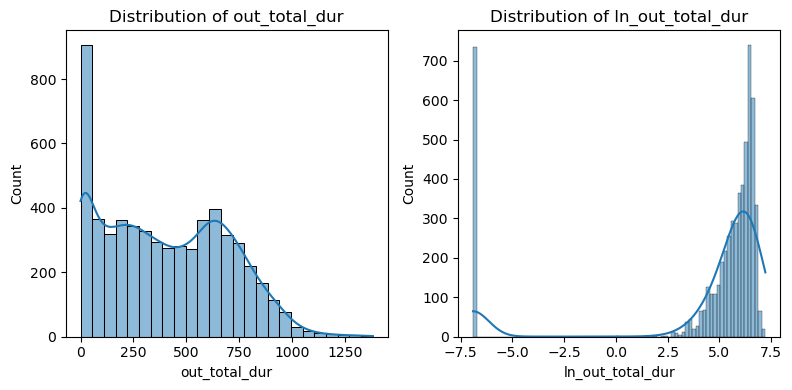

                            OLS Regression Results                            
Dep. Variable:       ln_out_total_dur   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     35.42
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           1.54e-86
Time:                        19:34:39   Log-Likelihood:                -16394.
No. Observations:                5759   AIC:                         3.282e+04
Df Residuals:                    5745   BIC:                         3.291e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

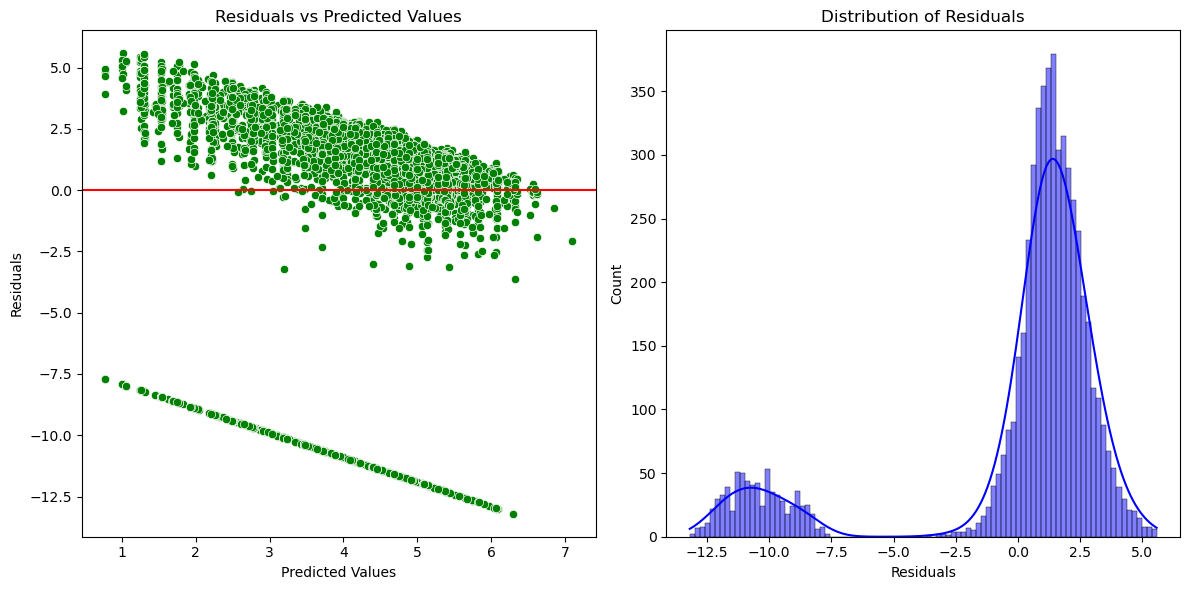

Breusch-Pagan test encountered an error: name 'bp_statistic' is not defined
Shapiro-Wilk statistic: 0.6698932647705078
Shapiro-Wilk p-value: 0.0
Kolmogorov-Smirnov test on residuals:
Statistic: 0.4311997928744196
p-value: 0.0


In [100]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# plot original and transofrmed vars
plot_dual_histogram(df, 'out_total_dur', 'ln_out_total_dur')

# Add a constant column manually
df['const'] = 1

# interaction term
df['inter_age_65p_inc_75_100'] = df.age_65p * df.inc_75_100

# Define the dependent variable (Y) and the independent variable(s) (X)
Y = df['ln_out_total_dur']
X = df[['const', 
        'temp', 'age_50_64', 'age_65p', 'inter_age_65p_inc_75_100', 'black', 'hhsize_1', 'female',
         'los_angeles',
        'bachelor',
 'grad_sch', 'inc_up35',
 'inc_100p', 'weekday']]

# Fit the linear regression model
model = sm.OLS(Y, X).fit()

# Print the model summary table
print(model.summary())

# plot residuals
# Predicted values
Y_pred = model.predict(X)
residuals = model.resid

plot_residuals(Y_pred, residuals)

# check assumptions
perform_residual_tests(Y_pred, residuals)

<b> Model 2: Zero-trip makers and out-of-home duration

In [101]:
# # correlation matrix
# df['zero_outhome_dur'] = (df['out_total_dur'] == 0).astype(int)

# ref_var = 'zero_outhome_dur'

# # Find the index of the 'temp' variable in the columns list
# temp_index = df.columns.get_loc('temp')

# # Get all variables after 'temp'
# variables_after_temp = df.columns[temp_index:].tolist()

# # variables_after_temp.insert(0, ref_var)

# correlation_matrix = df[variables_after_temp].corr()

# correlation_matrix[[ref_var]].sort_values(by=ref_var, ascending=False).to_csv('cor.csv')

# correlation_matrix[[ref_var]].sort_values(by=ref_var, ascending=False).head(5)

In [102]:
import statsmodels.api as sm

# Part 1: Logistic regression for zero vs non-zero
df['zero_outhome_dur'] = (df['traveling'] == 0).astype(int)
logit_model = sm.Logit(df['zero_outhome_dur'], df[['const', 'temp', 'temp_x_inc_up35',
                                                  'age_50_64', 'age_65p', 'nonworker', 
                                                  'black', 
                                                      'grad_sch',  'weekday',
                                                   'inc_up35', 'inc_100p', 'inc_up35_x_phoenix', 'child_present_x_houston', 
                                                        'hhsize_2_x_dallas',]]).fit()

print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.372907
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:       zero_outhome_dur   No. Observations:                 5759
Model:                          Logit   Df Residuals:                     5745
Method:                           MLE   Df Model:                           13
Date:                Sat, 31 Aug 2024   Pseudo R-squ.:                  0.1070
Time:                        19:34:40   Log-Likelihood:                -2147.6
converged:                       True   LL-Null:                       -2405.0
Covariance Type:            nonrobust   LLR p-value:                1.062e-101
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -2.6285      0.107    -24.573      0.000      -2.838   

In [103]:
# Get the model summary as a pandas DataFrame
results = logit_model

summary_df = pd.DataFrame(results.summary2().tables[1])
summary_df

Coef.  Std.Err.          z          P>|z|  \
const                   -2.628452  0.106965 -24.572973  2.457695e-133   
temp                     0.354983  0.104218   3.406158   6.588395e-04   
temp_x_inc_up35         -0.407322  0.162675  -2.503903   1.228317e-02   
age_50_64                0.338299  0.098123   3.447708   5.653654e-04   
age_65p                  0.475339  0.101642   4.676587   2.916884e-06   
nonworker                1.176398  0.090041  13.065150   5.208156e-39   
black                    0.183180  0.093450   1.960197   4.997282e-02   
grad_sch                -0.335309  0.132057  -2.539130   1.111287e-02   
weekday                 -0.350471  0.078869  -4.443713   8.841954e-06   
inc_up35                 0.541373  0.115347   4.693415   2.686816e-06   
inc_100p                -0.254687  0.117126  -2.174479   2.966916e-02   
inc_up35_x_phoenix       0.510774  0.241224   2.117429   3.422349e-02   
child_present_x_houston -0.802110  0.338571  -2.369102   1.783133e-02   
hhsize_2_x_dallas        0.544430  0.216212   2.518035   1.180115e-02   

                           [0.025    0.975]  
const                   -2.838099 -2.418804  
temp                     0.150719  0.559246  
temp_x_inc_up35         -0.726158 -0.088485  
age_50_64                0.145982  0.530617  
age_65p                  0.276124  0.674554  
nonworker                0.999921  1.352875  
black                    0.000022  0.366339  
grad_sch                -0.594136 -0.076483  
weekday                 -0.505052 -0.195891  
inc_up35                 0.315296  0.767450  
inc_100p                -0.484249 -0.025125  
inc_up35_x_phoenix       0.037984  0.983564  
child_present_x_houston -1.465697 -0.138522  
hhsize_2_x_dallas        0.120662  0.968199

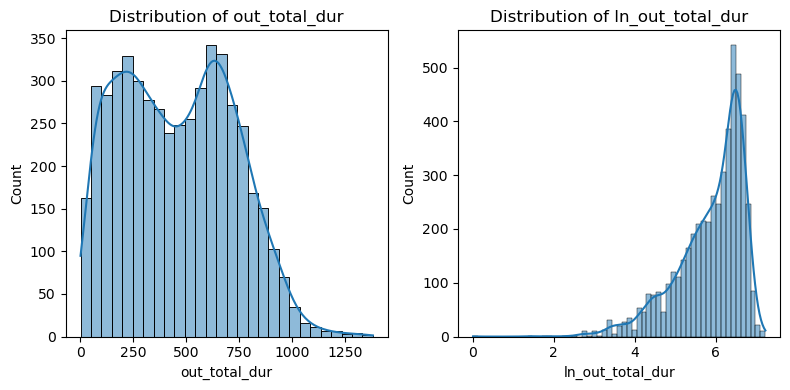

Optimization terminated successfully.
         Current function value: 0.355279
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:       zero_outhome_dur   No. Observations:                 5759
Model:                          Logit   Df Residuals:                     5748
Method:                           MLE   Df Model:                           10
Date:                Sat, 31 Aug 2024   Pseudo R-squ.:                 0.06877
Time:                        19:34:41   Log-Likelihood:                -2046.1
converged:                       True   LL-Null:                       -2197.1
Covariance Type:            nonrobust   LLR p-value:                 5.340e-59
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.3027      0.103    -22.296      0.000      -2.505      -2.100
temp           0.1423      0.

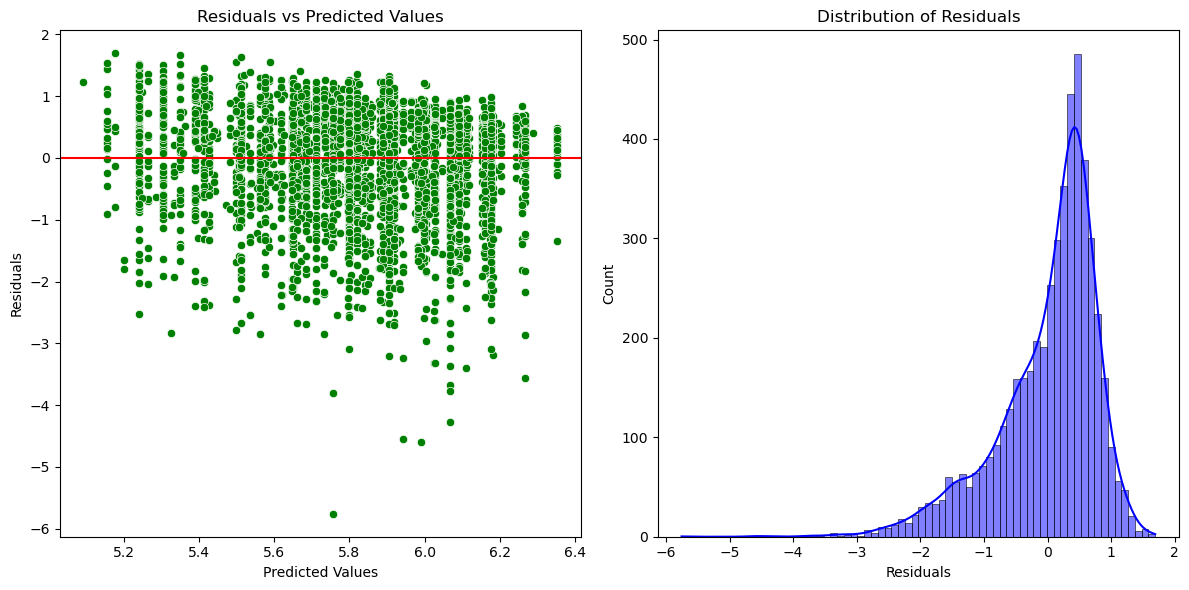

Breusch-Pagan test encountered an error: name 'bp_statistic' is not defined
Shapiro-Wilk statistic: 0.9075757265090942
Shapiro-Wilk p-value: 0.0
Kolmogorov-Smirnov test on residuals:
Statistic: 0.126890615856723
p-value: 5.460402464702309e-71


In [104]:
import statsmodels.api as sm

df_non_zero = df[df['out_total_dur'] > 0]

# plot original and transofrmed vars
plot_dual_histogram(df_non_zero, 'out_total_dur', 'ln_out_total_dur')


# Part 1: Logistic regression for zero vs non-zero
df['zero_outhome_dur'] = (df['out_total_dur'] == 0).astype(int)
logit_model = sm.Logit(df['zero_outhome_dur'], df[['const', 
                                                      'temp', 'age_50_64', 'age_65p', 
                                                      'black', 
                                                      'dallas',
                                                      'bachelor',
                                                      'grad_sch', 'inc_up35',
                                                      'inc_100p', 'weekday']]).fit()

# Part 2: OLS regression for non-zero outcomes
ols_model = sm.OLS(df_non_zero['ln_out_total_dur'], df_non_zero[['const', 
                                                                   'temp', 'age_50_64', 'age_65p', 
                                                                   'hhsize_1', 'female',
                                                                   'houston',
                                                                   'grad_sch', 'inc_up35',
                                                                   'weekday']]).fit()

# Print the model summary tables
print(logit_model.summary())
print(ols_model.summary())

# plot residuals
# Predicted values




# plot residuals
# Predicted values
Y_pred = ols_model.predict(df_non_zero[['const', 'temp', 'age_50_64', 'age_65p', 
                                                                   'hhsize_1', 'female',
                                                                   'houston',
                                                                   'grad_sch', 'inc_up35',
                                                                   'weekday']])

residuals = ols_model.resid

plot_residuals(Y_pred, residuals)

# check assumptions
perform_residual_tests(Y_pred, residuals)

Interpreting the VIF values:

    VIF = 1: There is no multicollinearity between the predictor variable and the other variables. The variable has no linear relationship with the other predictors in the model.

    VIF > 1 and VIF < 5: There is a low to moderate level of multicollinearity. The variable is somewhat correlated with the other predictors, but it does not excessively inflate the variance of its coefficient.

    VIF >= 5: There is a high degree of multicollinearity. The variable is strongly correlated with one or more other predictors, and its coefficient estimates may be unreliable.

In [105]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each predictor
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Print the VIF values
print(vif)

                    Variable       VIF
0                      const  7.289628
1                       temp  1.038506
2                  age_50_64  1.117971
3                    age_65p  1.300683
4   inter_age_65p_inc_75_100  1.115328
5                      black  1.045391
6                   hhsize_1  1.198662
7                     female  1.010778
8                los_angeles  1.032105
9                   bachelor  1.181654
10                  grad_sch  1.225739
11                  inc_up35  1.288833
12                  inc_100p  1.320266
13                   weekday  1.002551


<b> Model 3: Out of traveling duration

In [106]:
# # correlation matrix
# df_non_zero = df[df['out_traveling_dur'] > 0]

# ref_var = 'ln_out_traveling_dur'

# # Find the index of the 'temp' variable in the columns list
# temp_index = df_non_zero.columns.get_loc('temp')

# # Get all variables after 'temp'
# variables_after_temp = df_non_zero.columns[temp_index:].tolist()

# # variables_after_temp.insert(0, ref_var)

# correlation_matrix = df_non_zero[variables_after_temp].corr()

# correlation_matrix[[ref_var]].sort_values(by=ref_var, ascending=False).to_csv('cor.csv')

# correlation_matrix[[ref_var]].sort_values(by=ref_var, ascending=False).head(5)

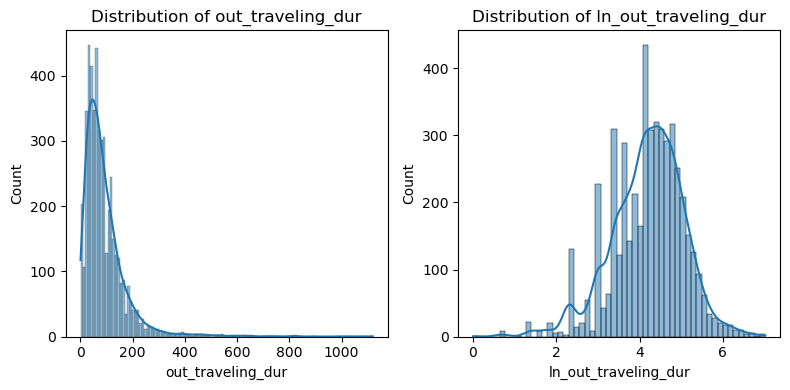

                             OLS Regression Results                             
Dep. Variable:     ln_out_traveling_dur   R-squared:                       0.038
Model:                              OLS   Adj. R-squared:                  0.036
Method:                   Least Squares   F-statistic:                     17.55
Date:                  Sat, 31 Aug 2024   Prob (F-statistic):           1.09e-34
Time:                          19:34:42   Log-Likelihood:                -6135.1
No. Observations:                  4904   AIC:                         1.229e+04
Df Residuals:                      4892   BIC:                         1.237e+04
Df Model:                            11                                         
Covariance Type:              nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
cons

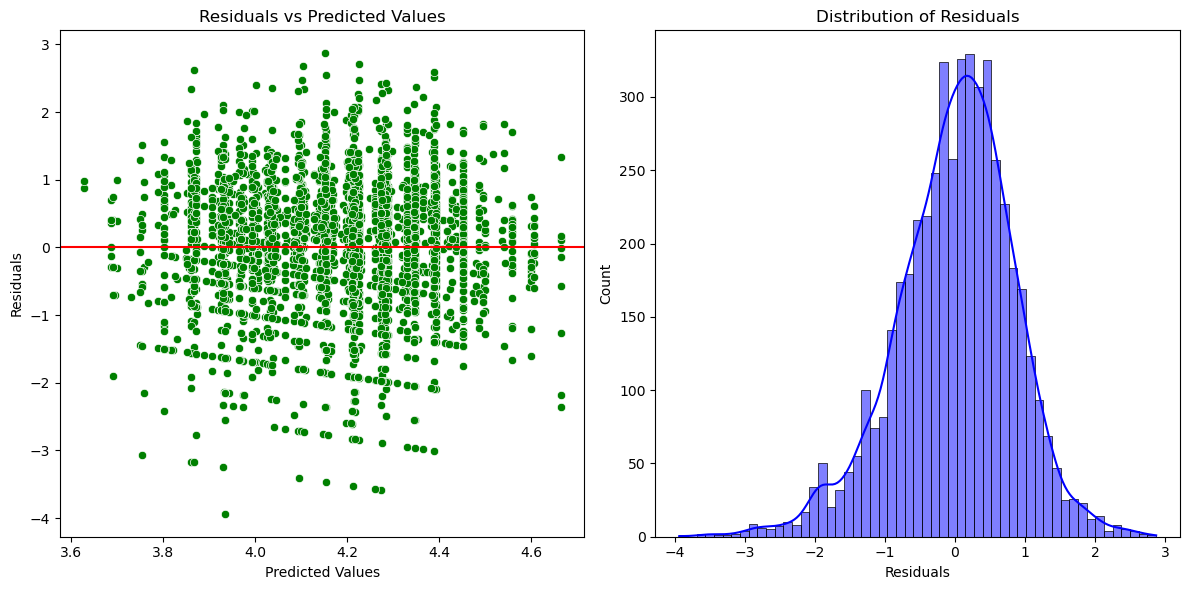

Breusch-Pagan test encountered an error: name 'bp_statistic' is not defined
Shapiro-Wilk statistic: 0.986260175704956
Shapiro-Wilk p-value: 1.8692217931134878e-21
Kolmogorov-Smirnov test on residuals:
Statistic: 0.06576388935763733
p-value: 6.965112078588815e-19


In [107]:
import statsmodels.api as sm

df_non_zero = df[df['out_traveling_dur'] > 0]

# plot original and transofrmed vars
plot_dual_histogram(df_non_zero, 'out_traveling_dur', 'ln_out_traveling_dur')

# Add a constant column manually
df_non_zero['const'] = 1

# interaction term
df_non_zero['inter_female_inc75100'] = df_non_zero.female * df.inc_75_100

# Define the dependent variable (Y) and the independent variable(s) (X)
Y = df_non_zero['ln_out_traveling_dur']
X = df_non_zero[['const', 
                  'temp',
                  'age_65p',
                 'female', 
                 'male_x_washington',
                 'male_x_worker',
       'worker', 'white_x_nonworker', 'nonworker_x_philadelphia',
        'bachelor',
 'grad_sch', 
 'weekday']]

# Fit the linear regression model
model = sm.OLS(Y, X).fit()

# Print the model summary table
print(model.summary())

# plot residuals
# Predicted values
Y_pred = model.predict(X)
residuals = model.resid

plot_residuals(Y_pred, residuals)

# check assumptions
perform_residual_tests(Y_pred, residuals)

In [108]:
# Get the model summary as a pandas DataFrame
results = model

summary_df = pd.DataFrame(results.summary2().tables[1])
summary_df

Coef.  Std.Err.          t         P>|t|  \
const                     4.196475  0.054234  77.376491  0.000000e+00   
temp                     -0.058647  0.024613  -2.382822  1.721848e-02   
age_65p                  -0.068269  0.036514  -1.869664  6.159022e-02   
female                   -0.102218  0.044626  -2.290564  2.203096e-02   
male_x_washington         0.212188  0.060356   3.515594  4.427490e-04   
male_x_worker            -0.103439  0.053231  -1.943201  5.204912e-02   
worker                    0.118021  0.050346   2.344194  1.910806e-02   
white_x_nonworker        -0.163961  0.047923  -3.421308  6.283109e-04   
nonworker_x_philadelphia -0.175391  0.072230  -2.428218  1.520903e-02   
bachelor                  0.071571  0.029167   2.453858  1.416792e-02   
grad_sch                  0.176567  0.033633   5.249885  1.586341e-07   
weekday                   0.063473  0.024229   2.619746  8.826709e-03   

                            [0.025    0.975]  
const                     4.090151  4.302799  
temp                     -0.106899 -0.010396  
age_65p                  -0.139853  0.003315  
female                   -0.189704 -0.014732  
male_x_washington         0.093863  0.330514  
male_x_worker            -0.207796  0.000918  
worker                    0.019320  0.216722  
white_x_nonworker        -0.257912 -0.070009  
nonworker_x_philadelphia -0.316995 -0.033787  
bachelor                  0.014391  0.128750  
grad_sch                  0.110632  0.242502  
weekday                   0.015974  0.110972

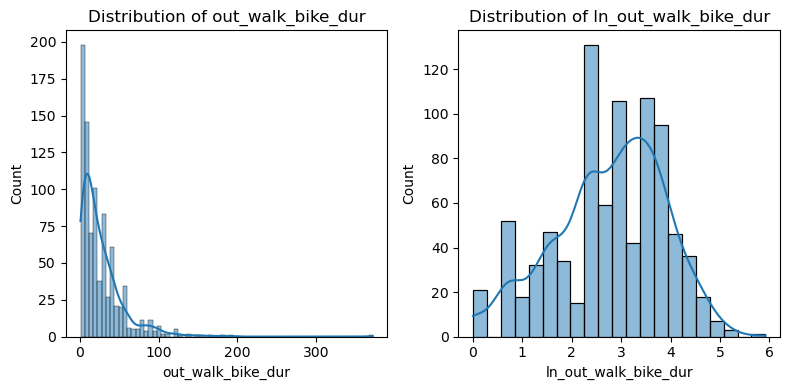

                             OLS Regression Results                             
Dep. Variable:     ln_out_walk_bike_dur   R-squared:                       0.072
Model:                              OLS   Adj. R-squared:                  0.063
Method:                   Least Squares   F-statistic:                     7.465
Date:                  Sat, 31 Aug 2024   Prob (F-statistic):           1.47e-10
Time:                          19:34:43   Log-Likelihood:                -1295.1
No. Observations:                   870   AIC:                             2610.
Df Residuals:                       860   BIC:                             2658.
Df Model:                             9                                         
Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.2579     

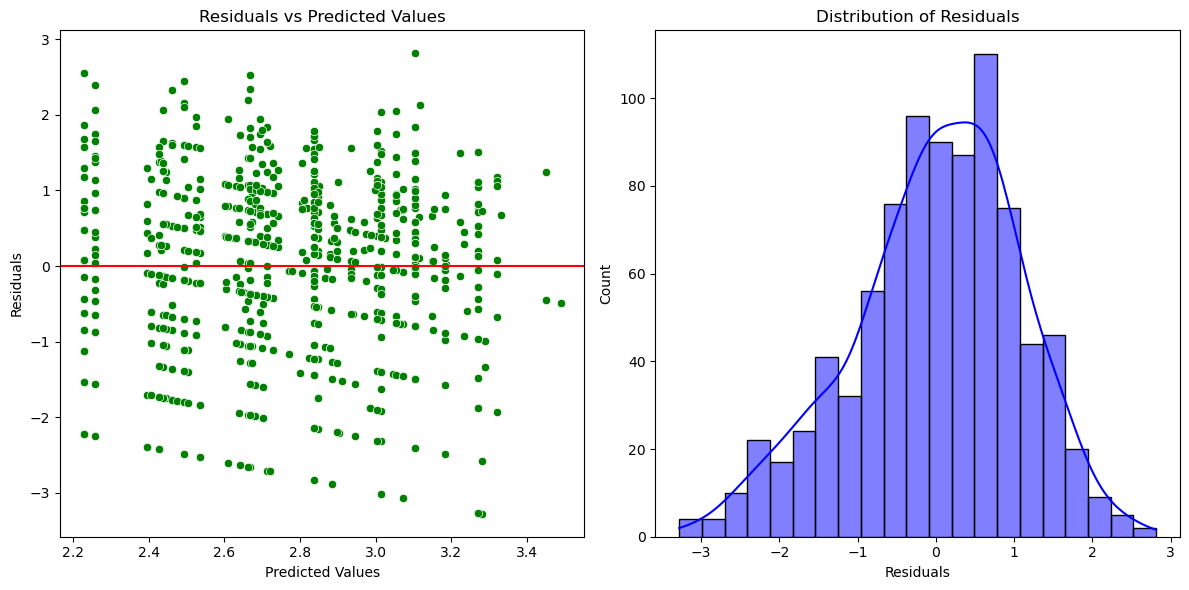

Breusch-Pagan test encountered an error: name 'bp_statistic' is not defined
Shapiro-Wilk statistic: 0.9867498278617859
Shapiro-Wilk p-value: 4.430854971815279e-07
Kolmogorov-Smirnov test on residuals:
Statistic: 0.049793149769828404
p-value: 0.025850366605080333


In [109]:
import statsmodels.api as sm

df_non_zero = df[df['out_walk_bike_dur'] > 0]

# plot original and transofrmed vars
plot_dual_histogram(df_non_zero, 'out_walk_bike_dur', 'ln_out_walk_bike_dur')

# Add a constant column manually
df_non_zero['const'] = 1

# interaction term
df_non_zero['i_age_65p_temp'] = df_non_zero.age_65p * df_non_zero.white  * df_non_zero.temp


# Define the dependent variable (Y) and the independent variable(s) (X)
Y = df_non_zero['ln_out_walk_bike_dur']
X = df_non_zero[['const', 'temp',
         'age_20_29',
         'new_york', 'chicago', 'washington', 'philadelphia', 'hhsize_1',
 'grad_sch', 'inc_up35']]

# Fit the linear regression model
model = sm.OLS(Y, X).fit()

# Print the model summary table
print(model.summary())

# plot residuals
# Predicted values
Y_pred = model.predict(X)
residuals = model.resid

plot_residuals(Y_pred, residuals)

# check assumptions
perform_residual_tests(Y_pred, residuals)

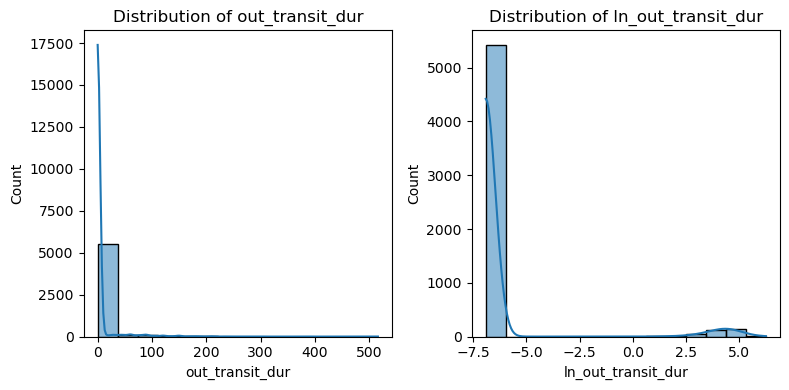

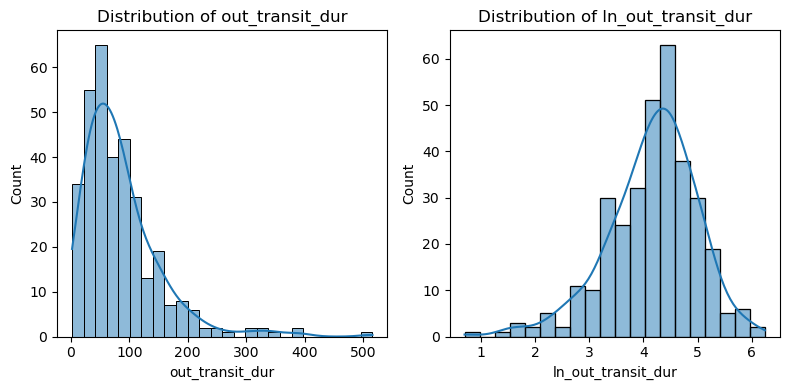

                            OLS Regression Results                            
Dep. Variable:     ln_out_transit_dur   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.701
Date:                Sat, 31 Aug 2024   Prob (F-statistic):             0.0541
Time:                        19:34:45   Log-Likelihood:                -400.78
No. Observations:                 335   AIC:                             831.6
Df Residuals:                     320   BIC:                             888.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.0710      0.184     22.174   

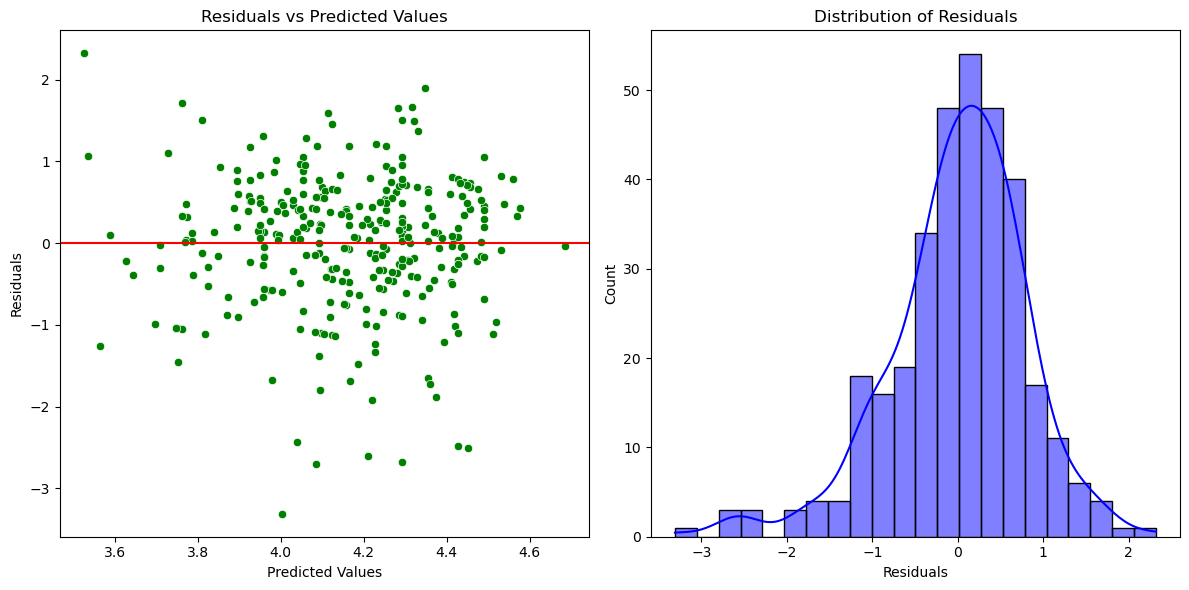

Breusch-Pagan test encountered an error: name 'bp_statistic' is not defined
Shapiro-Wilk statistic: 0.963898777961731
Shapiro-Wilk p-value: 2.262928120444485e-07
Kolmogorov-Smirnov test on residuals:
Statistic: 0.10422165257775251
p-value: 0.0012722055471881474


In [110]:
import statsmodels.api as sm

# plot original and transofrmed vars
plot_dual_histogram(df, 'out_transit_dur', 'ln_out_transit_dur')

df_non_zero = df[df['out_transit_dur'] > 0]

# plot original and transofrmed vars
plot_dual_histogram(df_non_zero, 'out_transit_dur', 'ln_out_transit_dur')

# Add a constant column manually
df_non_zero['const'] = 1

# interaction term
df_non_zero['inter_temp_black'] = df_non_zero.temp * df_non_zero.black

# Define the dependent variable (Y) and the independent variable(s) (X)
Y = df_non_zero['ln_out_transit_dur']
X = df_non_zero[['const', 'temp',
        'age_15_19', 'age_65p',
         'new_york', 'chicago', 'washington', 'philadelphia',
        'hhsize_1', 'student', 'worker', 'black',
 'grad_sch', 'inc_up35', 'weekday']]

# Fit the linear regression model
model = sm.OLS(Y, X).fit()

# Print the model summary table
print(model.summary())

# plot residuals
# Predicted values
Y_pred = model.predict(X)
residuals = model.resid

plot_residuals(Y_pred, residuals)

# check assumptions
perform_residual_tests(Y_pred, residuals)

In [111]:
# fit a poisson and compare it to the negative binomial
# import statsmodels.api as sm
# import pandas as pd

# # Assuming you have a Pandas DataFrame called 'df' with activity frequency data

# # Specify the predictor variables (X) and the response variable (y)
# y = df['out_traveling']
# X = df[['const', 'temp',  'age_50_64', 'age_65p', 'black',  'female',
#          'inc_100p', 'inc_up35', 'nonworker', 'weekday']]

# # Fit a Poisson regression model
# model = sm.GLM(y, X, family=sm.families.Poisson())
# result = model.fit()

# # Print the model summary
# print(result.summary())


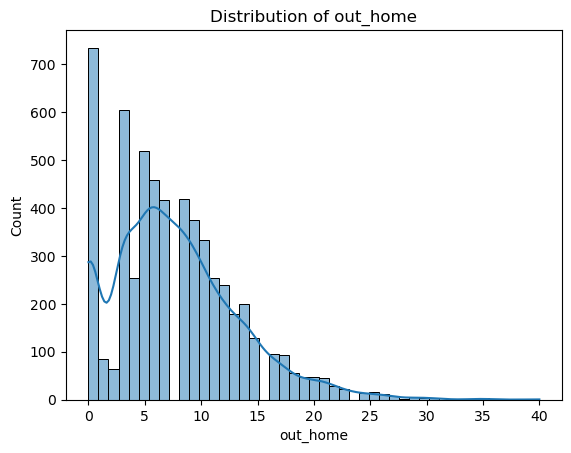

                 Generalized Linear Model Regression Results                  
Dep. Variable:               out_home   No. Observations:                 5759
Model:                            GLM   Df Residuals:                     5747
Model Family:        NegativeBinomial   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17680.
Date:                Sat, 31 Aug 2024   Deviance:                       4513.0
Time:                        19:34:46   Pearson chi2:                 2.80e+03
No. Iterations:                     7   Pseudo R-squ. (CS):            0.04728
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0549      0.048     43.078      0.0

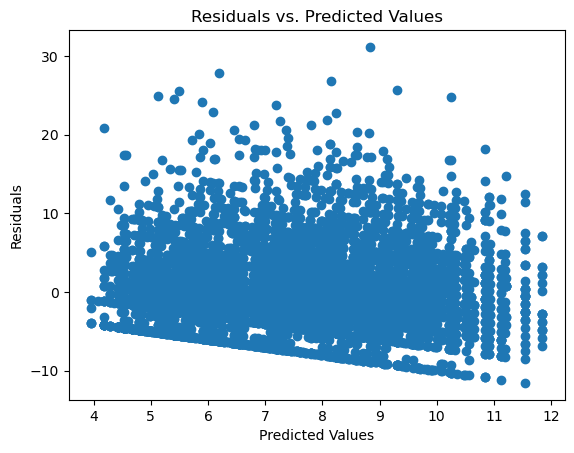

In [112]:
import statsmodels.api as sm
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'car_trip_proportion' is your column of interest
sns.histplot(df['out_home'], kde=True)
plt.title('Distribution of out_home')
plt.show()

# Specify the predictor variables (X) and the response variable (y)
y = df['out_home']
X = df[['const', 'temp',  'age_50_64', 'age_65p',  'female',  'white',  'bachelor', 
 'grad_sch', 'hhsize_3p',
 'inc_up35', 'nonworker', 'weekday']]

# Fit a negative binomial regression model
model = sm.GLM(y, X, family=sm.families.NegativeBinomial())
result = model.fit()

# Print the model summary
print(result.summary())


print("Dispersion parameter:", result.pearson_chi2 / result.df_resid)
print("Deviance (negative binomial):", result.deviance)

# Fit a Poisson model
poisson_model = sm.GLM(y, X, family=sm.families.Poisson())
poisson_result = poisson_model.fit()
print("Deviance (Poisson):", poisson_result.deviance)
print("for poisson to be more appropriate dispersion param needs to 1. and deviance smaller is better.")
residuals = result.resid_response
predicted = result.predict(X)

# Plot residuals against predicted values
import matplotlib.pyplot as plt

plt.scatter(predicted, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()


<b> Model 4: Number of trips 

In [113]:
# # correlation matrix
# ref_var = 'traveling'

# # Find the index of the 'temp' variable in the columns list
# temp_index = df.columns.get_loc('temp')

# # Get all variables after 'temp'
# variables_after_temp = df.columns[temp_index:].tolist()

# variables_after_temp.insert(0, ref_var)

# correlation_matrix = df[variables_after_temp].corr()

# correlation_matrix[[ref_var]].sort_values(by=ref_var, ascending=False).to_csv('cor.csv')

# correlation_matrix[[ref_var]].sort_values(by=ref_var, ascending=False).head(5)

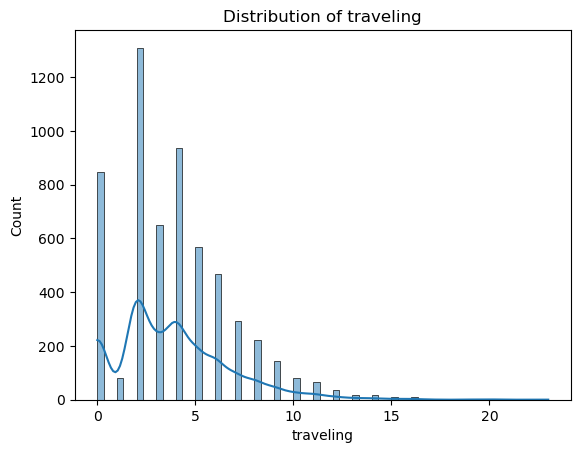

                 Generalized Linear Model Regression Results                  
Dep. Variable:              traveling   No. Observations:                 5759
Model:                            GLM   Df Residuals:                     5748
Model Family:        NegativeBinomial   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13913.
Date:                Sat, 31 Aug 2024   Deviance:                       3438.7
Time:                        19:34:46   Pearson chi2:                 3.53e+03
No. Iterations:                     9   Pseudo R-squ. (CS):            0.09173
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.0808 

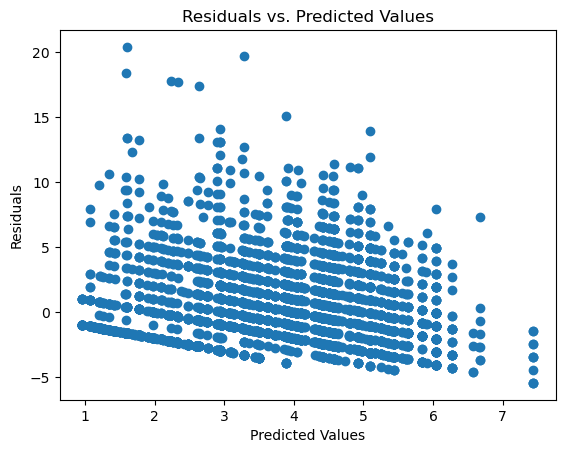

In [114]:
import statsmodels.api as sm
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'car_trip_proportion' is your column of interest
sns.histplot(df['traveling'], kde=True)
plt.title('Distribution of traveling')
plt.show()

# Specify the predictor variables (X) and the response variable (y)
y = df['traveling']
X = df[['const', 'temp', 
          'age_50_64', 'age_65p', 'grad_sch', 
 'nonworker', 'weekday', 
'car_user', 'temp_x_car_user', 'temp_x_washington', 'inc_up35_x_nonworker'
]]

# Fit a negative binomial regression model
model = sm.GLM(y, X, family=sm.families.NegativeBinomial())
result = model.fit()

# Print the model summary
print(result.summary())

# extra tests
print("Dispersion parameter:", result.pearson_chi2 / result.df_resid)
print("Deviance (negative binomial):", result.deviance)

# Fit a Poisson model
poisson_model = sm.GLM(y, X, family=sm.families.Poisson())
poisson_result = poisson_model.fit()
print("Deviance (Poisson):", poisson_result.deviance)
print("for poisson to be more appropriate dispersion param needs to 1. and deviance smaller is better.")
residuals = result.resid_response
predicted = result.predict(X)

# Plot residuals against predicted values
import matplotlib.pyplot as plt

plt.scatter(predicted, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()


In [115]:
# Get the summary table as a pandas DataFrame
summary_df = result.summary().tables[1].as_html()
summary_df = pd.read_html(summary_df, header=0, index_col=0)[0]

# Convert all columns to numeric (some columns may contain strings like '--' for missing values)
summary_df = summary_df.apply(pd.to_numeric, errors='coerce')

# Now, summary_df contains the coefficients, standard errors, z-values, and p-values
summary_df

coef  std err       z  P>|z|  [0.025  0.975]
const                 1.0808    0.047  23.088  0.000   0.989   1.173
temp                 -0.6096    0.067  -9.075  0.000  -0.741  -0.478
age_50_64            -0.1229    0.036  -3.387  0.001  -0.194  -0.052
age_65p              -0.2322    0.045  -5.123  0.000  -0.321  -0.143
grad_sch              0.1706    0.040   4.219  0.000   0.091   0.250
nonworker            -0.1107    0.041  -2.712  0.007  -0.191  -0.031
weekday               0.1074    0.030   3.585  0.000   0.049   0.166
car_user              0.4412    0.046   9.673  0.000   0.352   0.531
temp_x_car_user       0.5751    0.075   7.689  0.000   0.429   0.722
temp_x_washington     0.2414    0.078   3.084  0.002   0.088   0.395
inc_up35_x_nonworker -0.1665    0.052  -3.207  0.001  -0.268  -0.065

<b> Model 5: Number of transit trips 

In [116]:
# # correlation matrix
# ref_var = 'out_transit'

# # Find the index of the 'temp' variable in the columns list
# temp_index = df.columns.get_loc('temp')

# # Get all variables after 'temp'
# variables_after_temp = df.columns[temp_index:].tolist()

# variables_after_temp.insert(0, ref_var)

# correlation_matrix = df[variables_after_temp].corr()

# correlation_matrix[[ref_var]].sort_values(by=ref_var, ascending=False).to_csv('cor.csv')

# correlation_matrix[[ref_var]].sort_values(by=ref_var, ascending=False).head(5)

In [117]:
# Group the DataFrame by 'city' and 'temp', calculate the average and count of 'out_transit' for each city and temp
result = df.groupby(['city', 'temp'])['out_transit'].agg(['mean', 'count']).reset_index()

# Rename the columns to be more descriptive
result.rename(columns={'mean': 'average_out_transit', 'count': 'sample_size'}, inplace=True)

print(result)

            city  temp  average_out_transit  sample_size
0        atlanta     0             0.080214          187
1        atlanta     1             0.038136          236
2        chicago     0             0.126866          670
3        chicago     1             0.141732          127
4         dallas     0             0.000000           67
5         dallas     1             0.052192          479
6        houston     0             0.088235           34
7        houston     1             0.021429          420
8    los_angeles     0             0.050000          200
9    los_angeles     1             0.000000            1
10         miami     0             0.250000           32
11         miami     1             0.023585          424
12      new_york     0             0.347041          997
13      new_york     1             0.310924          119
14  philadelphia     0             0.105263          380
15  philadelphia     1             0.261438          153
16       phoenix     0         

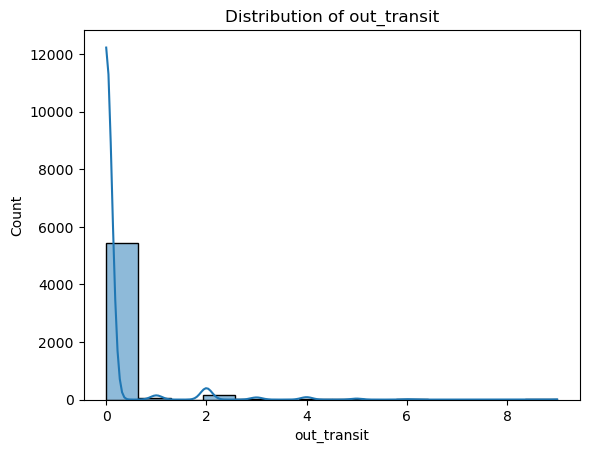

                 Generalized Linear Model Regression Results                  
Dep. Variable:            out_transit   No. Observations:                 5759
Model:                            GLM   Df Residuals:                     5745
Model Family:        NegativeBinomial   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2116.5
Date:                Sat, 31 Aug 2024   Deviance:                       2911.9
Time:                        19:34:47   Pearson chi2:                 1.29e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1052
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.8327      0.140    -

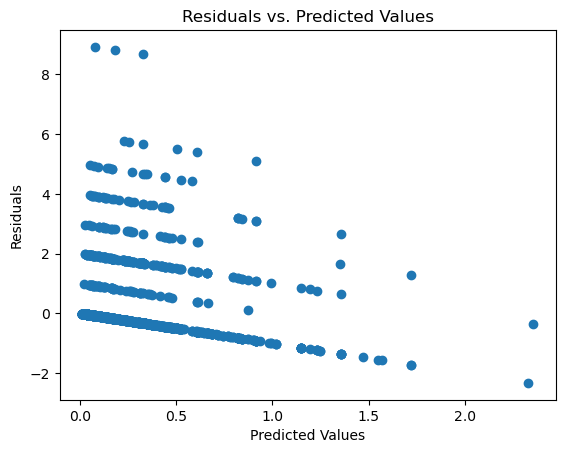

In [118]:
import statsmodels.api as sm
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'car_trip_proportion' is your column of interest
sns.histplot(df['out_transit'], kde=True)
plt.title('Distribution of out_transit')
plt.show()

# Assuming you have a Pandas DataFrame called 'df' with activity frequency data
df['inter_age_65p_newyork'] = df.new_york * df.age_65p


# Specify the predictor variables (X) and the response variable (y)
y = df['out_transit']
X = df[['const', 'temp', 'temp_x_grad_sch', 
        'female_x_black', 
    'age_65p', 'white', 'less_than_hs', 'grad_sch', 'new_york', 'washington', 'chicago',
 'inc_up35', 'nonworker', 'weekday']]

# Fit a negative binomial regression model
model = sm.GLM(y, X, family=sm.families.NegativeBinomial())
result = model.fit()

# Print the model summary
print(result.summary())

# extra tests
print("Dispersion parameter:", result.pearson_chi2 / result.df_resid)
print("Deviance (negative binomial):", result.deviance)

# Fit a Poisson model
poisson_model = sm.GLM(y, X, family=sm.families.Poisson())
poisson_result = poisson_model.fit()
print("Deviance (Poisson):", poisson_result.deviance)
print("for poisson to be more appropriate dispersion param needs to 1. and deviance smaller is better.")
residuals = result.resid_response
predicted = result.predict(X)

# Plot residuals against predicted values
import matplotlib.pyplot as plt

plt.scatter(predicted, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()


In [119]:
# Get the summary table as a pandas DataFrame
summary_df = result.summary().tables[1].as_html()
summary_df = pd.read_html(summary_df, header=0, index_col=0)[0]

# Convert all columns to numeric (some columns may contain strings like '--' for missing values)
summary_df = summary_df.apply(pd.to_numeric, errors='coerce')

# Now, summary_df contains the coefficients, standard errors, z-values, and p-values
summary_df

coef  std err       z  P>|z|  [0.025  0.975]
const           -2.8327    0.140 -20.275  0.000  -3.107  -2.559
temp            -0.2428    0.110  -2.206  0.027  -0.458  -0.027
temp_x_grad_sch  0.4178    0.217   1.924  0.054  -0.008   0.843
female_x_black   0.4061    0.121   3.370  0.001   0.170   0.642
age_65p         -0.2862    0.129  -2.221  0.026  -0.539  -0.034
white           -0.6226    0.101  -6.178  0.000  -0.820  -0.425
less_than_hs     0.3147    0.117   2.688  0.007   0.085   0.544
grad_sch         0.3026    0.122   2.490  0.013   0.064   0.541
new_york         1.6547    0.107  15.471  0.000   1.445   1.864
washington       1.0072    0.134   7.504  0.000   0.744   1.270
chicago          0.7018    0.137   5.121  0.000   0.433   0.970
inc_up35         0.6347    0.093   6.816  0.000   0.452   0.817
nonworker       -0.5523    0.101  -5.458  0.000  -0.751  -0.354
weekday          0.6799    0.083   8.239  0.000   0.518   0.842

for ordered models:
https://www.statsmodels.org/dev/examples/notebooks/generated/ordinal_regression.html

<b> Model 6: walk bike trips #

In [120]:
# # correlation matrix
# ref_var = 'out_walk_bike'

# # Find the index of the 'temp' variable in the columns list
# temp_index = df.columns.get_loc('temp')

# # Get all variables after 'temp'
# variables_after_temp = df.columns[temp_index:].tolist()

# variables_after_temp.insert(0, ref_var)

# correlation_matrix = df[variables_after_temp].corr()

# correlation_matrix[[ref_var]].sort_values(by=ref_var, ascending=False).to_csv('cor.csv')

# correlation_matrix[[ref_var]].sort_values(by=ref_var, ascending=False).head(5)

In [121]:
# Group the DataFrame by 'city' and 'temp', calculate the average and count of 'out_transit' for each city and temp
result = df.groupby(['city', 'temp'])['out_walk_bike'].agg(['mean', 'count']).reset_index()

# Rename the columns to be more descriptive
result.rename(columns={'mean': 'average_out_walk_bike', 'count': 'sample_size'}, inplace=True)

print(result)

            city  temp  average_out_walk_bike  sample_size
0        atlanta     0               0.267380          187
1        atlanta     1               0.161017          236
2        chicago     0               0.437313          670
3        chicago     1               0.267717          127
4         dallas     0               0.044776           67
5         dallas     1               0.158664          479
6        houston     0               0.294118           34
7        houston     1               0.128571          420
8    los_angeles     0               0.340000          200
9    los_angeles     1               0.000000            1
10         miami     0               0.218750           32
11         miami     1               0.172170          424
12      new_york     0               0.835507          997
13      new_york     1               0.512605          119
14  philadelphia     0               0.405263          380
15  philadelphia     1               0.470588          1

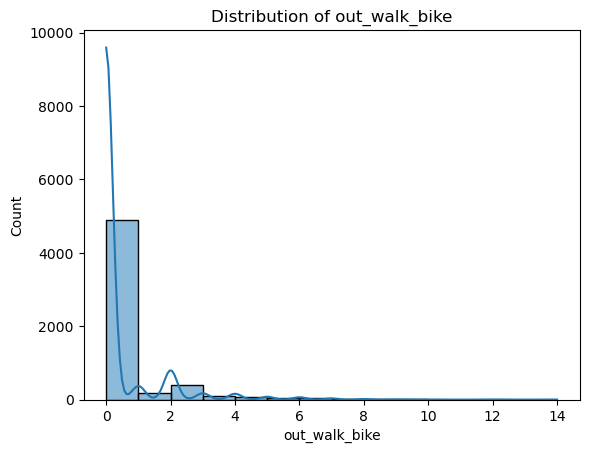

                 Generalized Linear Model Regression Results                  
Dep. Variable:          out_walk_bike   No. Observations:                 5759
Model:                            GLM   Df Residuals:                     5745
Model Family:        NegativeBinomial   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4415.5
Date:                Sat, 31 Aug 2024   Deviance:                       5344.2
Time:                        19:34:48   Pearson chi2:                 1.20e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1143
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.6464      0.076    -21.

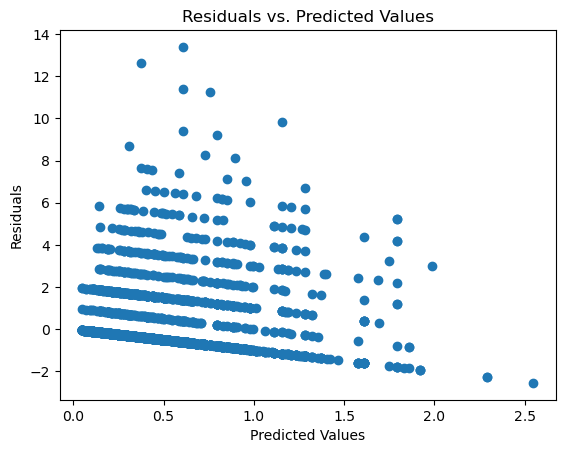

In [122]:
import statsmodels.api as sm
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'car_trip_proportion' is your column of interest
sns.histplot(df['out_walk_bike'], kde=True)
plt.title('Distribution of out_walk_bike')
plt.show()

# Assuming you have a Pandas DataFrame called 'df' with activity frequency data
df['inter_age_65p_newyork'] = df.new_york * df.age_65p


# Specify the predictor variables (X) and the response variable (y)
y = df['out_walk_bike']
X = df[['const', 'temp',
        'temp_x_age_65p', 'philadelphia', 'washington', 'chicago',
         'new_york', 'male_x_student',
        'hhsize_1',
        'age_50_64', 'age_65p', 'grad_sch', 
 'inc_up35', 'weekday']]

# Fit a negative binomial regression model
model = sm.GLM(y, X, family=sm.families.NegativeBinomial())
result = model.fit()

# Print the model summary
print(result.summary())

# extra tests
print("Dispersion parameter:", result.pearson_chi2 / result.df_resid)
print("Deviance (negative binomial):", result.deviance)

# Fit a Poisson model
poisson_model = sm.GLM(y, X, family=sm.families.Poisson())
poisson_result = poisson_model.fit()
print("Deviance (Poisson):", poisson_result.deviance)
print("for poisson to be more appropriate dispersion param needs to 1. and deviance smaller is better.")
residuals = result.resid_response
predicted = result.predict(X)

# Plot residuals against predicted values
import matplotlib.pyplot as plt

plt.scatter(predicted, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()


In [123]:
# Get the summary table as a pandas DataFrame
summary_df = result.summary().tables[1].as_html()
summary_df = pd.read_html(summary_df, header=0, index_col=0)[0]

# Convert all columns to numeric (some columns may contain strings like '--' for missing values)
summary_df = summary_df.apply(pd.to_numeric, errors='coerce')

# Now, summary_df contains the coefficients, standard errors, z-values, and p-values
summary_df

coef  std err       z  P>|z|  [0.025  0.975]
const          -1.6464    0.076 -21.729  0.000  -1.795  -1.498
temp           -0.2560    0.068  -3.763  0.000  -0.389  -0.123
temp_x_age_65p -0.5600    0.177  -3.164  0.002  -0.907  -0.213
philadelphia    0.5602    0.096   5.836  0.000   0.372   0.748
washington      0.4904    0.096   5.123  0.000   0.303   0.678
chicago         0.4861    0.087   5.567  0.000   0.315   0.657
new_york        1.1500    0.073  15.740  0.000   1.007   1.293
male_x_student  0.6850    0.137   5.010  0.000   0.417   0.953
hhsize_1        0.3345    0.061   5.502  0.000   0.215   0.454
age_50_64      -0.3038    0.065  -4.661  0.000  -0.432  -0.176
age_65p        -0.5269    0.089  -5.917  0.000  -0.701  -0.352
grad_sch        0.4778    0.066   7.237  0.000   0.348   0.607
inc_up35        0.3709    0.060   6.161  0.000   0.253   0.489
weekday         0.2686    0.052   5.145  0.000   0.166   0.371

In [124]:
import numpy as np
import pandas as pd
import scipy.stats as stats

from statsmodels.miscmodels.ordinal_model import OrderedModel

df.loc[(df.out_walk_bike == 0), 'ordered_walkbike']=0
df.loc[(df.out_walk_bike == 1), 'ordered_walkbike']=1
df.loc[(df.out_walk_bike == 2), 'ordered_walkbike']=1
df.loc[(df.out_walk_bike == 3), 'ordered_walkbike']=1
df.loc[(df.out_walk_bike > 3), 'ordered_walkbike']=2

df['ordered_walkbike'] = df['ordered_walkbike'].astype('category')

mod_prob = OrderedModel(df['ordered_walkbike'],
                        
                        df[['temp',
        'age_50_64', 'age_65p', 'less_than_hs', 'grad_sch',  'inter_age_65p_newyork',
 'inc_up35', 'weekday']],
                        
                        distr='probit')

res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 0.485651
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:       ordered_walkbike   Log-Likelihood:                -2796.9
Model:                   OrderedModel   AIC:                             5614.
Method:            Maximum Likelihood   BIC:                             5680.
Date:                Sat, 31 Aug 2024                                         
Time:                        19:34:48                                         
No. Observations:                5759                                         
Df Residuals:                    5749                                         
Df Model:                          10                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
temp                     -0.3619      0.043     -8.483      0.000      -0.445      -0.278
age_50_64                -0.1883      0.050     -3.801      0.000      -0.285      -0.091
age_65p                  -0.4565      0.066     -6.933      0.000      -0.586      -0.327
less_than_hs              0.1329      0.058      2.274      0.023       0.018       0.247
grad_sch                  0.2946      0.053      5.561      0.000       0.191       0.398
inter_age_65p_newyork     0.4373      0.113      3.878      0.000       0.216       0.658
inc_up35                  0.2044      0.047      4.394      0.000       0.113       0.296
weekday                   0.1639      0.040      4.073      0.000       0.085       0.243
0.0/1.0                   1.0071      0.042     24.204      0.000       0.926       1.089
1.0/2.0                  -0.1619      0.036     -4.466      0.000      -0.233      -0.091
=========================================================================================
"""

In [125]:
import numpy as np
import pandas as pd
import scipy.stats as stats

from statsmodels.miscmodels.ordinal_model import OrderedModel

df.loc[(df.out_transit == 0), 'ordered_transit']=0
df.loc[(df.out_transit == 1), 'ordered_transit']=1
df.loc[(df.out_transit == 2), 'ordered_transit']=1
df.loc[(df.out_transit == 3), 'ordered_transit']=2
df.loc[(df.out_transit  > 3), 'ordered_transit']=2

df['ordered_transit'] = df['ordered_transit'].astype('category')

mod_prob = OrderedModel(df['ordered_transit'],
                        
                        df[['temp',
        'age_50_64', 'age_65p', 'white', 'less_than_hs', 'grad_sch',  'chicago', 'washington', 
        'new_york', 'houston', 'dallas', 'hhsize_1',
 'inc_up35', 'nonworker', 'weekday']],
                        
                        distr='probit')

res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 0.227882
         Iterations: 51
         Function evaluations: 53
         Gradient evaluations: 53


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:        ordered_transit   Log-Likelihood:                -1312.4
Model:                   OrderedModel   AIC:                             2659.
Method:            Maximum Likelihood   BIC:                             2772.
Date:                Sat, 31 Aug 2024                                         
Time:                        19:34:50                                         
No. Observations:                5759                                         
Df Residuals:                    5742                                         
Df Model:                          17                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
temp            -0.0475      0.070     -0.678      0.498      -0.185       0.090
age_50_64       -0.1181      0.070     -1.692      0.091      -0.255       0.019
age_65p         -0.2594      0.093     -2.777      0.005      -0.442      -0.076
white           -0.3536      0.059     -6.027      0.000      -0.469      -0.239
less_than_hs     0.2333      0.083      2.827      0.005       0.072       0.395
grad_sch         0.1872      0.076      2.479      0.013       0.039       0.335
chicago          0.2620      0.094      2.783      0.005       0.077       0.446
washington       0.4871      0.094      5.164      0.000       0.302       0.672
new_york         0.7693      0.076     10.170      0.000       0.621       0.918
houston         -0.3287      0.165     -1.998      0.046      -0.651      -0.006
dallas          -0.3442      0.153     -2.243      0.025      -0.645      -0.043
hhsize_1         0.2573      0.065      3.971      0.000       0.130       0.384
inc_up35         0.3176      0.067      4.720      0.000       0.186       0.450
nonworker       -0.2801      0.070     -3.984      0.000      -0.418      -0.142
weekday          0.3281      0.058      5.663      0.000       0.215       0.442
0.0/1.0          1.8739      0.090     20.755      0.000       1.697       2.051
1.0/2.0         -0.4549      0.062     -7.341      0.000      -0.576      -0.333
================================================================================
"""

### mnl mode choice

In [126]:
df_act.out_traveling.value_counts()

0.0    87318
1.0    21818
Name: out_traveling, dtype: int64

In [127]:
df_mnl = df_act[(df_act.out_traveling == 1)]

In [128]:
# define a function to categorize mode of transportation
def get_transport_mode(row):
    if row['car_trip'] == 1:
        return 'car'
    elif row['out_transit'] == 1:
        return 'transit'
    elif row['out_walk_bike'] == 1:
        return 'walkbike'
    else:
        return 'other'

# apply the function to each row in your DataFrame
df_mnl['mode_of_transport'] = df_mnl.apply(get_transport_mode, axis=1)


In [129]:
df_mnl.mode_of_transport.value_counts()

car         17584
walkbike     2257
other        1175
transit       802
Name: mode_of_transport, dtype: int64

In [130]:
df_mnl.reset_index(inplace=True)

In [131]:
df_mnl.head()

index        TUCASEID  TUACTIVITY_N  TUACTDUR24  TRCODEP  TRTIER1P  \
0     20  20060704061545             3          30   181301        18   
1     22  20060704061545             5          30   180280        18   
2     24  20060704061545             7          20   180280        18   
3     34  20060704061650             4          60   180280        18   
4     39  20060704061650             9          60   180280        18   

   TRTIER2P  TUCUMDUR  TEWHERE  year  ...  in_evening_social_travel  \
0      1813       330       13  2006  ...                       0.0   
1      1802       720       13  2006  ...                       0.0   
2      1802       800       13  2006  ...                       0.0   
3      1802       365       12  2006  ...                       0.0   
4      1802       780       12  2006  ...                       0.0   

   out_evening_social_travel  in_evening_social_travel_dur  \
0                        0.0                           0.0   
1                        0.0                           0.0   
2                        0.0                           0.0   
3                        0.0                           0.0   
4                        0.0                           0.0   

   out_evening_social_travel_dur  in_outdoor_away  out_outdoor_away  \
0                            0.0              0.0               0.0   
1                            0.0              0.0               0.0   
2                            0.0              0.0               0.0   
3                            0.0              0.0               0.0   
4                            0.0              0.0               0.0   

   in_outdoor_away_dur  out_outdoor_away_dur  outside  mode_of_transport  
0                  0.0                   0.0      0.0                car  
1                  0.0                   0.0      0.0                car  
2                  0.0                   0.0      0.0                car  
3                  0.0                   0.0      0.0                car  
4                  0.0                   0.0      0.0                car  

[5 rows x 295 columns]

In [132]:
df_mnl.to_csv('df_mnl.csv')

using df_mnl, transition to biogeme

### sample characteristics 

In [133]:
df[(df.year == 2006)]['child_present'].value_counts()

0    259
1    143
Name: child_present, dtype: int64

In [134]:
# https://www.bls.gov/tus/atusintcodebk0320.pdf for interview data
# https://www.bls.gov/tus/atuscpscodebk20.pdf for cps

# crate ones variable

df['ones'] = 1

# rename year variable
df = df.rename(columns={"TUYEAR": "year"})

# recategorize variables
# gender
df.loc[(df["TESEX"] == 2), 'gender'] = 'female'
df.loc[(df["TESEX"] == 1), 'gender'] = 'male'

# age
df.loc[(df.TEAGE >= 15) & (df.TEAGE < 18), 'age_group']='15to18'
df.loc[(df.TEAGE >= 18) & (df.TEAGE < 25), 'age_group']='18to25'
df.loc[(df.TEAGE >= 25) & (df.TEAGE < 35), 'age_group']='25to35'
df.loc[(df.TEAGE >= 35) & (df.TEAGE < 50), 'age_group']='35to50'
df.loc[(df.TEAGE >= 50) & (df.TEAGE < 65), 'age_group']='50to65'
df.loc[(df.TEAGE >= 65) & (df.TEAGE < 1000), 'age_group']='65p'

# income
df.loc[(df['year'] <= 2009) & (df["HUFAMINC"] > 0) & (df["HUFAMINC"] < 10), 'income'] = 'inc1_up35'
df.loc[(df['year'] <= 2009) & (df["HUFAMINC"] >= 10) & (df["HUFAMINC"] <= 11), 'income'] = 'inc2_35_50'
df.loc[(df['year'] <= 2009) & (df["HUFAMINC"] >= 12) & (df["HUFAMINC"] <= 13), 'income'] = 'inc3_50_75'
df.loc[(df['year'] <= 2009) & (df["HUFAMINC"] >= 14) & (df["HUFAMINC"] <= 14), 'income'] = 'inc4_75_100'
df.loc[(df['year'] <= 2009) & (df["HUFAMINC"] >= 15) & (df["HUFAMINC"] <= 15), 'income'] = 'inc5_100_150'
df.loc[(df['year'] <= 2009) & (df["HUFAMINC"] >= 16) & (df["HUFAMINC"] <= 16), 'income'] = 'inc6_150p'


df.loc[(df['year'] >= 2010) & (df["HEFAMINC"] > 0) & (df["HEFAMINC"] < 10), 'income'] = 'inc1_up35'
df.loc[(df['year'] >= 2010) & (df["HEFAMINC"] >= 10) & (df["HEFAMINC"] <= 11), 'income'] = 'inc2_35_50'
df.loc[(df['year'] >= 2010) & (df["HEFAMINC"] >= 12) & (df["HEFAMINC"] <= 13), 'income'] = 'inc3_50_75'
df.loc[(df['year'] >= 2010) & (df["HEFAMINC"] >= 14) & (df["HEFAMINC"] <= 14), 'income'] = 'inc4_75_100'
df.loc[(df['year'] >= 2010) & (df["HEFAMINC"] >= 15) & (df["HEFAMINC"] <= 15), 'income'] = 'inc5_100_150'
df.loc[(df['year'] >= 2010) & (df["HEFAMINC"] >= 16) & (df["HEFAMINC"] <= 16), 'income'] = 'inc6_150p'

# race
df.loc[(df["PTDTRACE"] == 1), 'race'] = '1white'
df.loc[(df["PTDTRACE"] == 2), 'race'] = '2black'
df.loc[(df["PTDTRACE"] == 4), 'race'] = '3asian'
df.loc[(df["PTDTRACE"] != 1) & (df["PTDTRACE"] != 2) & (df["PTDTRACE"] != 4), 'race'] = '4some other race'

# education
df.loc[(df["PEEDUCA"] >= 31) & (df["PEEDUCA"] <= 38), 'education'] = '1less_than_hs'
df.loc[(df["PEEDUCA"] >= 39) & (df["PEEDUCA"] <= 39), 'education'] = '2hs_grad'
df.loc[(df["PEEDUCA"] >= 40) & (df["PEEDUCA"] <= 42), 'education'] = '3some_col_assc_deg'
df.loc[(df["PEEDUCA"] >= 43) & (df["PEEDUCA"] <= 43), 'education'] = '4bachelor'
df.loc[(df["PEEDUCA"] >= 44) & (df["PEEDUCA"] <= 46), 'education'] = '5grad_sch' 

# employment
df['employment'] = '1employed'
df.loc[(df["TELFS"] == 3) | (df["TELFS"] == 4), 'employment'] = '3unemployed'
df.loc[(df["TELFS"] == 5) | (df["TELFS"] == 5), 'employment'] = '4Not in labor force'

# hh size
df.loc[(df["HRNUMHOU"] == 1), 'hh_size'] = 'hhsize_1'
df.loc[(df["HRNUMHOU"] == 2), 'hh_size'] = 'hhsize_2'
df.loc[(df["HRNUMHOU"] >= 3), 'hh_size'] = 'hhsize_3p'

# hh child presence
df.loc[(df["PRNMCHLD"] >= 1), 'child_presence'] = '1child_present'
df.loc[(df["PRNMCHLD"] == 0), 'child_presence'] = '2no_child_present'

In [135]:
df['temp'].unique()

array([0, 1])

In [136]:
ref_var = ['ones']  # the main variable of interest
ct_vars = ['gender', 'age_group', 'education', 'race', 'employment', 'income',
           'hh_size', 'child_presence', 'city']

In [137]:
df_temp = df[df['temp'] == 1]
pd.crosstab(df_temp[ct_vars[1]], df_temp[ref_var[0]]).sum()

ones
1    2481
dtype: int64

In [138]:
def sample_desc(df):
    ref_var = ['ones']  # the main variable of interest
    ct_vars = ['gender', 'age_group', 'education', 'race', 'employment', 'income',
               'hh_size', 'child_presence', 'city']

    ct_list = []  # This list will hold all DataFrames before final concatenation

    unique_temps = df['temp'].unique()

    for temp in unique_temps:
        df_temp = df[df['temp'] == temp]

        for var in ct_vars:
            ct1 = pd.crosstab(df_temp[var], df_temp[ref_var[0]], margins=False)
            
            # Calculate percentage
            ct2 = (100 * ct1 / ct1.sum()).round(1)
            
            # Combine counts and percentages in a single DataFrame
            combined_df = pd.DataFrame({
                'count': ct1.iloc[:, 0],
                'percent': ct2.iloc[:, 0],
                'temp': temp
            })
            
            # Reset the index so the variable categories become a column
            combined_df.reset_index(inplace=True)
            combined_df.rename(columns={var: 'category'}, inplace=True)
            
            # Add the combined DataFrame to the list
            ct_list.append(combined_df)

    # Concatenate all the DataFrames in the list
    final_df = pd.concat(ct_list, ignore_index=True)
    
    # Reorder the columns if necessary
    final_df = final_df[['temp', 'category', 'percent', 'count']]

    return final_df

In [139]:
import pandas as pd

# Get unique values of the "temp" column
unique_temps = df['temp'].unique()

# Initialize an empty list to store the datasets for each temp
temp_datasets = []

# Loop through each unique value in the "temp" column
for temp in unique_temps:
    # Filter the DataFrame for the current temp
    temp_df = df[df['temp'] == temp]
    
    # Create the dataset for the current temp using the sample_desc function
    temp_dataset = sample_desc(temp_df)
    
    # Append the dataset to the list
    temp_datasets.append(temp_dataset)

# Merge the datasets horizontally
merged_df = pd.concat(temp_datasets, axis=1)

# Print the merged DataFrame
print(merged_df)

# Save the merged DataFrame to a CSV file
merged_df.to_csv('sample_desc.csv', index=False)


    temp             category  percent  count  temp             category  \
0      0               female     54.4   1782     1               female   
1      0                 male     45.6   1496     1                 male   
2      0               15to18      3.2    106     1               15to18   
3      0               18to25      5.6    185     1               18to25   
4      0               25to35     15.2    498     1               25to35   
5      0               35to50     31.8   1043     1               35to50   
6      0               50to65     24.3    797     1               50to65   
7      0                  65p     19.8    649     1                  65p   
8      0        1less_than_hs     12.1    395     1        1less_than_hs   
9      0             2hs_grad     21.2    696     1             2hs_grad   
10     0   3some_col_assc_deg     23.3    764     1   3some_col_assc_deg   
11     0            4bachelor     25.2    825     1            4bachelor   
12     0    

In [140]:
df.temp.value_counts()

0    3278
1    2481
Name: temp, dtype: int64

In [141]:
df_act.msa_code.value_counts()

35620    21162
16980    15389
47900    10973
37980    10335
19100     9972
26420     8302
33100     8156
12060     8085
42660     6835
38060     5938
31080     3989
Name: msa_code, dtype: int64

### Wellbeing, Zero-trp making, and Trip distribution by mode and purpose

### swb analysis

In [142]:
# assign in-home or out-of-home location or travel activities
# TEWHERE is not collected for activities with activity codes of 0101xx, 0102xx, 0104xx, which are assumed in_home
df_act.loc[(df_act["TEWHERE"] <= 1), 'in_home'] = 1
df_act.loc[(df_act["in_home"] != 1), 'in_home'] = 0
df_act.loc[(df_act["in_home"] == 0), 'out_home'] = 1
df_act.loc[(df_act["out_home"] != 1), 'out_home'] = 0

# Travel: The activity is travel activity
df_act.loc[(df_act["TRTIER1P"] == 18) & (df_act["out_home"] == 1) , 'travel'] = 1
df_act.loc[(df_act["travel"] != 1), 'travel'] = 0

# remove travel activities from out-of-home activities
df_act.loc[(df_act["travel"] == 1) & (df_act["out_home"] == 1), 'out_home'] = 0

In [143]:
# Create variables for each activity type

# Personal_Household_Maintenance: The activity is personal and household maintenance
df_act.loc[(df_act["TRTIER1P"] >= 1) & (df_act["TRTIER1P"] <= 3), 'per_hh_maint'] = 1
df_act.loc[(df_act["TRTIER1P"] >= 8) & (df_act["TRTIER1P"] <= 10), 'per_hh_maint'] = 1
df_act.loc[(df_act["per_hh_maint"] != 1), 'per_hh_maint'] = 0

# Eat_Meal: The activity is Eating and drinking
df_act.loc[(df_act["TRTIER1P"] == 11), 'eat_meal'] = 1
df_act.loc[(df_act["eat_meal"] != 1), 'eat_meal'] = 0

# Social_Recreation: The activity is Social/Recreation
df_act.loc[(df_act["TRTIER1P"] == 12) | (df_act["TRTIER1P"] == 13), 'soc_rec'] = 1
df_act.loc[(df_act["soc_rec"] != 1), 'soc_rec'] = 0

# Shopping: The activity is consumer purchases
df_act.loc[(df_act["TRTIER1P"] == 7), 'shop'] = 1
df_act.loc[(df_act["shop"] != 1), 'shop'] = 0

# Work: The activity is Work or work-related activities
df_act.loc[(df_act["TRTIER1P"] == 5), 'work'] = 1
df_act.loc[(df_act["work"] != 1), 'work'] = 0

# Religious_spiritual: The activity is personal enrichment
df_act.loc[(df_act["TRTIER1P"] == 14), 'religious'] = 1
df_act.loc[(df_act["religious"] != 1), 'religious'] = 0

# Other: The activity is telephone calls or data codes
df_act.loc[(df_act["TRTIER1P"] == 16) | (df_act["TRTIER1P"] == 50), 'other'] = 1
df_act.loc[(df_act["other"] != 1), 'other'] = 0

# travel related to social recreational
df_act.loc[(df_act["TRTIER1P"] == 18) & (df_act["TRTIER2P"] >= 1812) & (df_act["TRTIER2P"] <= 1813), 'trv_to_soc_rec'] = 1
df_act.loc[(df_act["trv_to_soc_rec"] != 1), 'trv_to_soc_rec'] = 0

# travel related to eating and drinking
df_act.loc[(df_act["TRTIER1P"] == 18) & (df_act["TRTIER2P"] == 1811), 'trv_to_eat_drink'] = 1
df_act.loc[(df_act["trv_to_eat_drink"] != 1), 'trv_to_eat_drink'] = 0

# travel related to work
df_act.loc[(df_act["TRTIER1P"] == 18) & (df_act["TRTIER2P"] == 1805), 'trv_to_work'] = 1
df_act.loc[(df_act["trv_to_work"] != 1), 'trv_to_work'] = 0

# travel related to shopping
df_act.loc[(df_act["TRTIER1P"] == 18) & (df_act["TRTIER2P"] == 1807), 'trv_to_shop'] = 1
df_act.loc[(df_act["trv_to_shop"] != 1), 'trv_to_shop'] = 0

# travel religious 
df_act.loc[(df_act["TRTIER1P"] == 18) & (df_act["TRTIER2P"] == 1814), 'trv_to_religious'] = 1
df_act.loc[(df_act["trv_to_religious"] != 1), 'trv_to_religious'] = 0

In [144]:
# create the time of the day variables
df_act.loc[(df_act["TUCUMDUR"] >= 0) & (df_act["TUCUMDUR"] <= 420), 'morning'] = 1
df_act.loc[(df_act["morning"] != 1), 'morning'] = 0

df_act.loc[(df_act["TUCUMDUR"] >= 900) & (df_act["TUCUMDUR"] < 1200), 'evening'] = 1
df_act.loc[(df_act["evening"] != 1), 'evening'] = 0

df_act.loc[(df_act["TUCUMDUR"] >= 1200), 'night'] = 1
df_act.loc[(df_act["night"] != 1), 'night'] = 0

In [145]:
# create socio-dem and other attributes
# https://www.bls.gov/tus/atusintcodebk0320.pdf for interview data
# https://www.bls.gov/tus/atuscpscodebk20.pdf for cps

df_act['TUYEAR'] = df_act['year']

# create the accompanied variable
df_act.loc[(df_act["TUWHO_CODE"] >= 20), 'accompanied'] = 1
df_act.loc[(df_act["accompanied"] != 1), 'accompanied'] = 0

df_act.loc[(df_act["accompanied"] == 0), 'alone'] = 1
df_act.loc[(df_act["alone"] != 1), 'alone'] = 0

# gender
df_act.loc[(df_act["TESEX"] == 2), 'female'] = 1
df_act.loc[(df_act["female"] != 1), 'female'] = 0

df_act.loc[(df_act["TESEX"] == 1), 'male'] = 1
df_act.loc[(df_act["male"] != 1), 'male'] = 0

# age
df_act.loc[(df_act["TEAGE"] >= 15) & (df_act["TEAGE"] < 20), 'age_15_19'] = 1
df_act.loc[(df_act["age_15_19"] != 1), 'age_15_19'] = 0

df_act.loc[(df_act["TEAGE"] >= 20) & (df_act["TEAGE"] < 30), 'age_20_29'] = 1
df_act.loc[(df_act["age_20_29"] != 1), 'age_20_29'] = 0

df_act.loc[(df_act["TEAGE"] >= 30) & (df_act["TEAGE"] < 50), 'age_30_49'] = 1
df_act.loc[(df_act["age_30_49"] != 1), 'age_30_49'] = 0

df_act.loc[(df_act["TEAGE"] >= 50) & (df_act["TEAGE"] < 65), 'age_50_64'] = 1
df_act.loc[(df_act["age_50_64"] != 1), 'age_50_64'] = 0

df_act.loc[(df_act["TEAGE"] >= 60), 'age_60p'] = 1
df_act.loc[(df_act["age_60p"] != 1), 'age_60p'] = 0

df_act.loc[(df_act["TEAGE"] >= 65), 'age_65p'] = 1
df_act.loc[(df_act["age_65p"] != 1), 'age_65p'] = 0

df_act.loc[(df_act["TEAGE"] >= 75), 'age_75p'] = 1
df_act.loc[(df_act["age_75p"] != 1), 'age_75p'] = 0

df_act.loc[(df_act["TEAGE"] >= 18) & (df_act["TEAGE"] < 31), 'age_18_30'] = 1
df_act.loc[(df_act["age_18_30"] != 1), 'age_50_64'] = 0

# race and ethinicty
df_act.loc[(df_act["PTDTRACE"] == 1), 'white'] = 1
df_act.loc[(df_act["white"] != 1), 'white'] = 0

df_act.loc[(df_act["PTDTRACE"] == 2), 'black'] = 1
df_act.loc[(df_act["black"] != 1), 'black'] = 0

df_act.loc[(df_act["PTDTRACE"] == 4), 'asian'] = 1
df_act.loc[(df_act["asian"] != 1), 'asian'] = 0

# education
df_act.loc[(df_act["PEEDUCA"] >= 31) | (df_act["PEEDUCA"] <= 38), 'less_than_hs'] = 1
df_act.loc[(df_act["less_than_hs"] != 1), 'less_than_hs'] = 0

df_act.loc[(df_act["PEEDUCA"] >= 39) | (df_act["PEEDUCA"] <= 39), 'hs_grad'] = 1
df_act.loc[(df_act["hs_grad"] != 1), 'hs_grad'] = 0

df_act.loc[(df_act["PEEDUCA"] >= 40) | (df_act["PEEDUCA"] <= 42), 'some_col_assc_deg'] = 1
df_act.loc[(df_act["some_col_assc_deg"] != 1), 'some_col_assc_deg'] = 0

df_act.loc[(df_act["PEEDUCA"] >= 43) | (df_act["PEEDUCA"] <= 43), 'bachelor'] = 1
df_act.loc[(df_act["bachelor"] != 1), 'bachelor'] = 0

df_act.loc[(df_act["PEEDUCA"] >= 44) | (df_act["PEEDUCA"] <= 46), 'grad_sch'] = 1
df_act.loc[(df_act["grad_sch"] != 1), 'grad_sch'] = 0

# income
df_act.loc[(df_act["TUYEAR"] <= 2009) & (df_act["HUFAMINC"] > 0) & (df_act["HUFAMINC"] < 10), 'inc_up35'] = 1
df_act.loc[(df_act["TUYEAR"] >= 2010) & (df_act["HEFAMINC"] > 0) & (df_act["HEFAMINC"] < 10), 'inc_up35'] = 1
df_act.loc[(df_act["inc_up35"] != 1), 'inc_up35'] = 0

df_act.loc[(df_act["TUYEAR"] <= 2009) & (df_act["HUFAMINC"] >= 10) & (df_act["HUFAMINC"] <= 11), 'inc_35_50'] = 1
df_act.loc[(df_act["TUYEAR"] >= 2010) & (df_act["HEFAMINC"] >= 10) & (df_act["HEFAMINC"] <= 11), 'inc_35_50'] = 1
df_act.loc[(df_act["inc_35_50"] != 1), 'inc_35_50'] = 0

df_act.loc[(df_act["TUYEAR"] <= 2009) & (df_act["HUFAMINC"] >= 12) & (df_act["HUFAMINC"] <= 13), 'inc_50_75'] = 1
df_act.loc[(df_act["TUYEAR"] >= 2010) & (df_act["HEFAMINC"] >= 12) & (df_act["HEFAMINC"] <= 13), 'inc_50_75'] = 1
df_act.loc[(df_act["inc_50_75"] != 1), 'inc_50_75'] = 0

df_act.loc[(df_act["TUYEAR"] <= 2009) & (df_act["HUFAMINC"] >= 14) & (df_act["HUFAMINC"] <= 14), 'inc_75_100'] = 1
df_act.loc[(df_act["TUYEAR"] >= 2010) & (df_act["HEFAMINC"] >= 14) & (df_act["HEFAMINC"] <= 14), 'inc_75_100'] = 1
df_act.loc[(df_act["inc_75_100"] != 1), 'inc_75_100'] = 0

df_act.loc[(df_act["TUYEAR"] <= 2009) & (df_act["HUFAMINC"] >= 15) & (df_act["HUFAMINC"] <= 16), 'inc_100p'] = 1
df_act.loc[(df_act["TUYEAR"] >= 2010) & (df_act["HEFAMINC"] >= 15) & (df_act["HEFAMINC"] <= 16), 'inc_100p'] = 1
df_act.loc[(df_act["inc_100p"] != 1), 'inc_100p'] = 0

# employed
df_act.loc[(df_act["TELFS"] == 1) | (df_act["TELFS"] == 2), 'employed'] = 1
df_act.loc[(df_act["employed"] != 1), 'employed'] = 0

# student
df_act.loc[(df_act["TESCHFT"] >= 1), 'student'] = 1
df_act.loc[(df_act["student"] != 1), 'student'] = 0

# weekday
df_act.loc[(df_act["TUDIARYDAY"] >= 2) & (df_act["TUDIARYDAY"] <= 6), 'weekday'] = 1
df_act.loc[(df_act["weekday"] != 1), 'weekday'] = 0

# day
df_act['day'] = df_act["TUDIARYDAY"]

# hov driver and hov passenger and car_trip
df_act.loc[(df_act["TRTIER1P"] == 18) & (df_act["TEWHERE"] == 12) & (df_act["TUWHO_CODE"] >= 20), 'hov_driver'] = 1
df_act.loc[(df_act["hov_driver"] != 1), 'hov_driver'] = 0

df_act.loc[(df_act["TRTIER1P"] == 18) & (df_act["TEWHERE"] == 13) & (df_act["TUWHO_CODE"] >= 20), 'hov_psngr'] = 1
df_act.loc[(df_act["hov_psngr"] != 1), 'hov_psngr'] = 0

df_act.loc[(df_act["TRTIER1P"] == 18) & (df_act["TEWHERE"] >= 12) & (df_act["TEWHERE"] <= 13), 'car_trip'] = 1
df_act.loc[(df_act["car_trip"] != 1), 'car_trip'] = 0

# hh size
df_act.loc[(df_act["HRNUMHOU"] == 1), 'hhsize_1'] = 1
df_act.loc[(df_act["hhsize_1"] != 1), 'hhsize_1'] = 0

df_act.loc[(df_act["HRNUMHOU"] == 2), 'hhsize_2'] = 1
df_act.loc[(df_act["hhsize_2"] != 1), 'hhsize_2'] = 0

df_act.loc[(df_act["HRNUMHOU"] >= 3), 'hhsize_3p'] = 1
df_act.loc[(df_act["hhsize_3p"] != 1), 'hhsize_3p'] = 0

# hh child presence
df_act.loc[(df_act["PRNMCHLD"] >= 1), 'child_present'] = 1
df_act.loc[(df_act["child_present"] != 1), 'child_present'] = 0

# activity duration in 100 mins
df_act['act_dur_in_100s'] = df_act['TUACTDUR24']/100

# household location
df_act.loc[(df_act["GTMETSTA"] == 2), 'non_metropolitan'] = 1
df_act.loc[(df_act["non_metropolitan"] != 1), 'non_metropolitan'] = 0

# foreign_born non citizen
df_act.loc[(df_act["PRCITSHP"] == 5), 'foreigh_born'] = 1
df_act.loc[(df_act["foreigh_born"] != 1), 'foreigh_born'] = 0

# state
df_act['state'] = df_act['GESTFIPS']  # see page 101 for state codes on https://www.bls.gov/tus/atuscpscodebk20.pdf



In [146]:
# wellbeing gained from in-home activities
df_act['wb_inhome'] = df_act['in_home'] * (
    -0.1052 * df_act["female"] + 
    0.2728 * df_act["age_60p"] +
    -0.0857 * df_act['hhsize_1'] +
    0.0119 * df_act['hhsize_3p'] +
    0.1495 * df_act['employed'] +
    0.0344 * df_act['morning'] +
    -0.1457 * df_act['evening'] +
    0.0660 * df_act['accompanied'] +
    -0.0529 * df_act['act_dur_in_100s'] +
    0.1198 * df_act['accompanied'] * df_act['eat_meal'] +
    0.0896 * df_act['accompanied'] * df_act['soc_rec'] +
    0.0686 * df_act['eat_meal'] +
    0.0264 * df_act['soc_rec'] +
    -0.3633 * df_act['work'] +
    0.0786 * df_act['inc_75_100'] +
    0.0529 * df_act['inc_100p'] +
    0.0896 * df_act['child_present']
)

# wellbeing gained from travel activities
df_act['wb_travel'] = df_act['travel'] * (
    -0.0521 * df_act["female"] +
    -0.0460 * df_act["age_20_29"] +
    0.3312 * df_act["age_60p"] +
    0.0529 * df_act["hhsize_2"] +
    0.0701 * df_act["hhsize_3p"] +
    0.2217 * df_act["hov_driver"] +
    0.1240 * df_act["hov_psngr"] +
    0.0619 * df_act["morning"] * df_act["trv_to_shop"] +
    0.3917 * df_act["trv_to_religious"] * df_act["alone"]+
    0.0490 * df_act["accompanied"] +
    0.1198 * df_act["inc_35_50"] +
    0.0594 * df_act["inc_50_75"] +
    0.2511 * df_act["trv_to_soc_rec"] +
    0.2781 * df_act["trv_to_eat_drink"] +
    -0.1068 * df_act["trv_to_work"] +
    0.1115 * df_act["morning"] +
    -0.0873 * df_act["evening"] +
    -0.3960 * df_act["night"] +
    -0.1480 * df_act["act_dur_in_100s"]
)

# wellbeing gained from out-of-home activities
df_act['wb_outhome'] = df_act['out_home'] * (
    0.3623 * df_act['age_60p'] +
    0.1300 * df_act["hhsize_3p"] +
    -0.0106 * df_act["inc_100p"] +
    -0.0976 * df_act["per_hh_maint"] +
    0.2011 * df_act["eat_meal"] +
    -0.3244 * df_act["shop"] +
    -0.0714 * df_act["act_dur_in_100s"] +
    0.5257 * df_act["religious"] * df_act["evening"] +
    0.2373 * df_act["shop"] * df_act["employed"] +
    0.1006 * df_act["eat_meal"] * df_act["evening"] +
    -0.1348 * df_act["employed"] +
    0.0400 * df_act["child_present"]
)

In [147]:
# for each year and each activity type (travel, in-home, out_home) normalize wellbeing score using normal distribution
# the following two-level for-loop loops accomplished this

import scipy.stats as ss

df0=pd.DataFrame()

wb = ['wb_travel', 'wb_inhome', 'wb_outhome']
act_type = ['travel', 'in_home', 'out_home']

for i in pd.unique(df_act.TUYEAR):
    for (j, k) in zip(range(len(wb)), range(len(act_type))):
            df1 = pd.DataFrame(ss.norm.cdf(df_act[(df_act[act_type[k]]==1) & (df_act.TUYEAR==i)][[wb[j]]], 
                      df_act[(df_act[act_type[k]]==1) & (df_act.TUYEAR==i)][[wb[j]]].mean(), 
                      df_act[(df_act[act_type[k]]==1) & (df_act.TUYEAR==i)][[wb[j]]].std()))

            df1.columns = ['norm_wb']

            df1=pd.concat([
                        df1, 
                    df_act[(df_act[act_type[k]]==1) & (df_act.TUYEAR==i)][['TUCASEID',
                                                                            'TUACTIVITY_N','TUYEAR']].reset_index()], 
                                axis=1)

            del df1['index']

            df0 = pd.concat([df0,df1], axis=0)

            del df1
            
# output from this loop is df0

# merge with df_act
df_act = pd.merge(df_act, df0.groupby(['TUCASEID'])['norm_wb'].sum().reset_index(), 
                  how="left", on=["TUCASEID"])

### trip purpose analysis

In [148]:
# df_act = df_act_copy

In [149]:
df_act_copy = df_act.copy()

In [150]:
# Create a new column to store the previous person IDs
df_act['next_pid'] = df_act['TUCASEID'].shift(-1)
df_act['prev_pid'] = df_act['TUCASEID'].shift(1)

# Set the first row of the new column to NaN or any desired value
df_act['prev_pid'] = df_act['prev_pid'].fillna(-1).astype('int64')
df_act['next_pid'] = df_act['next_pid'].fillna(-1).astype('int64')

# Reset the index of df_act in place
df_act.reset_index(inplace=True, drop=True)

df_act[['TUCASEID', 'prev_pid', 'next_pid']].head(5)

TUCASEID        prev_pid        next_pid
0  20060704060082              -1  20060704060082
1  20060704060082  20060704060082  20060704060082
2  20060704060082  20060704060082  20060704060082
3  20060704060082  20060704060082  20060704060082
4  20060704060082  20060704060082  20060704060082

In [151]:
# Create a new column to store the previous and next activity types and location values
df_act['prev_act'] = df_act['TRTIER1P'].shift(1)
df_act['next_act'] = df_act['TRTIER1P'].shift(-1)
df_act['next_act_loc'] = df_act['in_home'].shift(-1)
df_act['next_tewhere'] = df_act['TEWHERE'].shift(-1)

# Set the first row of the new column to NaN or any desired value
df_act['prev_act'] = df_act['prev_act'].fillna(-1).astype('int64')
df_act['next_act'] = df_act['next_act'].fillna(-1).astype('int64')
df_act['next_act_loc'] = df_act['next_act_loc'].fillna(-1).astype('int64')
df_act['next_tewhere'] = df_act['next_tewhere'].fillna(-1).astype('int64')


# make sure the last activity of a person not being considered the previous activity of the next person or vice versa
df_act.loc[(df_act.TUCASEID != df_act.prev_pid), 'prev_act'] = -1
df_act.loc[(df_act.TUCASEID != df_act.next_pid), 'next_act'] = -1
df_act.loc[(df_act.TUCASEID != df_act.next_pid), 'next_act_loc'] = -1
df_act.loc[(df_act.TUCASEID != df_act.next_pid), 'next_tewhere'] = -1


# recode travel purpose of the return to home activities seperately
# read here: https://www.bls.gov/opub/mlr/2018/article/what-is-the-impact-of-recoding-travel-activities-in-the-american-time-use-survey.htm
df_act.loc[(df_act.TRTIER1P == 18) & (df_act.next_act_loc == 1), 'TRTIER2P'] = 1800 # return to home

# recode all travels ended up in workplace location as work trip
df_act.loc[(df_act.TRTIER1P == 18) & (df_act.next_tewhere == 2), 'TRTIER2P'] = 1805 # work trip

In [152]:
# crosstab to check if trip purpose is consistent with the next activity type
pd.crosstab(df_act[(df_act.TRTIER1P == 18)]['TRTIER2P'], df_act[(df_act.TRTIER1P == 18)]['next_act'])

next_act  -1     1     2    3    4     5    6     7    8    9    10    11  \
TRTIER2P                                                                    
1800        0  1581  2287  466   38   149   30    39   11    6    0   944   
1801        1     4     0    0    0     0    0     1    0    0    0     1   
1802        0     0   431    0    0     0    0     1    0    1    0     0   
1803        0     0     3  927    0     0    0     0    0    0    0     0   
1804        0     0     5    1  704     0    0     1    0    0    0     1   
1805        8     1    47    9    7  1821    0     6    0    0    0   105   
1806        0     0     0    0    0     0   72     0    0    0    0     0   
1807        0     0    22    4    1     1    0  3699    0    1    0     7   
1808        0     0     1    2    0     0    0     1  447    0    0     0   
1809        0     0     1    0    0     0    0     0    0  116    0     0   
1810        0     0     0    0    0     0    0     0    0    0   32     0   
1811        1     0    10    0    0     0    0     1    0    0    0  1384   
1812        2     0    14    2    3     0    0     6    1    0    0    13   
1813        1     0     8    0    0     0    0     0    0    0    0     0   
1814        0     0     0    0    0     0    0     0    0    0    0     0   
1815        0     0     0    0    0     0    0     1    0    0    0     1   
1816        0     0     0    0    0     0    0     0    0    0    0     0   
1818        0     0     0    0    0     1    0     1    0    0    0     1   
1899        5     0     1    1    0     1    4     2    1    0    0     1   

next_act    12   13   14   15   16   18   50  
TRTIER2P                                      
1800      1595   25   12   16   75   11   77  
1801         0    0    0    0    0   37    0  
1802         0    0    0    0    0   43    0  
1803         1    2    0    0    0   54    2  
1804         1    0    0    0    0   19    1  
1805        99    6    1    1    2  504    8  
1806         1    0    0    0    0   29    0  
1807         8    0    1    1    0  210    3  
1808         0    1    0    0    0   31    2  
1809         1    0    0    0    0   10    1  
1810         0    1    0    0    0    8    0  
1811         6    4    0    0    0  137    1  
1812      1659    4    1    0    0  281    2  
1813         0  591    0    0    0   33    1  
1814         3    0  415    1    0   13    2  
1815         0    0    1  194    0    9    0  
1816         0    0    0    0   18    6    0  
1818         3    0    0    0    0   19    0  
1899         4    1    1    0    1  126  126

In [153]:
df_act['TRTIER2P'].unique()

array([ 101,  202,  201, 1203, 1101,  102,  205, 1813, 1301, 1802, 1800,
        203, 1202, 1201,  209,  501, 1811, 1804,  405, 1812, 1807,  701,
       1601, 1204,  301,  207,  401,  206,  103, 1805, 1810, 1001, 5001,
        204, 1803, 1302, 1808,  804,  104, 1699, 1801,  801,  303, 1814,
       1401,  805,  802,  603, 1818,  304, 1815, 1501,  502,  404,  305,
       1806,  601, 1899,  302, 1816, 1102, 1502, 1809,  901, 1505,  504,
        806,  299,  208,  503,  905, 1503, 1599,  702, 1299,  904,  902,
       1205, 1002, 1504,  807,  604, 1003,  903,  899, 1506,  999,  803,
        399, 1303, 1399,  402,  699,  602, 1499,  599,  703], dtype=int64)

In [154]:
df_act.out_home.value_counts()

0.0    87046
1.0    22090
Name: out_home, dtype: int64

In [155]:
mapping = {
    1800: 'tr_return_home',
    1801: 'tr_other',
    1802: 'tr_other',
    1803: 'tr_hh_mem_care',
    1804: 'tr_nonhh_mem_care',
    1805: 'tr_work',
    1806: 'tr_education',
    1807: 'tr_shopping',
    1808: 'tr_other',
    1809: 'tr_other',
    1810: 'tr_other',
    1811: 'tr_eat',
    1812: 'tr_social',
    1813: 'tr_recreational',
    1814: 'tr_religious',
    1815: 'tr_volunteer',
    1816: 'tr_other',
    1818: 'tr_other',
    1899: 'tr_other'
}

df_act['trip_purpose'] = df_act['TRTIER2P'].replace(mapping)
df_act.loc[(df_act.TRTIER1P != 18), 'trip_purpose'] = 'not_applicable'
# df_act.loc[(df_act.TRTIER1P == 18) & (df_act.travel != 1), 'trip_purpose'] = 'not_applicable'

In [156]:
df_act['trip_purpose'].unique()

array(['not_applicable', 'tr_recreational', 'tr_other', 'tr_return_home',
       'tr_eat', 'tr_nonhh_mem_care', 'tr_social', 'tr_shopping',
       'tr_work', 'tr_hh_mem_care', 'tr_religious', 'tr_volunteer',
       'tr_education'], dtype=object)

In [157]:
# Create dummy variables for trip_purpose
dummy_variables = pd.get_dummies(df_act['trip_purpose'])

# Sum up the duplicate columns
dummy_variables = dummy_variables.groupby(dummy_variables.columns, axis=1).sum()

# Concatenate the dummy variables with the original dataframe
df_act = pd.concat([df_act, dummy_variables], axis=1)

In [158]:
# check
pd.crosstab(df_act[(df_act.TRTIER1P == 18)].trip_purpose, df_act[(df_act.TRTIER1P == 18)].TRTIER2P)

TRTIER2P           1800  1801  1802  1803  1804  1805  1806  1807  1808  1809  \
trip_purpose                                                                    
tr_eat                0     0     0     0     0     0     0     0     0     0   
tr_education          0     0     0     0     0     0   102     0     0     0   
tr_hh_mem_care        0     0     0   989     0     0     0     0     0     0   
tr_nonhh_mem_care     0     0     0     0   733     0     0     0     0     0   
tr_other              0    44   476     0     0     0     0     0   485   129   
tr_recreational       0     0     0     0     0     0     0     0     0     0   
tr_religious          0     0     0     0     0     0     0     0     0     0   
tr_return_home     7362     0     0     0     0     0     0     0     0     0   
tr_shopping           0     0     0     0     0     0     0  3958     0     0   
tr_social             0     0     0     0     0     0     0     0     0     0   
tr_volunteer          0     0     0     0     0     0     0     0     0     0   
tr_work               0     0     0     0     0  2625     0     0     0     0   

TRTIER2P           1810  1811  1812  1813  1814  1815  1816  1818  1899  
trip_purpose                                                             
tr_eat                0  1544     0     0     0     0     0     0     0  
tr_education          0     0     0     0     0     0     0     0     0  
tr_hh_mem_care        0     0     0     0     0     0     0     0     0  
tr_nonhh_mem_care     0     0     0     0     0     0     0     0     0  
tr_other             41     0     0     0     0     0    24    25   275  
tr_recreational       0     0     0   634     0     0     0     0     0  
tr_religious          0     0     0     0   434     0     0     0     0  
tr_return_home        0     0     0     0     0     0     0     0     0  
tr_shopping           0     0     0     0     0     0     0     0     0  
tr_social             0     0  1988     0     0     0     0     0     0  
tr_volunteer          0     0     0     0     0   206     0     0     0  
tr_work               0     0     0     0     0     0     0     0     0

In [159]:
# loop through act types and create new variables to show act count and act duration by inhome and outhome
tr_purpose = ['tr_social', 'tr_return_home', 'tr_shopping',
       'tr_work', 'tr_other', 'tr_recreational', 'tr_hh_mem_care',
       'tr_eat', 'tr_nonhh_mem_care', 'tr_volunteer', 'tr_religious',
       'tr_education'
]

for i in range(len(tr_purpose)):
    act_count_dur(df_act, tr_purpose[i])

### Travel Mode Analysis

In [160]:
# define the mapping
mapping = {12: 'car_mode', 13: 'car_mode', 14: 'walk_mode', 15: 'transit_mode', 16: 'transit_mode', 17: 'bike_mode', 
           18: 'other_mode', 19: 'other_mode', 20: 'other_mode', 21: 'other_mode'}

# apply the mapping where TRTIER1P == 18
df_act.loc[df_act['TRTIER1P'] == 18, 'tr_mode'] = df_act.loc[df_act['TRTIER1P'] == 18, 'TEWHERE'].map(mapping)

# fill all NaNs with 'not applicable'
df_act['tr_mode'].fillna('not applicable', inplace=True)

In [161]:
# Create dummy variables for trip_purpose
dummy_variables = pd.get_dummies(df_act['tr_mode'])

# Sum up the duplicate columns
# dummy_variables = dummy_variables.groupby(dummy_variables.columns, axis=1).sum()

# Concatenate the dummy variables with the original dataframe
df_act = pd.concat([df_act, dummy_variables], axis=1)

In [162]:
df_act.car_mode.value_counts()

0    91552
1    17584
Name: car_mode, dtype: int64

In [163]:
# loop through travel mode types and create new variables to show act count and act duration by inhome and outhome
tr_purpose = ['car_mode',  'transit_mode', 'walk_mode',
       'bike_mode', 'other_mode'
]

for i in range(len(tr_purpose)):
    act_count_dur(df_act, tr_purpose[i])

<b> aggregate to person level

In [164]:
df = pd.merge(df_act.groupby(['TUCASEID'])[[
'sleep', 'per_care', 'hh_acts', 'hhmember_care', 'nhhmember_care', 'work_act', 'education', 'shopping', 'per_services', 
'hh_services', 'gov_civic', 'eating', 'soc_leisure', 'recreational', 'volunteer', 'phone_calls', 'traveling', 
    'unidentified', 'total',
    
'in_sleep', 'out_sleep', 'in_per_care', 'out_per_care', 'in_hh_acts', 'out_hh_acts', 'in_hhmember_care', 'out_hhmember_care', 
'in_nhhmember_care', 'out_nhhmember_care', 'in_work_act', 'out_work_act', 'in_education', 'out_education', 'in_shopping', 
'out_shopping', 'in_per_services', 'out_per_services', 'in_hh_services', 'out_hh_services', 'in_gov_civic', 'out_gov_civic', 
'in_eating', 'out_eating', 'in_soc_leisure', 'out_soc_leisure', 'in_recreational', 'out_recreational', 'in_religious', 
'out_religious', 'in_volunteer', 'out_volunteer', 'in_phone_calls', 'out_phone_calls', 'in_traveling', 'out_traveling', 
'in_unidentified', 'out_unidentified', 'in_total', 'out_total',

'in_sleep_dur', 'out_sleep_dur', 'in_per_care_dur', 'out_per_care_dur', 'in_hh_acts_dur', 'out_hh_acts_dur', 
'in_hhmember_care_dur', 'out_hhmember_care_dur', 'in_nhhmember_care_dur', 'out_nhhmember_care_dur', 'in_work_act_dur', 
'out_work_act_dur', 'in_education_dur', 'out_education_dur', 'in_shopping_dur', 'out_shopping_dur', 'in_per_services_dur', 
'out_per_services_dur', 'in_hh_services_dur', 'out_hh_services_dur', 'in_gov_civic_dur', 'out_gov_civic_dur', 
'in_eating_dur', 'out_eating_dur', 'in_soc_leisure_dur', 'out_soc_leisure_dur', 'in_recreational_dur', 
'out_recreational_dur', 'in_religious_dur', 'out_religious_dur', 'in_volunteer_dur', 'out_volunteer_dur', 
'in_phone_calls_dur', 'out_phone_calls_dur', 'in_traveling_dur', 'out_traveling_dur', 'in_unidentified_dur', 
'out_unidentified_dur', 'in_total_dur', 'out_total_dur',

'tr_work', 'tr_education', 'tr_shopping', 'tr_recreational', 'tr_social', 'tr_eat', 'tr_hh_mem_care', 'tr_nonhh_mem_care', 
'tr_religious', 'tr_volunteer', 'tr_other', 'tr_return_home',

'out_tr_work_dur', 'out_tr_education_dur', 'out_tr_shopping_dur', 'out_tr_recreational_dur', 'out_tr_social_dur', 
'out_tr_eat_dur', 'out_tr_hh_mem_care_dur', 'out_tr_nonhh_mem_care_dur', 'out_tr_religious_dur', 'out_tr_volunteer_dur', 
'out_tr_other_dur', 'out_tr_return_home_dur',

'car_mode',   'transit_mode',  'walk_mode', 'bike_mode', 'other_mode', 
'out_car_mode_dur', 'out_transit_mode_dur', 'out_walk_mode_dur', 'out_bike_mode_dur', 'out_other_mode_dur',
    
'travel', 'car_trip'
                                           
]].sum().reset_index(),
         df_act[['TUCASEID', 'TUYEAR', 'male', 'female', 'age_15_19', 'age_18_30', 'age_20_29', 'age_30_49',
                 'age_50_64',
       'age_65p', 'age_75p', 'white', 'black', 'asian', 'less_than_hs', 'hs_grad',
       'some_col_assc_deg', 'bachelor', 'grad_sch', 'inc_up35', 'inc_35_50',
       'inc_50_75', 'inc_75_100', 'inc_100p', 'employed',
        'student', 'day', 'weekday',
       'hhsize_1', 'hhsize_2', 'hhsize_3p', 'child_present', 'non_metropolitan',
       'foreigh_born', 'state', 'norm_wb' , 'weight', 'city', 'hisp', 'non_hisp_white', 'black_hisp', 'no_age_65p',
                
                 'TESEX', 'TEAGE', 'PTDTRACE', 'PEEDUCA', 'HEFAMINC', 'HUFAMINC', 'TELFS','TESCHFT', 'day', 'temp',
                 'HRNUMHOU','PRNMCHLD','GTMETSTA', 'PEHSPNON',
                 'PRCITSHP']].drop_duplicates(subset=['TUCASEID'], 
                                                                    keep='last'), how='left', on=["TUCASEID"])

In [165]:
import pandas as pd

# Assuming your data is stored in a DataFrame called 'df'
columns = ['car_mode',   'transit_mode',  'walk_mode', 'bike_mode', 'other_mode', 
'out_car_mode_dur', 'out_transit_mode_dur', 'out_walk_mode_dur', 'out_bike_mode_dur', 'out_other_mode_dur' ]

# Calculate the mean of each column
mean_values = df[columns].mean()

# Print the mean values
print(mean_values)

car_mode                3.053308
transit_mode            0.139260
walk_mode               0.374891
bike_mode               0.017017
other_mode              0.028477
out_car_mode_dur        0.000000
out_transit_mode_dur    0.000000
out_walk_mode_dur       0.000000
out_bike_mode_dur       0.000000
out_other_mode_dur      0.000000
dtype: float64


In [166]:
df.loc[(df.travel >= 1) & (df.travel*0.5 <= df.car_trip), 'car_user']=1
df.loc[(df['car_user'] != 1 ), 'car_user']=0

df.loc[(df.travel == 0), 'zero_trip']=1
df.loc[(df['zero_trip'] != 1 ), 'zero_trip']=0

df['num_of_trips'] = df['travel']

del df['travel'], df['car_trip']

df['full_sample'] = 1 # create a variable to make full sample analysis

In [167]:
# construct new number of trips
# Define the list of variables to be summed
variables = ['tr_religious', 'tr_return_home',
       'tr_hh_mem_care', 'tr_social', 'tr_work', 'tr_shopping',
       'tr_nonhh_mem_care', 'tr_volunteer', 'tr_eat', 'tr_other',
       'tr_recreational', 'tr_education']

# Calculate the sum of the variables and store the result in a new variable called 'total_sum'
df['trip_sum'] = df[variables].sum(axis=1)

In [168]:
print(df.trip_sum.sum(), df.num_of_trips.sum())

22074 21818.0


<b>### SWB results

In [169]:
# rename year variable and compute weights for swb scores
df = df.rename(columns={"TUYEAR": "year"})

df['weighted_wb'] = df['weight'] * df['norm_wb']

df['ones'] = 1

In [170]:
def func_wellbeing (df):
    a = pd.DataFrame(df.groupby(['temp'])['norm_wb'].sum() / df.groupby(['temp'])['ones'].sum())
    a.columns=['wb_mean']
    
    b = pd.DataFrame(df.groupby(['temp'])['ones'].sum())
    b.columns=['count']

    df1=pd.concat([a, b], axis=1).reset_index()

    return df1

In [171]:
func_wellbeing(df[(df.weekday == 1)])

temp   wb_mean  count
0     0  9.545501   1616
1     1  9.298794   1259

In [172]:
# create variables to be used
df['all']=1

df['non_worker']=0
df.loc[(df.employed == 0), 'non_worker'] = 1

df['age_18_34']=0
df.loc[(df["TEAGE"] >= 18) & (df["TEAGE"] < 34), 'age_18_34'] = 1


In [173]:
# define groups
work_mode = [ 'employed', 'non_worker',
             'male', 'female', 'age_18_34', 'age_65p', 'inc_up35', 'inc_100p', 'black_hisp', 'non_hisp_white', 'all']

In [174]:
# get swb results for work modality
wb_results = pd.DataFrame()  # Create an empty DataFrame to store the results

# Loop through each variable in work_mode
for mode in work_mode:
    # Run your function on the variable and get the result
    result = func_wellbeing(df[df[mode] == 1])
    result['segment'] = mode
    
    # Append the DataFrame to wb_results using pd.concat
    wb_results = pd.concat([wb_results, result], ignore_index=True)
    
# Round wb_mean to two digits
wb_results['wb_mean'] = wb_results['wb_mean'].round(2)

# Print the final wb_results DataFrame
print(wb_results)


    temp  wb_mean  count         segment
0      0     9.82   2045        employed
1      1     9.40   1551        employed
2      0     9.24   1233      non_worker
3      1     8.63    930      non_worker
4      0    10.09   1496            male
5      1     9.45   1098            male
6      0     9.19   1782          female
7      1     8.85   1383          female
8      0     7.70    606       age_18_34
9      1     7.80    501       age_18_34
10     0    12.08    649         age_65p
11     1    11.96    458         age_65p
12     0     7.64    843        inc_up35
13     1     7.51    798        inc_up35
14     0    11.14    908        inc_100p
15     1    11.06    566        inc_100p
16     0     8.00   1135      black_hisp
17     1     7.80   1168      black_hisp
18     0    10.69   1844  non_hisp_white
19     1    10.32   1188  non_hisp_white
20     0     9.60   3278             all
21     1     9.11   2481             all


<b>### zero-trip making

In [175]:
# define zero-trip maker
df['zero_trip'] = 0
df.loc[(df.num_of_trips == 0), 'zero_trip'] = 1

In [176]:
def func_zerotrip (df):
    a = pd.DataFrame(df.groupby(['temp'])['zero_trip'].sum() / df.groupby(['temp'])['ones'].sum())
    a.columns=['zt_mean']

    b = pd.DataFrame(df.groupby(['temp'])['ones'].sum())
    b.columns=['count']

    df1=pd.concat([a, b], axis=1).reset_index()

    return df1

In [177]:
func_zerotrip(df[(df.weekday == 1) ])

temp   zt_mean  count
0     0  0.120668   1616
1     1  0.137411   1259

In [178]:
# get zero_trip making results for work modality
zt_results = pd.DataFrame()  # Create an empty DataFrame to store the results

# Loop through each variable in work_mode
for mode in work_mode:
    # Run your function on the variable and get the result
    result = func_zerotrip(df[(df[mode] == 1)])
    result['segment'] = mode
    
    # Append the DataFrame to zt_results using pd.concat
    zt_results = pd.concat([zt_results, result], ignore_index=True)
    
# Round to two digits
zt_results['zt_mean'] = zt_results['zt_mean'].round(3)

# Print the final zt_results DataFrame
print(zt_results)


    temp  zt_mean  count         segment
0      0    0.064   2045        employed
1      1    0.094   1551        employed
2      0    0.259   1233      non_worker
3      1    0.278    930      non_worker
4      0    0.128   1496            male
5      1    0.153   1098            male
6      0    0.145   1782          female
7      1    0.171   1383          female
8      0    0.104    606       age_18_34
9      1    0.094    501       age_18_34
10     0    0.265    649         age_65p
11     1    0.284    458         age_65p
12     0    0.241    843        inc_up35
13     1    0.228    798        inc_up35
14     0    0.066    908        inc_100p
15     1    0.110    566        inc_100p
16     0    0.171   1135      black_hisp
17     1    0.179   1168      black_hisp
18     0    0.117   1844  non_hisp_white
19     1    0.156   1188  non_hisp_white
20     0    0.137   3278             all
21     1    0.163   2481             all


In [179]:
# Merge df1 and df2 using common variables as keys
merged_df = pd.merge(wb_results, zt_results, on=['temp', 'segment', 'count'])

merged_df = merged_df.reindex(columns=['temp', 'segment', 'count', 'wb_mean', 'zt_mean'])

# Print the merged_df
print(merged_df)

merged_df.to_csv('wb_tp_zt_results.csv')

    temp         segment  count  wb_mean  zt_mean
0      0        employed   2045     9.82    0.064
1      1        employed   1551     9.40    0.094
2      0      non_worker   1233     9.24    0.259
3      1      non_worker    930     8.63    0.278
4      0            male   1496    10.09    0.128
5      1            male   1098     9.45    0.153
6      0          female   1782     9.19    0.145
7      1          female   1383     8.85    0.171
8      0       age_18_34    606     7.70    0.104
9      1       age_18_34    501     7.80    0.094
10     0         age_65p    649    12.08    0.265
11     1         age_65p    458    11.96    0.284
12     0        inc_up35    843     7.64    0.241
13     1        inc_up35    798     7.51    0.228
14     0        inc_100p    908    11.14    0.066
15     1        inc_100p    566    11.06    0.110
16     0      black_hisp   1135     8.00    0.171
17     1      black_hisp   1168     7.80    0.179
18     0  non_hisp_white   1844    10.69    0.117


In [180]:
import pandas as pd

# Assuming merged_df is your DataFrame containing the data

for i in range(0, len(merged_df) - 1, 2):
    x = merged_df.iloc[i]['zt_mean']
    y = merged_df.iloc[i + 1]['zt_mean']

    percentage_change = round(100 * (y - x) / x, 1)
    print(f"Row {i} and {i + 1}: {x}, {y}, {percentage_change}%")


Row 0 and 1: 0.064, 0.094, 46.9%
Row 2 and 3: 0.259, 0.278, 7.3%
Row 4 and 5: 0.128, 0.153, 19.5%
Row 6 and 7: 0.145, 0.171, 17.9%
Row 8 and 9: 0.104, 0.094, -9.6%
Row 10 and 11: 0.265, 0.284, 7.2%
Row 12 and 13: 0.241, 0.228, -5.4%
Row 14 and 15: 0.066, 0.11, 66.7%
Row 16 and 17: 0.171, 0.179, 4.7%
Row 18 and 19: 0.117, 0.156, 33.3%
Row 20 and 21: 0.137, 0.163, 19.0%


<b> trip freq by trip purpose

In [181]:
# unweighted

def func_number_of_trips (df, trip_type):
    df['ones'] = 1
    a = pd.DataFrame(df.groupby(['temp'])[trip_type].sum() / df.groupby(['temp'])['ones'].sum())
    a.columns=['num_of_trips']

    b = pd.DataFrame(df.groupby(['temp'])['ones'].sum())
    b.columns=['count']
    
    df['tr_zero_trip'] = 0
    df.loc[(df[trip_type] == 0), 'tr_zero_trip'] = 1
    c = pd.DataFrame(df.groupby(['temp'])['tr_zero_trip'].sum() / df.groupby(['temp'])['ones'].sum())
    c.columns=['zt_mean']

    df1=pd.concat([a, c, b], axis=1).reset_index()

    return df1

In [182]:
func_number_of_trips(df[(df.weekday == 1) & (df['all'] == 1)], 'tr_other')

temp  num_of_trips   zt_mean  count
0     0      0.308168  0.800124   1616
1     1      0.258141  0.819698   1259

In [183]:
# reconcile categories
# merge child and adult care as well as religious and volunteering
# df['tr_soc_rec'] = df['tr_social'] + df['tr_recreational']
df['tr_hh_nhh_memcare'] = df['tr_hh_mem_care'] + df['tr_nonhh_mem_care']
df['tr_other'] = df['tr_other'] + df['tr_religious']  + df['tr_volunteer']

In [184]:
# List of variables for trip purposes
variables = ['tr_work', 'tr_education', 'tr_shopping', 'tr_recreational', 'tr_social', 'tr_eat',
             'tr_hh_nhh_memcare', 'tr_other', 'tr_return_home', 'trip_sum'] 

df_results = pd.DataFrame()  # Create an empty DataFrame to store the results

# Loop through each variable in work_mode
for purpose in variables:
    for mode in work_mode:
        # Run your function on the variable and get the result
        result = func_number_of_trips(df[(df.weekday == 1) & (df[mode] == 1)], purpose)
        result['segment'] = mode
        result['purpose'] = purpose

        # Append the DataFrame to df_results using pd.concat
        df_results = pd.concat([df_results, result], ignore_index=True)

# Round to two digits
df_results['zt_mean'] = df_results['zt_mean'].round(3)
df_results['num_of_trips'] = df_results['num_of_trips'].round(3)

# Convert 'segment' and 'purpose' to categorical with the specified order
df_results['segment'] = pd.Categorical(df_results['segment'], categories=work_mode, ordered=True)
df_results['purpose'] = pd.Categorical(df_results['purpose'], categories=variables, ordered=True)

# Run the pivot operations
pivot_num_of_trips = df_results.pivot_table(index=['segment', 'temp', 'count'],
                                            columns=['purpose'], 
                                            values='num_of_trips')
pivot_zt_mean = df_results.pivot_table(index=['segment', 'temp', 'count'],
                                       columns=['purpose'], 
                                       values='zt_mean')

# Add suffixes to pivot tables
pivot_num_of_trips.columns = [f'{col}_num_of_trips' for col in pivot_num_of_trips.columns]
pivot_zt_mean.columns = [f'{col}_zt_mean' for col in pivot_zt_mean.columns]

# Concatenate the pivot tables
wide_format_df = pd.concat([pivot_num_of_trips, pivot_zt_mean], axis=1)

# Define the custom order
order = [f'{var}_num_of_trips' for var in variables] + [f'{var}_zt_mean' for var in variables]

# Create a new order where each pair is together
new_order = [item for pair in zip([f'{var}_num_of_trips' for var in variables], 
                                  [f'{var}_zt_mean' for var in variables]) 
             for item in pair]

# Reorder the columns
wide_format_df = wide_format_df[new_order]

# Sort the index by the 'segment' level
wide_format_df.sort_index(level='segment', inplace=True)

# Save the final DataFrame to a CSV file
wide_format_df.to_csv('trip_freq_by_purpose.csv')

# Round the final DataFrame to three decimal places
wide_format_df = wide_format_df.round(3)

# Print the final DataFrame
print(wide_format_df)


                           tr_work_num_of_trips  tr_work_zt_mean  \
segment        temp count                                          
employed       0    1027                  1.182            0.299   
               1    779                   1.132            0.271   
non_worker     0    589                   0.032            0.978   
               1    480                   0.012            0.988   
male           0    763                   0.891            0.477   
               1    571                   0.895            0.454   
female         0    853                   0.648            0.608   
               1    688                   0.548            0.619   
age_18_34      0    315                   0.946            0.451   
               1    249                   0.747            0.462   
age_65p        0    305                   0.200            0.882   
               1    246                   0.159            0.898   
inc_up35       0    422                   0.438 

<b> trip freq by mode

In [185]:
work_mode

['employed',
 'non_worker',
 'male',
 'female',
 'age_18_34',
 'age_65p',
 'inc_up35',
 'inc_100p',
 'black_hisp',
 'non_hisp_white',
 'all']

In [186]:
variables = ['car_mode',   'transit_mode',  'walk_mode', 'bike_mode', 'other_mode']

# Calculate the sum of the variables and store the result in a new variable called 'tr_dur_sum'
df['trip_sum_mode'] = df[variables].sum(axis=1)

In [187]:
import pandas as pd

# List of variables for trip modes
variables = ['car_mode', 'transit_mode', 'walk_mode', 'bike_mode', 'other_mode', 'trip_sum_mode'] 

df_results = pd.DataFrame()  # Create an empty DataFrame to store the results

# Loop through each variable in work_mode
for purpose in variables:
    for mode in work_mode:
        # Run your function on the variable and get the result
        result = func_number_of_trips(df[(df.weekday == 1) & (df[mode] == 1)], purpose)
        result['segment'] = mode
        result['purpose'] = purpose

        # Append the DataFrame to df_results using pd.concat
        df_results = pd.concat([df_results, result], ignore_index=True)

# Round to two digits
df_results['zt_mean'] = df_results['zt_mean'].round(3)
df_results['num_of_trips'] = df_results['num_of_trips'].round(3)

# Convert 'segment' and 'purpose' to categorical with the specified order
df_results['segment'] = pd.Categorical(df_results['segment'], categories=work_mode, ordered=True)
df_results['purpose'] = pd.Categorical(df_results['purpose'], categories=variables, ordered=True)

# Run the pivot operations
pivot_num_of_trips = df_results.pivot_table(index=['segment', 'temp', 'count'],
                                            columns=['purpose'], 
                                            values='num_of_trips')
pivot_zt_mean = df_results.pivot_table(index=['segment', 'temp', 'count'],
                                       columns=['purpose'], 
                                       values='zt_mean')

# Add suffixes to pivot tables
pivot_num_of_trips.columns = [f'{col}_num_of_trips' for col in pivot_num_of_trips.columns]
pivot_zt_mean.columns = [f'{col}_zt_mean' for col in pivot_zt_mean.columns]

# Concatenate the pivot tables
wide_format_df = pd.concat([pivot_num_of_trips, pivot_zt_mean], axis=1)

# Define the custom order where each pair is together
new_order = [item for pair in zip([f'{var}_num_of_trips' for var in variables], 
                                  [f'{var}_zt_mean' for var in variables]) 
             for item in pair]

# Reorder the columns
wide_format_df = wide_format_df[new_order]

# Sort the index by the 'segment' level
wide_format_df.sort_index(level='segment', inplace=True)

# Save the final DataFrame to a CSV file
wide_format_df.to_csv('trip_freq_by_mode.csv')

# Round the final DataFrame to two decimal places
wide_format_df = wide_format_df.round(2)

# Print the final DataFrame
print(wide_format_df)


                           car_mode_num_of_trips  car_mode_zt_mean  \
segment        temp count                                            
employed       0    1027                    3.40              0.15   
               1    779                     3.61              0.09   
non_worker     0    589                     2.47              0.40   
               1    480                     2.50              0.36   
male           0    763                     3.05              0.22   
               1    571                     3.11              0.16   
female         0    853                     3.07              0.26   
               1    688                     3.25              0.21   
age_18_34      0    315                     3.14              0.22   
               1    249                     3.23              0.15   
age_65p        0    305                     2.52              0.35   
               1    246                     2.65              0.31   
inc_up35       0    

### activity durations by activity type results

In [188]:
# create ones
df['ones'] = 1

In [189]:
def func_acttype (df, act_type):
    a = pd.DataFrame(df.groupby(['temp'])[act_type].sum() / df.groupby(['temp'])['ones'].sum())
    a.columns=['act_dur_mean']

    b = pd.DataFrame(df.groupby(['temp'])['ones'].sum())
    b.columns=['count']

    df1=pd.concat([a, b], axis=1).reset_index()

    return df1

In [190]:
act_type=['in_sleep_dur', 'out_sleep_dur', 'in_per_care_dur', 'out_per_care_dur', 'in_hh_acts_dur', 'out_hh_acts_dur', 
          'in_hhmember_care_dur', 'out_hhmember_care_dur', 'in_nhhmember_care_dur', 'out_nhhmember_care_dur', 'in_work_act_dur',
          'out_work_act_dur', 'in_education_dur', 'out_education_dur', 'in_shopping_dur', 'out_shopping_dur', 
          'in_per_services_dur', 'out_per_services_dur', 'in_hh_services_dur', 'out_hh_services_dur',
          'in_gov_civic_dur', 'out_gov_civic_dur', 'in_eating_dur', 'out_eating_dur', 'in_soc_leisure_dur',
          'out_soc_leisure_dur', 'in_recreational_dur', 'out_recreational_dur', 'in_religious_dur', 'out_religious_dur', 
          'in_volunteer_dur', 'out_volunteer_dur', 'in_phone_calls_dur', 'out_phone_calls_dur', 'in_traveling_dur', 
          'out_traveling_dur', 'in_unidentified_dur', 'out_unidentified_dur', 'in_total_dur', 'out_total_dur']

In [191]:
func_acttype(df, act_type[11])

temp  act_dur_mean  count
0     0    137.002135   3278
1     1    145.243047   2481

In [192]:
from scipy.stats import ttest_ind

# var_list = ['non_worker']
var_list = ['employed']

df3 = pd.DataFrame()

weekday = 0

for i in range(len(var_list)):
    for j in range(len(act_type)):
        df1 = func_acttype(df[(df[var_list[i]] == 1) & (df.weekday == weekday)], act_type[j])

        df1['var_name'] = [var_list[i]] * len(df1)
        df1['act_type'] = [act_type[j]] * len(df1)
        
        df1 = df1[['act_type', 'var_name', 'temp', 'act_dur_mean', 'count']] #reorder columns
        
        # change dataset long to wide
        df2a = df1.pivot(index=['act_type', 'var_name'], columns='temp', values='act_dur_mean').reset_index()
        df2b = df1.pivot(index=['act_type', 'var_name'], columns='temp', values='count').reset_index()
        
        temp_columns = df2a.columns[2:]
        new_columns = ['act_type', 'var_name'] + ['act_dur_mean_' + str(temp) for temp in temp_columns]
        df2a.columns = new_columns

        temp_columns = df2b.columns[2:]
        new_columns = ['act_type', 'var_name'] + ['count_' + str(temp) for temp in temp_columns]
        df2b.columns = new_columns
        
        df2 = pd.merge(df2a, df2b, how="outer")
        
        df3 = pd.concat([df3, df2], axis=0)

# Round to the desired number of digits
for column in df3.columns:
    if 'act_dur_mean_' in column:
        df3[column] = df3[column].round(1)

# Save results as a CSV
df3.to_csv('weekend_employed.csv')
df3.head(100)


act_type  var_name  act_dur_mean_0  act_dur_mean_1  count_0  \
0            in_sleep_dur  employed           542.0           552.6     1018   
0           out_sleep_dur  employed             0.0             0.0     1018   
0         in_per_care_dur  employed            42.3            47.3     1018   
0        out_per_care_dur  employed             0.0             0.1     1018   
0          in_hh_acts_dur  employed           122.9           107.8     1018   
0         out_hh_acts_dur  employed            11.8             7.8     1018   
0    in_hhmember_care_dur  employed            25.9            25.8     1018   
0   out_hhmember_care_dur  employed            11.0             7.9     1018   
0   in_nhhmember_care_dur  employed             1.5             2.7     1018   
0  out_nhhmember_care_dur  employed             6.3             5.3     1018   
0         in_work_act_dur  employed            16.9            23.7     1018   
0        out_work_act_dur  employed            81.0            95.1     1018   
0        in_education_dur  employed             2.8             2.8     1018   
0       out_education_dur  employed             1.8             0.0     1018   
0         in_shopping_dur  employed             0.8             1.0     1018   
0        out_shopping_dur  employed            35.6            33.3     1018   
0     in_per_services_dur  employed             0.7             0.3     1018   
0    out_per_services_dur  employed             4.1             3.0     1018   
0      in_hh_services_dur  employed             0.5             0.1     1018   
0     out_hh_services_dur  employed             0.3             1.5     1018   
0        in_gov_civic_dur  employed             0.0             0.0     1018   
0       out_gov_civic_dur  employed             0.3             0.0     1018   
0           in_eating_dur  employed            40.9            39.9     1018   
0          out_eating_dur  employed            32.1            31.8     1018   
0      in_soc_leisure_dur  employed           209.5           216.1     1018   
0     out_soc_leisure_dur  employed            79.9            74.3     1018   
0     in_recreational_dur  employed             4.4             5.3     1018   
0    out_recreational_dur  employed            29.8            22.9     1018   
0        in_religious_dur  employed             1.1             2.1     1018   
0       out_religious_dur  employed            12.8            15.4     1018   
0        in_volunteer_dur  employed             1.8             2.0     1018   
0       out_volunteer_dur  employed             5.9             6.4     1018   
0      in_phone_calls_dur  employed             5.8             5.2     1018   
0     out_phone_calls_dur  employed             0.4             0.4     1018   
0        in_traveling_dur  employed             0.8             0.5     1018   
0       out_traveling_dur  employed            93.8            87.9     1018   
0     in_unidentified_dur  employed             9.2             7.6     1018   
0    out_unidentified_dur  employed             3.3             3.8     1018   
0            in_total_dur  employed          1029.7          1043.0     1018   
0           out_total_dur  employed           410.3           397.0     1018   

   count_1  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772  
0      772

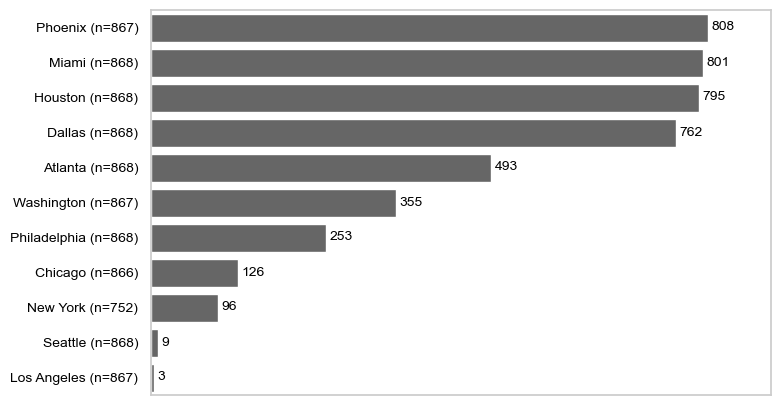

In [193]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap

df1 = pd.read_csv('df_weather_city_year.csv')

# plot
extreme_df = pd.crosstab(df1['heat_class'], df1['city'], margins=True, margins_name='Total').T
extreme_df = extreme_df.reset_index()
extreme_df.columns = ['City', 'Not Extreme', 'Extreme', 'Total']

# Remove 'Total' row
extreme_df = extreme_df[extreme_df.City != 'Total']
extreme_df = extreme_df.sort_values(by='Extreme', ascending=False)

# Capitalize each word and replace underscores with spaces
extreme_df['City'] = extreme_df['City'].str.replace('_', ' ').str.title()

# Set the style of the plot to white background for elegance
sns.set(style="whitegrid")

# Create a horizontal bar plot using seaborn with a dark gold color
plt.figure(figsize=(8, 5))

# Create the bar plot
bar_plot = sns.barplot(x="Extreme", y="City", data=extreme_df, orient="h", color='#666666')  # Dark gold color

# Remove the top and right lines from the plot for more elegance
# sns.despine()

# Set labels and title with more elegant font sizes and adjust positions
plt.xlabel("Number of Extreme Days", fontsize=12, labelpad=15)
plt.ylabel("City (Sample Size)", fontsize=12, labelpad=15)

# Set y-tick labels with sample sizes and change the font properties
font_dict = {'fontsize': 10, 'fontweight': 'normal', 'color': 'black'} # , 'fontfamily': 'serif'
bar_plot.set_yticklabels([f"{city} (n={total})" for city, total in zip(extreme_df['City'], extreme_df['Total'])], 
                         fontdict=font_dict)

# Add data labels and adjust positions
for p in bar_plot.patches:
    width = p.get_width()
    plt.text(x=width + 5,  # set the text at 5 units right of the bar
             y=p.get_y() + p.get_height() / 2,  # Vertically center label
             s='{:.0f}'.format(width),  # cast width to int and format
             va='center',  # center the vertical alignment
             fontsize=10, 
            color='black')  # smaller font size for data labels

# Set the title of the graph and adjust the position
# plt.title("# Extreme Days in MSAs: August and July (2006-2019)", fontsize=12, pad=12, color = 'black')

# Set the x-axis limit to 1000
plt.xlim(0, 900)

# Remove x-axis values
plt.xticks([])

# Hide axis titles
bar_plot.set_xlabel('')
bar_plot.set_ylabel('')

# Add border
# plt.tight_layout()
plt.show()


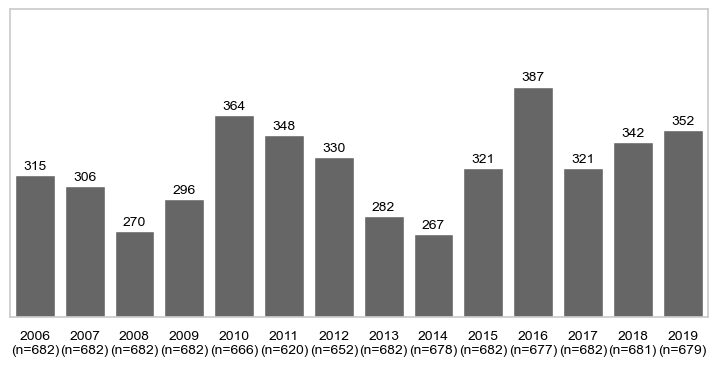

In [194]:
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap

# plot
extreme_df = pd.crosstab(df1['heat_class'], df1['year'], margins=True, margins_name='Total').T.reset_index()
extreme_df.columns = ['Year', 'Not Extreme', 'Extreme', 'Total']

# Remove 'Total' row
extreme_df = extreme_df[extreme_df.Year != 'Total']

# Set the style of the plot to white background for elegance
sns.set(style="whitegrid")

# Create a vertical bar plot using seaborn with a dark gold color
plt.figure(figsize=(9, 4))

# Create the bar plot
bar_plot = sns.barplot(x="Year", y="Extreme", data=extreme_df, orient="v", color='#666666')  # Dark gold color b8860b

# Remove the top and right lines from the plot for more elegance
# sns.despine()

# Set labels and title with more elegant font sizes and adjust positions
plt.xlabel("Year (Sample Size)", fontsize=12, labelpad=15)
plt.ylabel("Number of Extreme Days", fontsize=12, labelpad=15)

# Set x-tick labels with sample sizes and change the font properties
font_dict = {'fontsize': 10, 'fontweight': 'normal', 'color': 'black'} # , 'fontfamily': 'serif'
labels = [f"{year}\n(n={total})" for year, total in zip(extreme_df['Year'], extreme_df['Total'])]
wrapped_labels = [textwrap.fill(label, width=10) for label in labels]
bar_plot.set_xticklabels(wrapped_labels, fontdict=font_dict, rotation=0, ha='center')

# Add data labels and adjust positions
for p in bar_plot.patches:
    height = p.get_height()
    plt.text(x=p.get_x() + p.get_width() / 2,  # Horizontally center label
             y=height + 5,  # set the text 5 units above the bar
             s='{:.0f}'.format(height),  # cast height to int and format
             ha='center',  # center the horizontal alignment
             fontsize=10, 
             color='black')  # smaller font size for data labels

# Set the title of the graph and adjust the position
# plt.title("# Extreme Days by Year: August and July (2006-2019)", fontsize=12, pad=12, color='black')

# Set the y-axis limit to 1000
plt.ylim(200, 450)

# Remove y-axis values
plt.yticks([])

# Hide axis titles
bar_plot.set_xlabel('')
bar_plot.set_ylabel('')

# Add border
# plt.tight_layout()
plt.show()


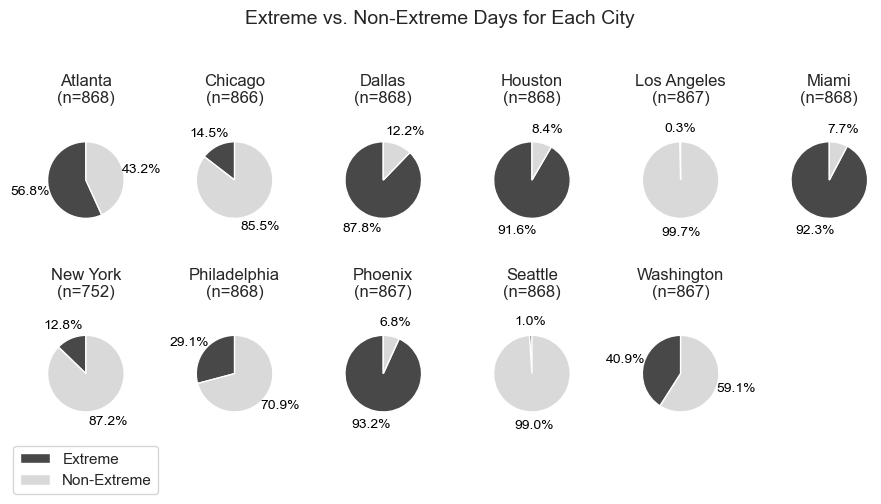

In [195]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Replace 0 and 1 with "Non-Extreme" and "Extreme" in the 'heat_class' column
df1['heat_class'] = df1['heat_class'].replace({0: 'Non-Extreme', 1: 'Extreme'})

# Calculate extreme vs non-extreme days for each city
extreme_df = pd.crosstab(df1['heat_class'], df1['city'])

# Create a pie chart for each city
num_cities = len(extreme_df.columns)
num_rows = (num_cities // 6) + 1  # To display 6 pie charts per row

plt.figure(figsize=(9, 2.5 * num_rows))  # Adjusted the figure size to accommodate more pies per row

for i, city in enumerate(extreme_df.columns):
    plt.subplot(num_rows, 6, i + 1)  # Changed the number of columns to 6

    sizes = extreme_df[city]
    colors = ['#484848', '#D9D9D9']  # Black for Extreme, White for Non-Extreme
    wedges, texts = plt.pie(sizes, colors=colors, startangle=90, autopct=None, textprops={'fontsize': 10}, radius=0.7)  # Decrease pie size, remove autopct
    plt.axis('equal')

    # Remove underscores from city names, capitalize each word
    city_name = ' '.join(word.capitalize() for word in city.split('_'))

    # Get the sample size for the current city
    sample_size = df1[df1['city'] == city]['heat_class'].count()

    # Manually split the title into two lines: city name and sample size (N)
    title_line1 = city_name
    title_line2 = f"(n={sample_size})"
    title = f"{title_line1}\n{title_line2}"

    plt.title(title, fontsize=12)  # Show city name with sample size as N=

    # Add data labels outside the pie
    total = sum(sizes)
    labels = set()  # Store labels to check for duplicates
    for w, s in zip(wedges, sizes):
        angle = (w.theta2 - w.theta1) / 2.0 + w.theta1
        x = 1.05 * np.cos(np.deg2rad(angle))  # Increase radius to 0.8
        y = 0.95 * np.sin(np.deg2rad(angle))  # Increase radius to 0.8
        label = f"{s / total * 100:.1f}%"  # Calculate percentage
        if label not in labels:
            plt.text(x, y, label, fontsize=10, ha='center', va='center', color='black')  # Change color to black for better visibility
            labels.add(label)

# Create a single legend for all pies
legend_axes = plt.subplot(num_rows, 6, (num_rows-1) * 6 + 1)  # Changed the number of columns to 6
plt.legend(labels=extreme_df.index, loc='center', bbox_to_anchor=(0.5, -0.2), ncol=1, fontsize=11)  # Set ncol to 1 for vertical display
legend_axes.set_axis_off()  # Turn off the legend axes so it doesn't interfere with other plots

plt.suptitle("Extreme vs. Non-Extreme Days for Each City", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


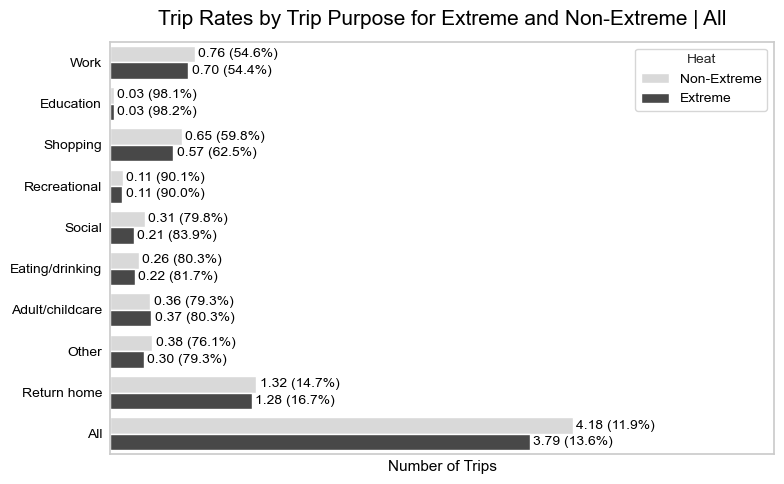

In [196]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the font for the entire plot
plt.rcParams['font.family'] = 'sans-serif'  # replace 'Arial' with your preferred font

# Load the data
data = pd.read_csv('trip_freq_by_purpose.csv')

# Recode columns and values
data['temp'] = data['temp'].map({1: 'Extreme', 0: 'Non-Extreme'})
data.columns = data.columns.str.replace('_num_of_trips', '_number_of_trips')
data.columns = data.columns.str.replace('_zt_mean', '_zero_participation_percent')
data.columns = data.columns.str.replace('tr_', '')
data['segment'] = data['segment'].str.replace('_', ' ').str.title()

# Filter data for 'All' segment
all_segment_data = data[data['segment'] == 'All']

# Keep the last two rows
all_segment_data = all_segment_data.tail(2)

# Melt the DataFrame
melted_data = all_segment_data.melt(id_vars=['segment', 'temp', 'count'], var_name='trip_purpose', value_name='value')

# Separate the number of trips and zero participation percent into separate DataFrames
number_of_trips_data = melted_data[melted_data['trip_purpose'].str.contains('number_of_trips')].copy()
number_of_trips_data['trip_purpose'] = number_of_trips_data['trip_purpose'].str.replace('_number_of_trips', '')

zero_participation_data = melted_data[melted_data['trip_purpose'].str.contains('zero_participation_percent')].copy()
zero_participation_data['trip_purpose'] = zero_participation_data['trip_purpose'].str.replace('_zero_participation_percent', '')

# Merge the number of trips and zero participation percent DataFrames
merged_data = pd.merge(number_of_trips_data, zero_participation_data, on=['segment', 'temp', 'count', 'trip_purpose'])
merged_data.columns = ['segment', 'temp', 'count', 'trip_purpose', 'number_of_trips', 'zero_participation_percent']

# Define colors for bars
colors = {'Non-Extreme': '#D9D9D9', 'Extreme': '#484848'}  # replace '#D9D9D9' and '#484848' with your preferred colors

# Plot
plt.figure(figsize=(8, 5))
bar_plot_total = sns.barplot(x='number_of_trips', y='trip_purpose', hue='temp', data=merged_data, palette=colors)
bar_plot_total.tick_params(axis='both', labelsize=10)  # Set font size for both x and y-axis tick labels

# Set font sizes for different parts of the plot
plt.title('Trip Rates by Trip Purpose for Extreme and Non-Extreme | ' + merged_data['segment'].unique()[0], fontsize=15, pad=12, color='#000000')  # replace '15' with your preferred font size
# plt.title('Trip Rates by Trip Purpose for Extreme and Non-Extreme', fontsize=15, pad=12, color='#000000')  # replace '15' with your preferred font size
plt.xlabel('Number of Trips', fontsize=11, color='#000000')  # replace '12' with your preferred font size
plt.ylabel('', fontsize=10)  # replace '12' with your preferred font size
legend = plt.legend(title='Heat', title_fontsize='10', fontsize='10') 
for text in legend.get_texts():
    text.set_color('#000000')

# Get unique trip purposes and their corresponding indices
trip_purposes = merged_data['trip_purpose'].unique()
y_positions = range(len(trip_purposes))

# Define a dictionary to map original trip purposes to custom labels
custom_labels_dict = {
    'work': 'Work',
    'education': 'Education',
    'shopping': 'Shopping',
    'recreational': 'Recreational',
    'social': 'Social',
    'eat': 'Eating/drinking',
    'hh_nhh_memcare': 'Adult/childcare',
    'other': 'Other',
    'return_home': 'Return home',
    'trip_sum': 'All'
}

# Update the y-axis tick labels using the dictionary
plt.yticks(y_positions, [custom_labels_dict[purpose.lower()] for purpose in trip_purposes], fontsize=10, color='#000000')

plt.tick_params(axis='y', pad=0)  # Adjust the 'pad' value as needed to reduce or increase the space

# Hide x-axis labels
plt.xticks([])

# Set the x-axis limit
plt.xlim(0, 6)  # Replace 100 with your desired x-axis limit

# Add data labels
for i in range(merged_data.shape[0]):
    row = merged_data.iloc[i]
    zero_participation_percent = row['zero_participation_percent']
    number_of_trips = row['number_of_trips']
    trip_purpose = row['trip_purpose']
    temp = row['temp']
    label = '{:1.2f} ({:1.1f}%)'.format(number_of_trips, zero_participation_percent * 100) # create label with zero participation percent
    x_location = number_of_trips
    y_location = merged_data['trip_purpose'].unique().tolist().index(trip_purpose)
    if temp == 'Extreme':
        y_location += 0.2
    else:
        y_location -= 0.2
    plt.text(x_location + 0.03,       # set the text at 1 unit right of the bar
             y_location, # get Y coordinate + X coordinate / 2
             label, # set variable to display, 2 decimals
             ha = 'left',   # horizontal alignment
             va = 'center', # vertical alignment
             fontsize=10, color='#000000')   # replace '8' with your preferred font size for data labels

# Adjust spacing around the plot to add space between title and graph
plt.subplots_adjust(top=0.9)  # Adjust the 'top' parameter as needed to control the spacing

# Make the plot tight
plt.tight_layout()

plt.show()


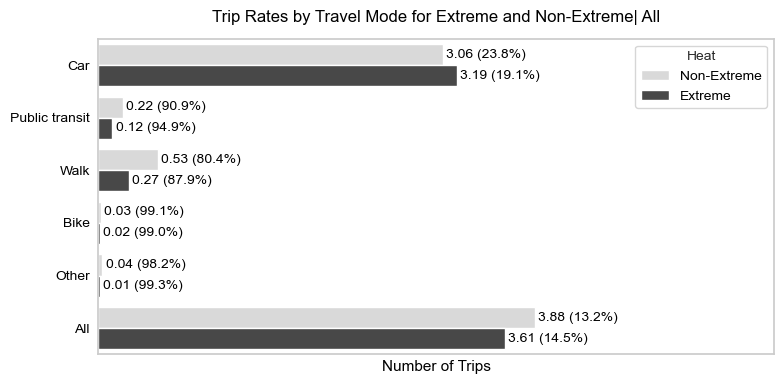

In [197]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the font for the entire plot
plt.rcParams['font.family'] = 'sans-serif'  # replace 'Arial' with your preferred font

# Load the data
data = pd.read_csv('trip_freq_by_mode.csv')

# Recode columns and values
data['temp'] = data['temp'].map({1: 'Extreme', 0: 'Non-Extreme'})
data.columns = data.columns.str.replace('_num_of_trips', '_number_of_trips')
data.columns = data.columns.str.replace('_zt_mean', '_zero_participation_percent')
data.columns = data.columns.str.replace('tr_', '')
data['segment'] = data['segment'].str.replace('_', ' ').str.title()

# Filter data for 'All' segment
all_segment_data = data[data['segment'] == 'All']

# Keep the last two rows
all_segment_data = all_segment_data.tail(2)

# Melt the DataFrame
melted_data = all_segment_data.melt(id_vars=['segment', 'temp', 'count'], var_name='trip_purpose', value_name='value')

# Separate the number of trips and zero participation percent into separate DataFrames
number_of_trips_data = melted_data[melted_data['trip_purpose'].str.contains('number_of_trips')].copy()
number_of_trips_data['trip_purpose'] = number_of_trips_data['trip_purpose'].str.replace('_number_of_trips', '')

zero_participation_data = melted_data[melted_data['trip_purpose'].str.contains('zero_participation_percent')].copy()
zero_participation_data['trip_purpose'] = zero_participation_data['trip_purpose'].str.replace('_zero_participation_percent', '')

# Merge the number of trips and zero participation percent DataFrames
merged_data = pd.merge(number_of_trips_data, zero_participation_data, on=['segment', 'temp', 'count', 'trip_purpose'])
merged_data.columns = ['segment', 'temp', 'count', 'trip_purpose', 'number_of_trips', 'zero_participation_percent']

# Define colors for bars
colors = {'Non-Extreme': '#D9D9D9', 'Extreme': '#484848'}  # replace '#D9D9D9' and '#484848' with your preferred colors

# Plot
plt.figure(figsize=(8, 4))
bar_plot_total = sns.barplot(x='number_of_trips', y='trip_purpose', hue='temp', data=merged_data, palette=colors)
bar_plot_total.tick_params(axis='both', labelsize=10)  # Set font size for both x and y-axis tick labels

# Set font sizes for different parts of the plot
plt.title('Trip Rates by Travel Mode for Extreme and Non-Extreme| ' + merged_data['segment'].unique()[0], fontsize=12,  pad=12, color='#000000')  # replace '15' with your preferred font size
# plt.title('Trip Rates by Travel Mode for Extreme and Non-Extreme', fontsize=12,  pad=12, color='#000000')  # replace '15' with your preferred font size
plt.xlabel('Number of Trips', fontsize=11, color='#000000')  # replace '12' with your preferred font size
plt.ylabel('', fontsize=10)  # replace '12' with your preferred font size
legend = plt.legend(title='Heat', title_fontsize='10', fontsize='10') 
for text in legend.get_texts():
    text.set_color('#000000')

# Get unique trip purposes and their corresponding indices
trip_purposes = merged_data['trip_purpose'].unique()
y_positions = range(len(trip_purposes))

# Define a dictionary to map original trip purposes to custom labels
custom_labels_dict = {
    'car_mode': 'Car',
    'transit_mode': 'Public transit',
    'walk_mode': 'Walk',
    'bike_mode': 'Bike',
    'other_mode': 'Other',
    'trip_sum_mode': 'All'
}

# Update the y-axis tick labels using the dictionary
plt.yticks(y_positions, [custom_labels_dict[purpose.lower()] for purpose in trip_purposes], fontsize=10, color='#000000')

plt.tick_params(axis='y', pad=0)  # Adjust the 'pad' value as needed to reduce or increase the space

# Hide x-axis labels
plt.xticks([])

# Set the x-axis limit
plt.xlim(0, 6)  # Replace 100 with your desired x-axis limit

# Add data labels
for i in range(merged_data.shape[0]):
    row = merged_data.iloc[i]
    zero_participation_percent = row['zero_participation_percent']
    number_of_trips = row['number_of_trips']
    trip_purpose = row['trip_purpose']
    temp = row['temp']
    label = '{:1.2f} ({:1.1f}%)'.format(number_of_trips, zero_participation_percent * 100) # create label with zero participation percent
    x_location = number_of_trips
    y_location = merged_data['trip_purpose'].unique().tolist().index(trip_purpose)
    if temp == 'Extreme':
        y_location += 0.2
    else:
        y_location -= 0.2
    plt.text(x_location + 0.03,       # set the text at 1 unit right of the bar
             y_location, # get Y coordinate + X coordinate / 2
             label, # set variable to display, 2 decimals
             ha = 'left',   # horizontal alignment
             va = 'center', # vertical alignment
             fontsize=10, color='#000000')   # replace '8' with your preferred font size for data labels

# Adjust spacing around the plot to add space between title and graph
plt.subplots_adjust(top=0.9)  # Adjust the 'top' parameter as needed to control the spacing

# Make the plot tight
plt.tight_layout()

plt.show()


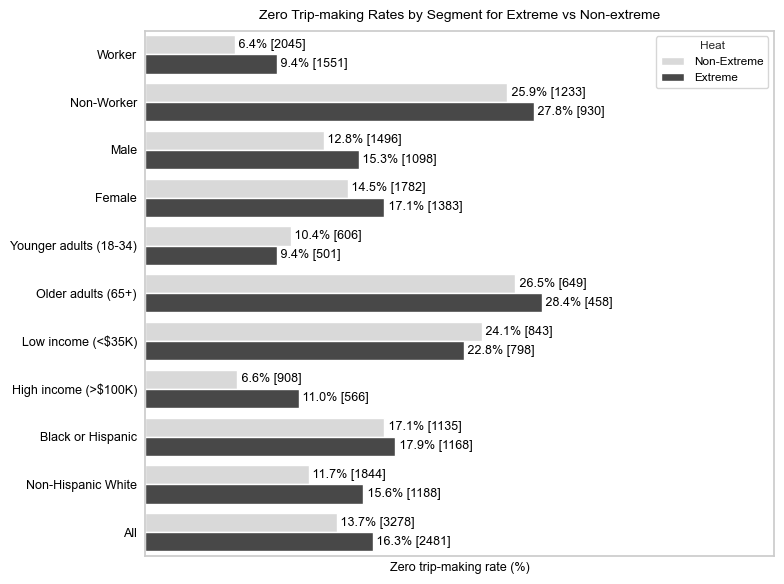

In [198]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the font for the entire plot
plt.rcParams['font.family'] = 'sans-serif'  # replace 'Arial' with your preferred font

# Load the data
data = pd.read_csv('wb_tp_zt_results.csv')

# Recode columns and values
data['temp'] = data['temp'].map({1: 'Extreme', 0: 'Non-Extreme'})
data['zt_mean'] = data['zt_mean']*100
merged_data = data

# Define colors for bars
colors = {'Non-Extreme': '#D9D9D9', 'Extreme': '#484848'}  # replace '#D9D9D9' and '#484848' with your preferred colors

# Plot
plt.figure(figsize=(8, 6))
bar_plot_total = sns.barplot(x='zt_mean', y='segment', hue='temp', data=merged_data, palette=colors)
bar_plot_total.tick_params(axis='both', labelsize=10)  # Set font size for both x and y-axis tick labels

# Set font sizes for different parts of the plot
plt.title('Zero Trip-making Rates by Segment for Extreme vs Non-extreme', fontsize=10, pad=8, color='#000000')  # replace '15' with your preferred font size
plt.xlabel('Zero trip-making rate (%)', fontsize=9, color='#000000')  # replace '12' with your preferred font size
plt.ylabel('', fontsize=10)  # replace '12' with your preferred font size
legend = plt.legend(title='Heat', title_fontsize='8.5', fontsize='8.5') 
for text in legend.get_texts():
    text.set_color('#000000')

# Get unique trip purposes and their corresponding indices
segments = merged_data['segment'].unique()
y_positions = range(len(segments))

# Define a dictionary to map original trip purposes to custom labels
custom_labels_dict = {
    'employed': 'Worker',
    'non_worker': 'Non-Worker',
    'male': 'Male',
    'female': 'Female',
    'age_18_34': 'Younger adults (18-34)',
    'age_65p': 'Older adults (65+)',
    'inc_up35': 'Low income (<$35K)',
    'inc_100p': 'High income (>$100K)',
    'black_hisp': 'Black or Hispanic',
    'non_hisp_white': 'Non-Hispanic White',
        'all': 'All'

}

# Update the y-axis tick labels using the dictionary
plt.yticks(y_positions, [custom_labels_dict[purpose.lower()] for purpose in segments], fontsize=9, color='#000000')

plt.tick_params(axis='y', pad=0)  # Adjust the 'pad' value as needed to reduce or increase the space

# Hide x-axis labels
plt.xticks([])

# Set the x-axis limit
plt.xlim(0, 45)  # Replace 100 with your desired x-axis limit

# Add data labels
for i in range(merged_data.shape[0]):
    row = merged_data.iloc[i]
    number_of_trips = row['zt_mean']
    n_count = row['count']
    segment = row['segment']
    temp = row['temp']
    label = '{: 1.1f}% [{:1.0f}]'.format(number_of_trips, n_count) # create label with zero participation percent
    x_location = number_of_trips
    y_location = merged_data['segment'].unique().tolist().index(segment)
    if temp == 'Extreme':
        y_location += 0.2
    else:
        y_location -= 0.2
    plt.text(x_location + 0.03,       # set the text at 1 unit right of the bar
             y_location, # get Y coordinate + X coordinate / 2
             label, # set variable to display, 2 decimals
             ha = 'left',   # horizontal alignment
             va = 'center', # vertical alignment
             fontsize=9, color='#000000')   # replace '8' with your preferred font size for data labels

# Adjust spacing around the plot to add space between title and graph
plt.subplots_adjust(top=0.9)  # Adjust the 'top' parameter as needed to control the spacing


# Make the plot tight
plt.tight_layout()

plt.show()
